# Tree Diagrams
## A Climate Asset Pricing model -- AR6 analysis notebook

This notebook lets users create tree diagrams to analyze node-by-node output of the Climate Asset Pricing model -- AR6.

In [32]:
import datetime

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

from src.tree import TreeModel
from src.climate import BPWClimate
from src.emit_baseline import BPWEmissionBaseline
from src.damage import BPWDamage
from src.tools import import_csv
from src.analysis.output_unpacker import OutputUnpacker
from src.analysis.tree_diagrams import TreeDiagram

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 16, 10
params = {'legend.fontsize': 14,
          'legend.frameon': True,
          'figure.figsize': (16, 10),
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'xtick.labelsize': 18,
         'ytick.labelsize': 18,
         'font.family': 'serif'}
mpl.rcParams.update(params)

# make base filename
today = datetime.datetime.now()
year = str(today.year)
day = str(today.day)
month = str(today.month)

basefile = ''.join(["/data/keeling/a/adammb4/ClimateEcon/ez-climate/TCREZClimate/docs/figdump/", month, '-', day, '-', year, '-'])

## Make instances of model classes, store output

In [33]:

"""Import header, indices, and data from reference .csv file.
"""

data_csv_file = 'BPW_research_runs'
header, indices, data = import_csv(data_csv_file, delimiter=',', indices=2)

"""Run TCREZClimate for runs of interest. To change which runs the code does,
change desired_runs.
"""

# runs needing analysis
done_runs = [275, 276, 277, 278]
#done_runs = [275]

tree_list = []
damage_list = []
climate_list = []
emit_baseline_list = []

for i in done_runs:
    ra, eis, pref, growth, tech_chg, tech_scale, dam_func,\
            baseline_num, tip_on, bs_premium, crra_on, d_unc, t_unc, d_var_mult, t_var_mult = data[i]

    baseline_num = int(baseline_num)
    dam_func = int(dam_func)
    tip_on = int(tip_on)
    crra_on = int(crra_on)
    d_unc = int(d_unc)
    t_unc = int(t_unc)

    """On if CRRA preferences are desired. In our model, this amounts to
    setting RA = 1/EIS. The base case value of EIS is 0.9. If EIS is not
    0.9, then we are doing a sensitivity test of EIS, and therefore the RA is
    determined by the EIS. Otherwise, EIS is determined by RA.
    """

    if crra_on:
        if eis != 0.9:
            ra = eis**(-1)
        else:
            eis = ra**(-1)

    model_params = [ra, eis, pref, growth, tech_chg, tech_scale,\
                    dam_func, baseline_num, tip_on, bs_premium, crra_on, d_unc,
                    t_unc, d_var_mult, t_var_mult]

    """Initialize model classes. First is the tree model.
    """

    tmp_tree = TreeModel(decision_times=[0, 10, 40, 80, 130, 180, 230],
                  prob_scale=1.0)

    """Emission baseline model. We also run its setup function.
    """

    tmp_baseline_emission_model = BPWEmissionBaseline(tree=tmp_tree,
                                                  baseline_num=baseline_num)
    tmp_baseline_emission_model.baseline_emission_setup()

    """Climate class. We set draws to the number of Monte Carlo samples to take
    from damage distributions, such as TCRE, and if the floor is on.
    """

    draws = 3 * 10**6
    tmp_climate = BPWClimate(tmp_tree, tmp_baseline_emission_model, draws=draws, t_var_mult=t_var_mult)

    """Damage class. We set draws to the number of Monte Carlo samples to take
    from damage distributions, such as TCRE. We also pass a list of constant
    values of mitigation for the damage simulation.
    """

    d_m = 0.01
    mitigation_constants = np.arange(0, 1 + d_m, d_m)[::-1]
    tmp_df = BPWDamage(tree=tmp_tree, emit_baseline=tmp_baseline_emission_model,
                   climate=tmp_climate, mitigation_constants=mitigation_constants,
                   draws=draws)

    """Run the damage simulation. If a damage simulation has already been run,
    then comment the line below and uncomment the df.import_damages() line.

    NOTE: import_damages has the optional argument for a filename. This is
    important if you're varying the damage function across simulations.

    The default is currently "BPW_simulated_damages_TCRE.csv".
    """

    damsim_filename = ''.join(["BPW_simulated_damages_df", str(dam_func),
                               "_TP", str(tip_on), "_SSP", str(baseline_num),
                               "_dunc", str(d_unc), "_tunc", str(t_unc), "_dmult", str(d_var_mult),
                              "_tmult", str(t_var_mult)])

    tmp_df.import_damages(file_name=damsim_filename)
    
    tree_list.append(tmp_tree)
    emit_baseline_list.append(tmp_baseline_emission_model)
    climate_list.append(tmp_climate)
    damage_list.append(tmp_df)

Damages imported successfully!
Damages imported successfully!
Damages imported successfully!
Damages imported successfully!


In [34]:
# list of prefixes to output files of EZClimate. i.e., the string before "_node_period_output.csv".
# in EZClimate main file, this is the parameter "name" located at about line 42 

# prefixes ("name" variable in main file)
prefix_list = ['pref-run', 'feat-15', 'feat-25', 'feat-3']

# path to data, in order of the prefixes listed above
path_list = ['/data/keeling/a/adammb4/ClimateEcon/ez-climate/TCREZClimate/data/'] * len(prefix_list) 

# file description - this will be used in plot titles and helps keep track of which file is which
# in the prefix_list
descriptions = ['2% discount rate', '1.5% discount rate', '2.5% discount rate', '3% discount rate']


# make list of file names to be unpacked
output_list = []
picklefile_list = []

# total files
N_files = len(prefix_list)

# populate output_list and picklefile_list
for file in range(0, N_files):
    tmp_filename = path_list[file] + prefix_list[file] + "_node_period_output.csv"
    tmp_picklefile_name = path_list[file] + prefix_list[file] + "_log.pickle"
    output_list.append(tmp_filename)
    picklefile_list.append(tmp_picklefile_name)

In [35]:
# use OutputUnpacker to "unpack" the files above

# make one array of objects which correspond to the 'output' files (i.e., the files that end with
# _node_period_output.csv) and another for the pickle files
output_obj_list = []
pickle_obj_list = []

# populate these arrays
for file in range(0, N_files):
    tmp_output_obj = OutputUnpacker(output_list[file], descriptions[file], 'output', 
                                    tree=tree_list[file], emit_baseline=emit_baseline_list[file],
                                    climate=climate_list[file], damage=damage_list[file])
    output_obj_list.append(tmp_output_obj)
    tmp_pickle_obj = OutputUnpacker(picklefile_list[file], descriptions[file], 'pickle',
                                    tree=tree_list[file], emit_baseline=emit_baseline_list[file],
                                    climate=climate_list[file], damage=damage_list[file])
    pickle_obj_list.append(tmp_pickle_obj)

## Save your output?

In [36]:
save_fig = False

### Mitigation


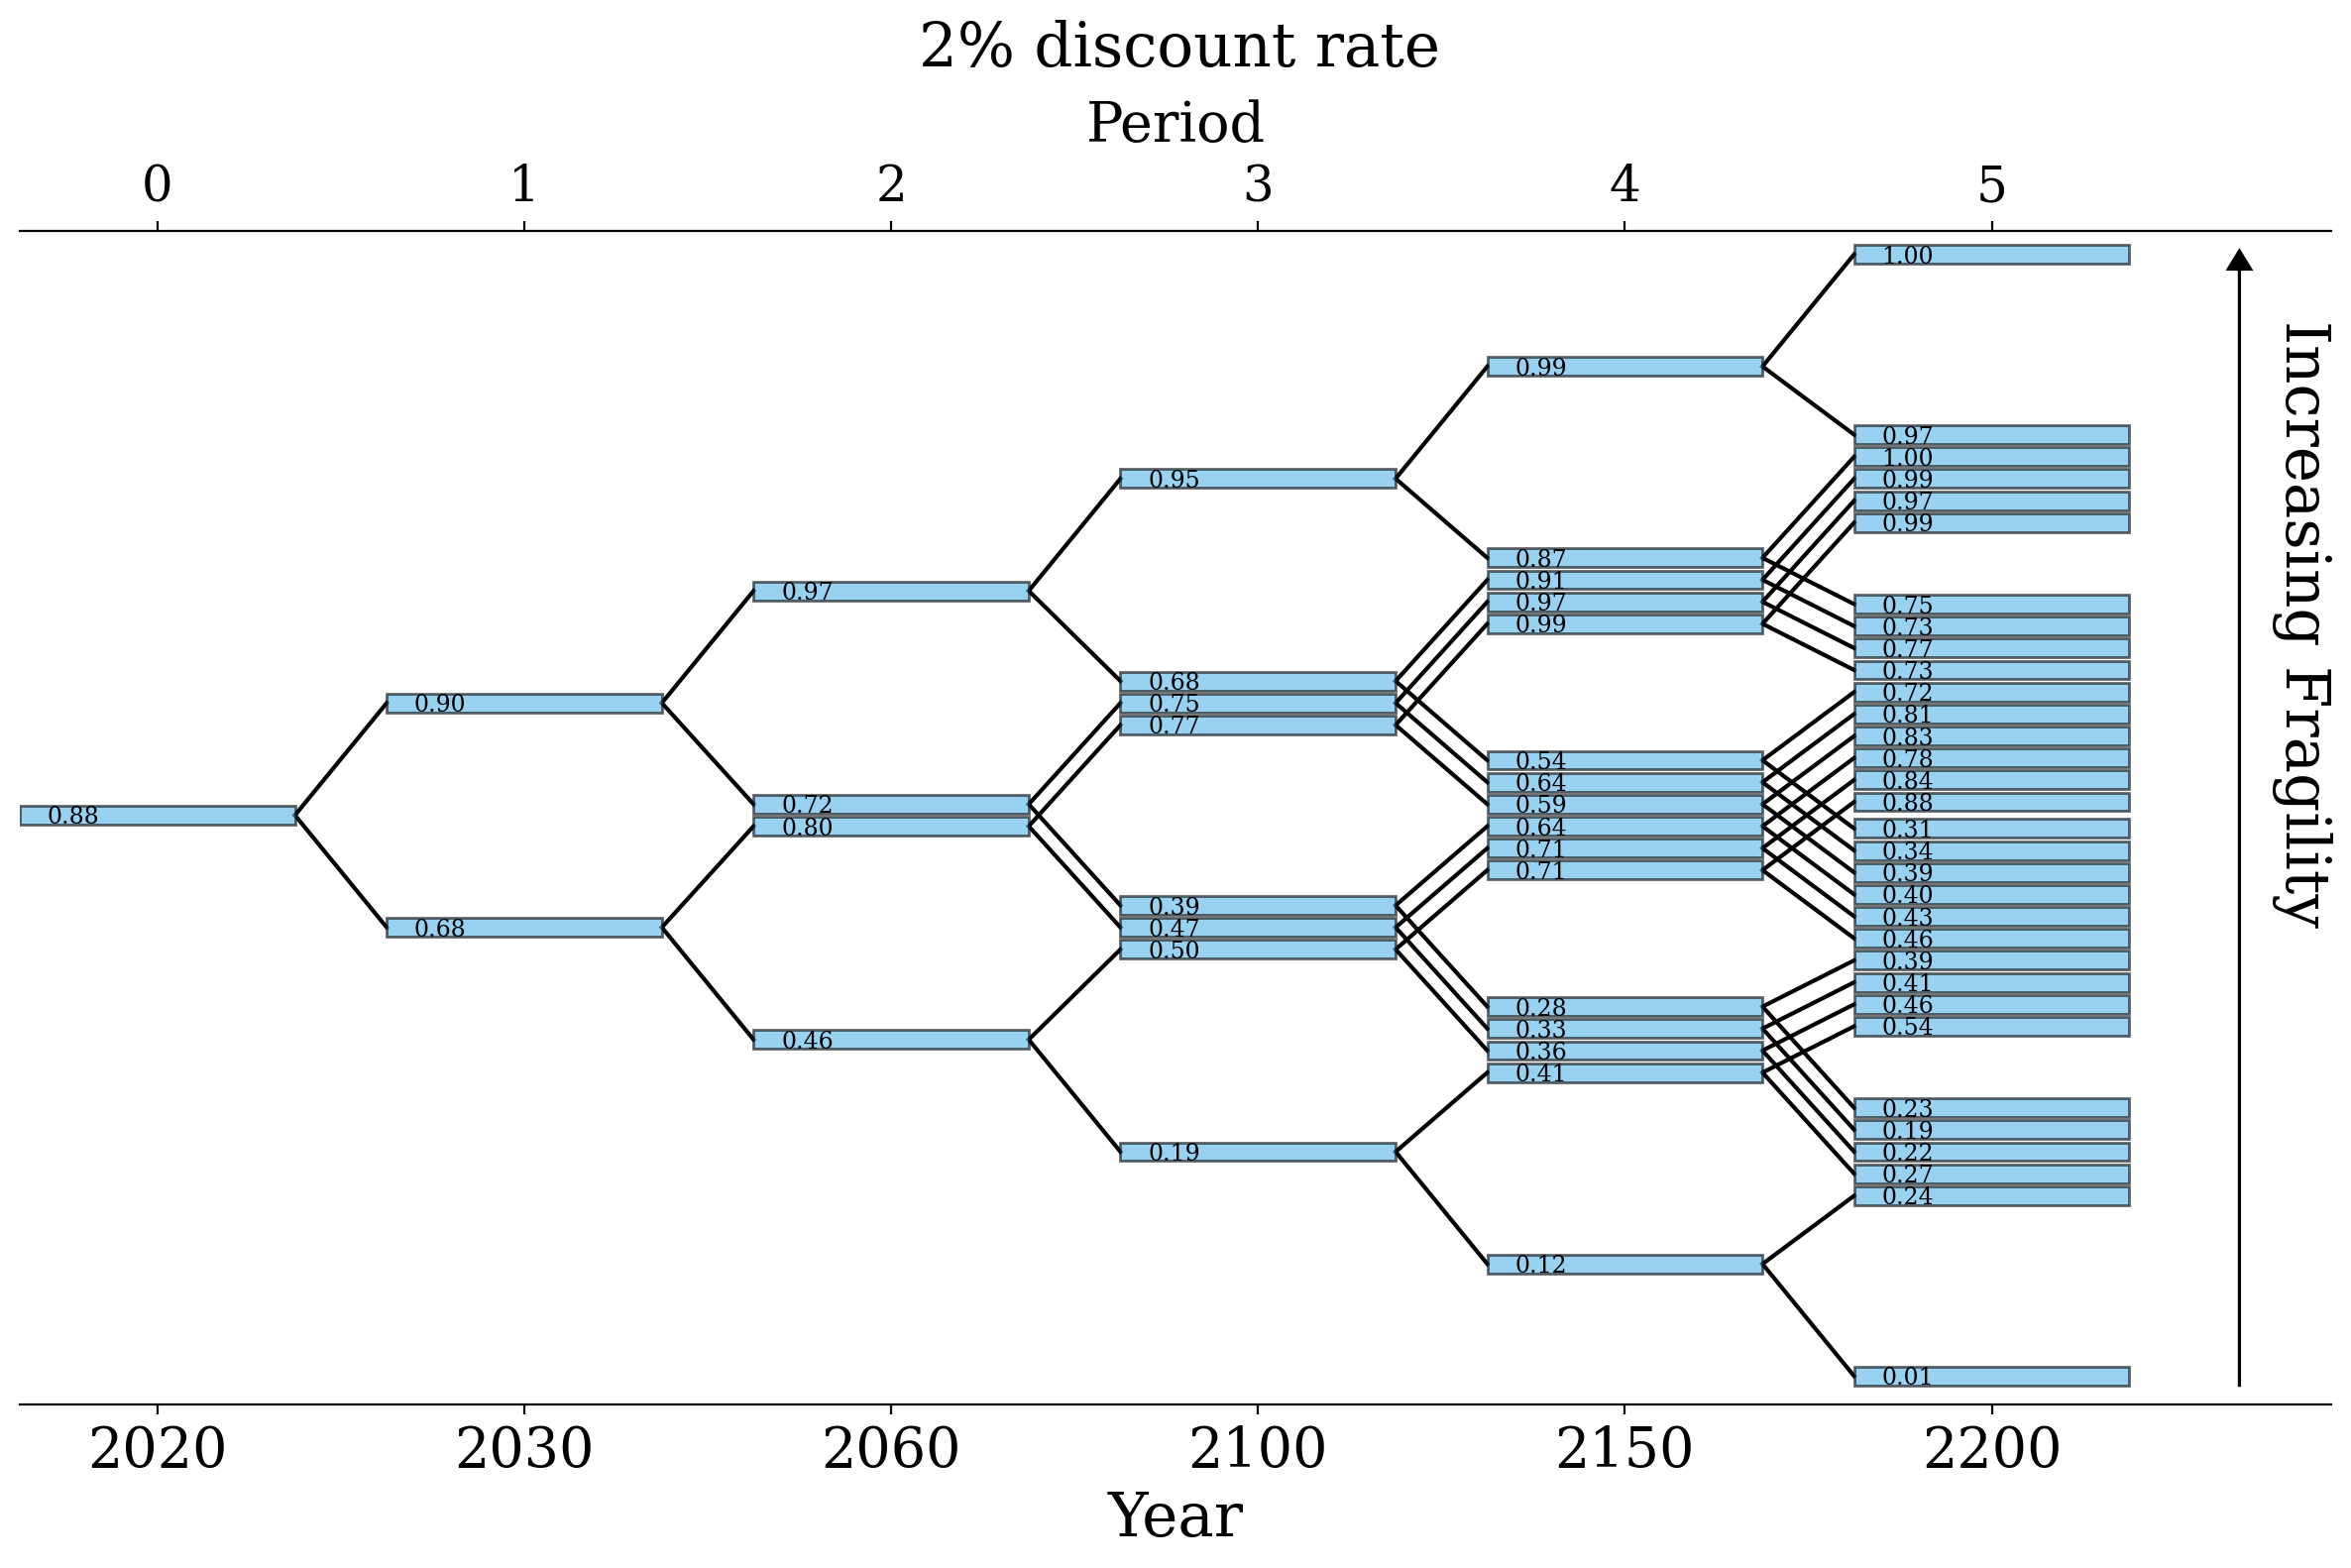

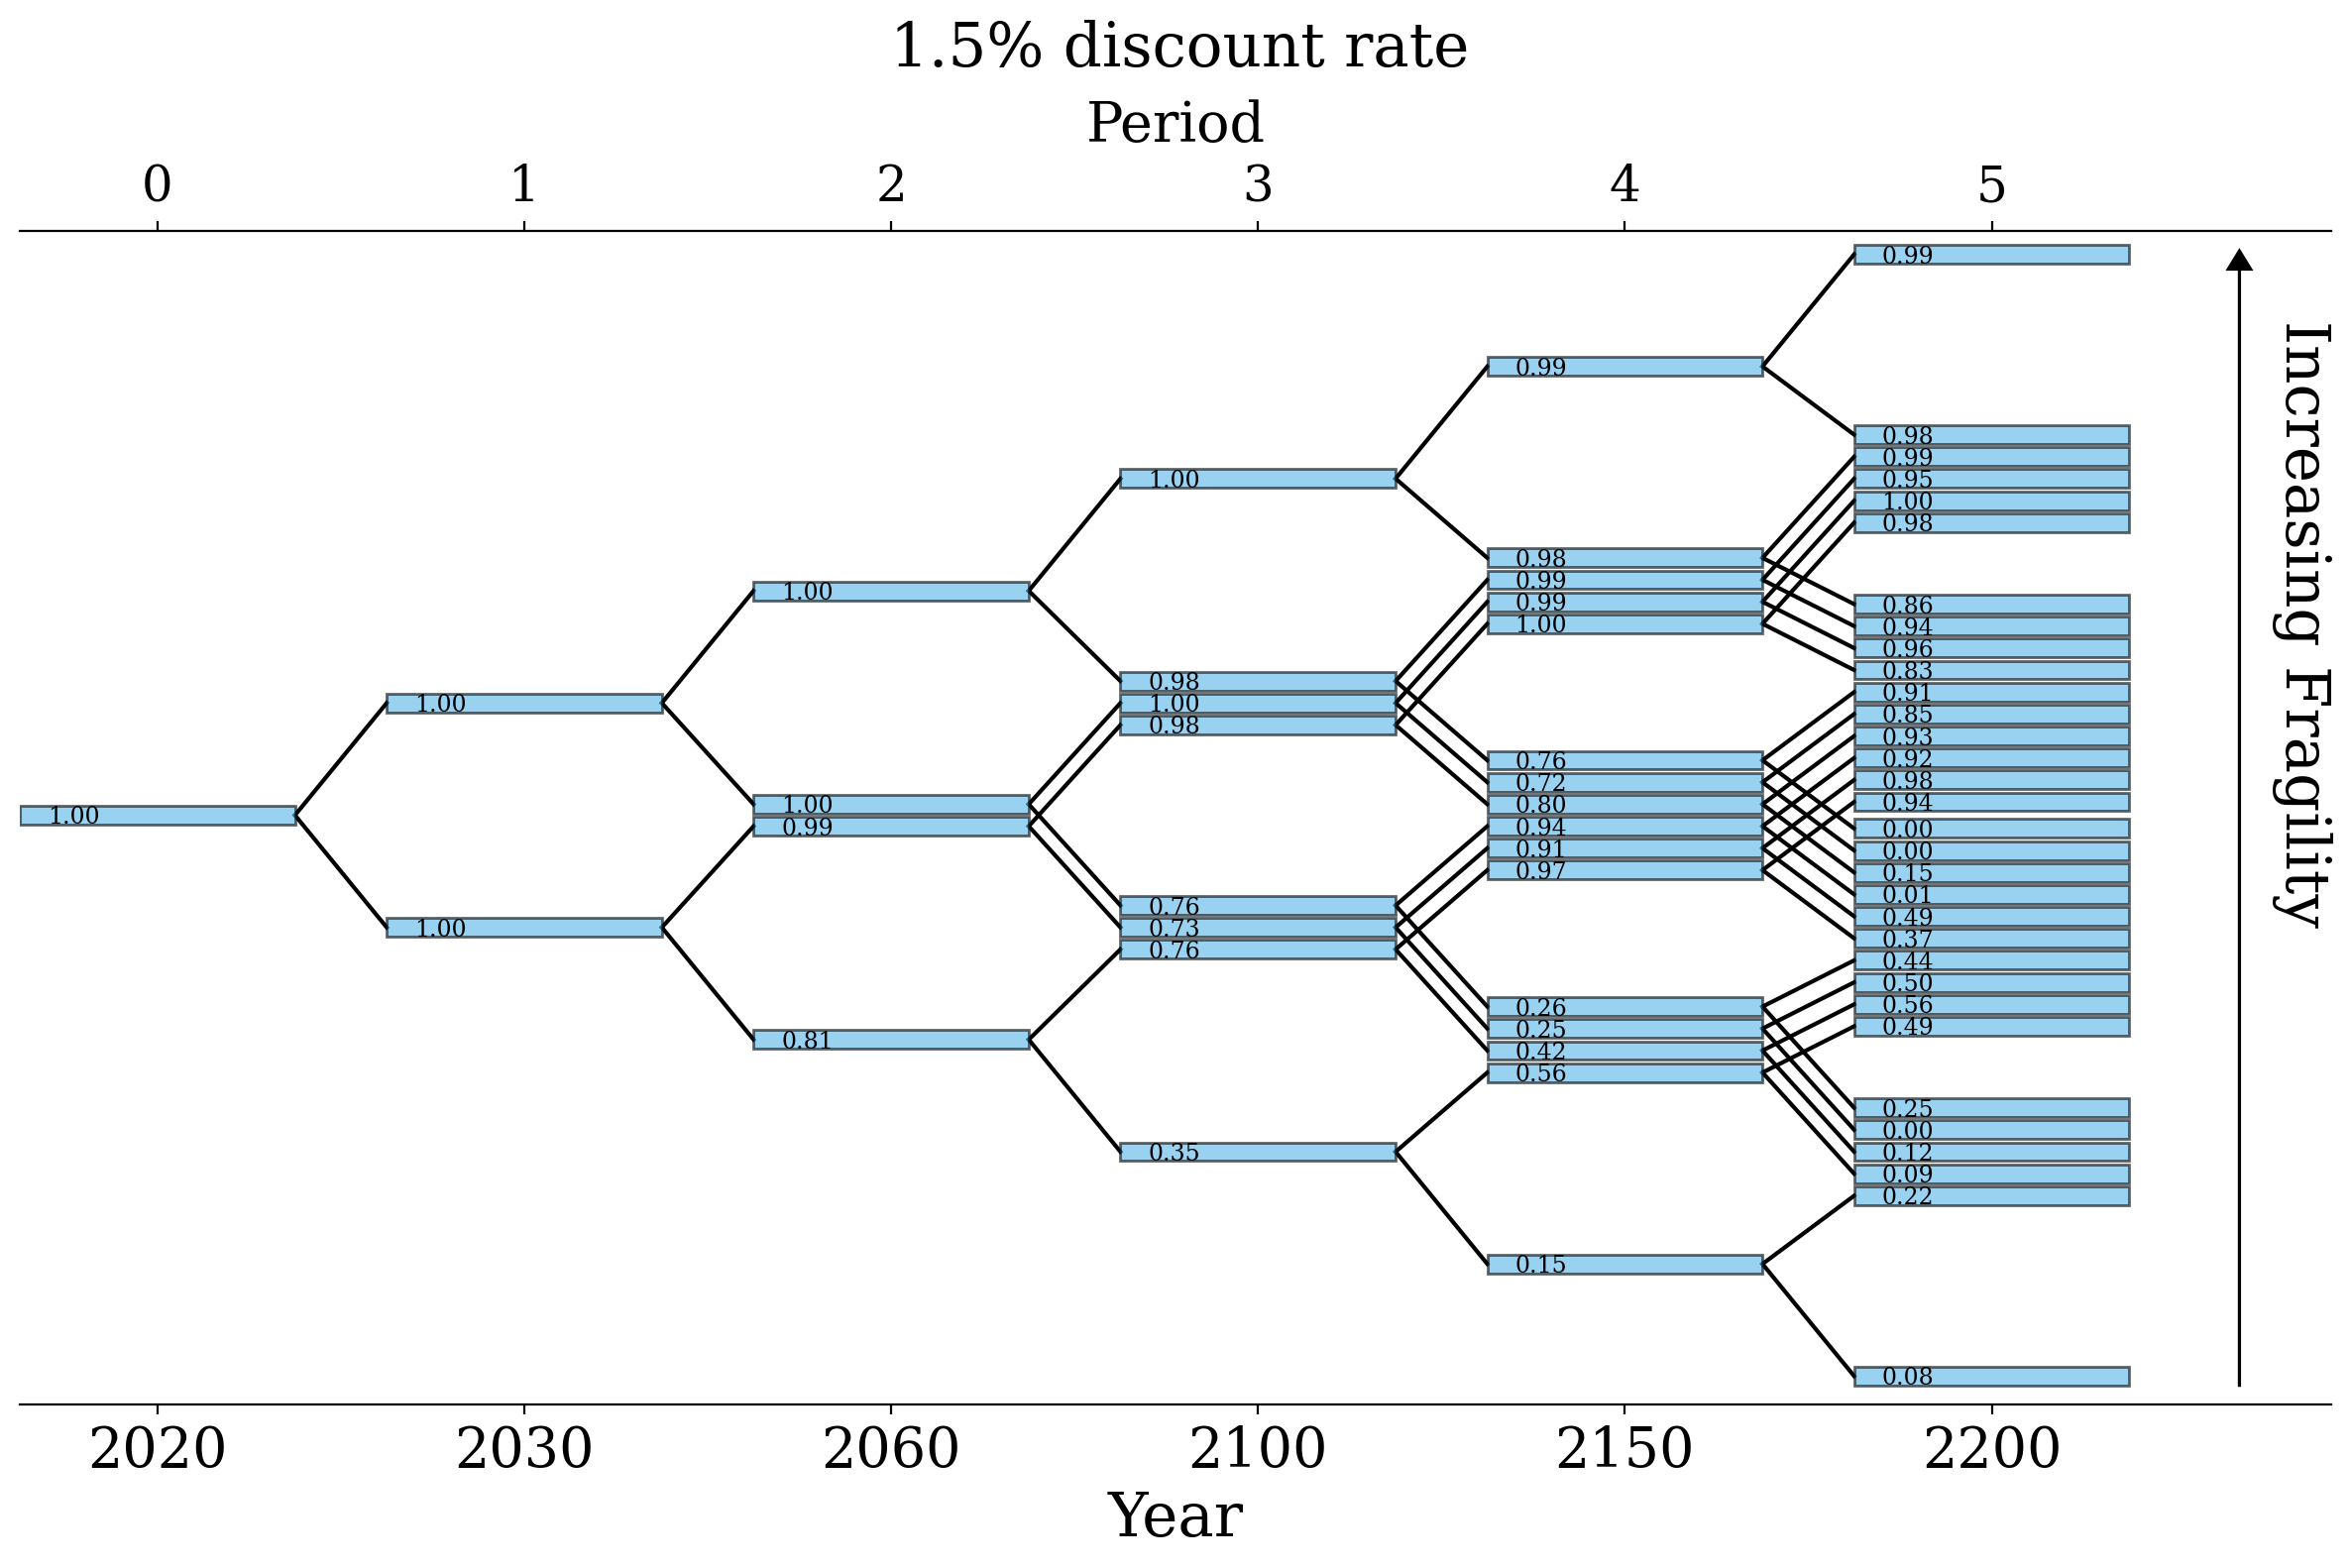

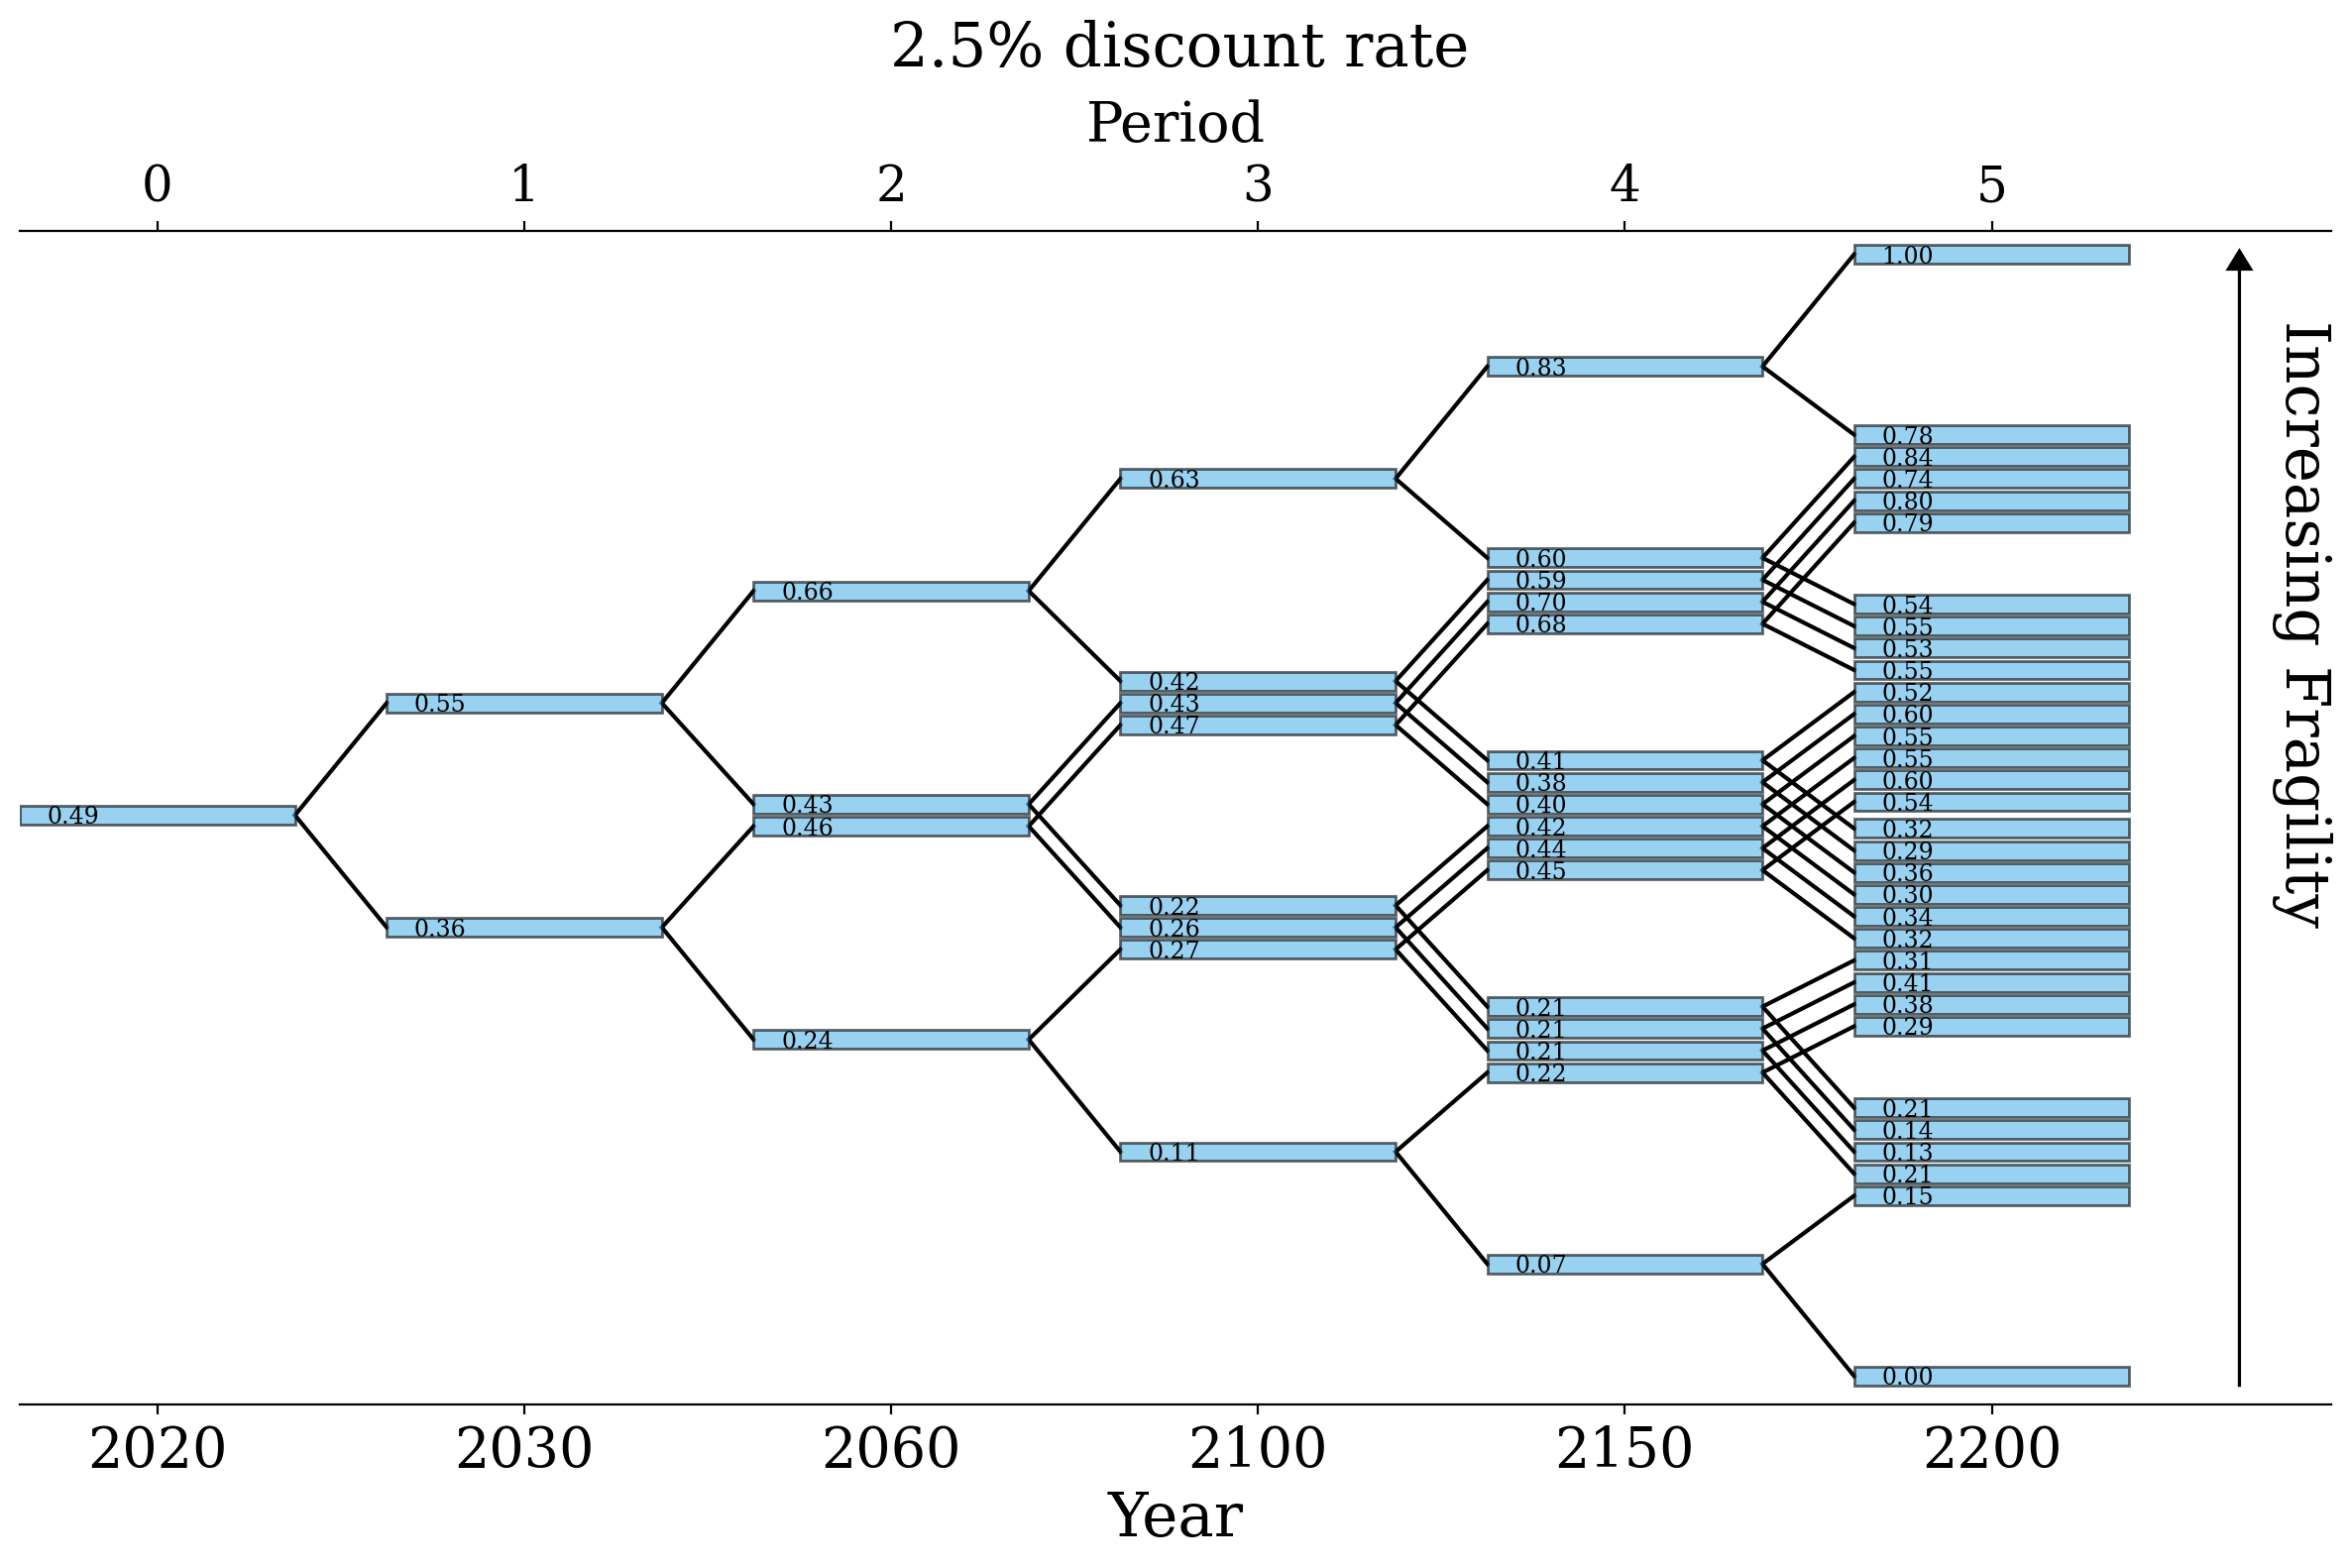

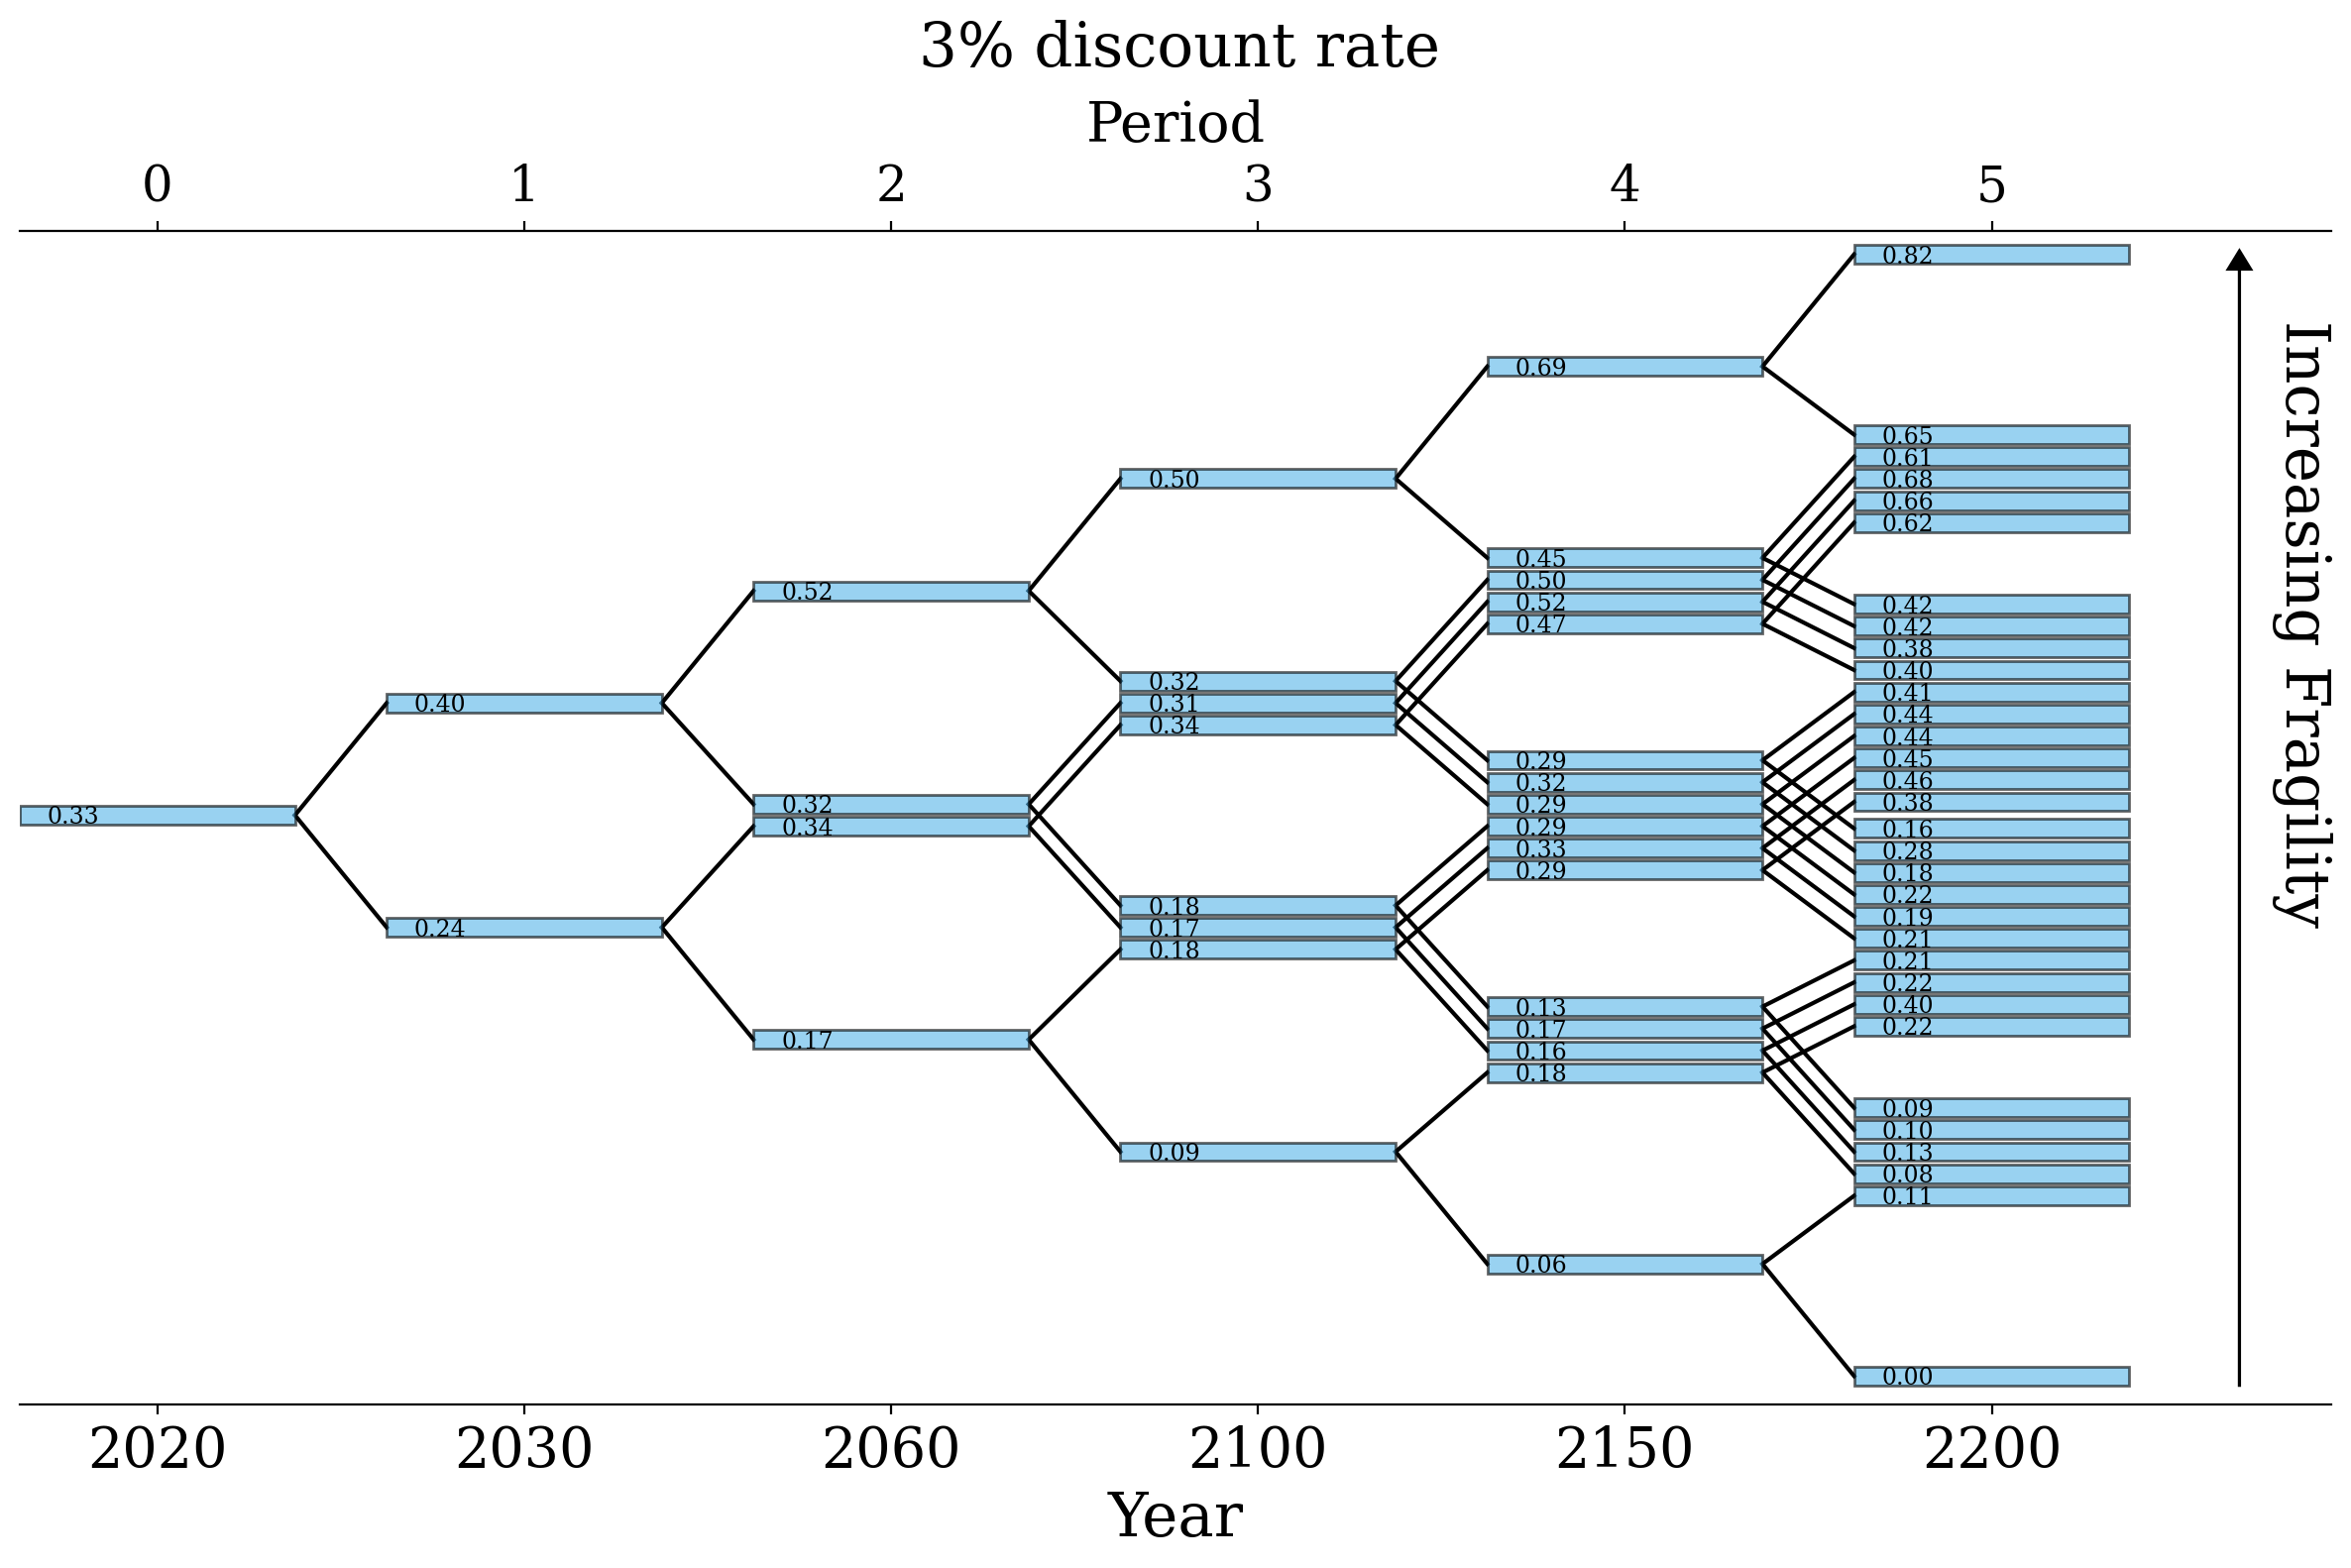

In [37]:
for file in range(0, N_files):
    tmp_Tree = TreeDiagram(6, pickle_obj_list[file].m_opt_node, False, descriptions[file], save_fig=save_fig)
    tmp_Tree.makePlot()

### Temperature

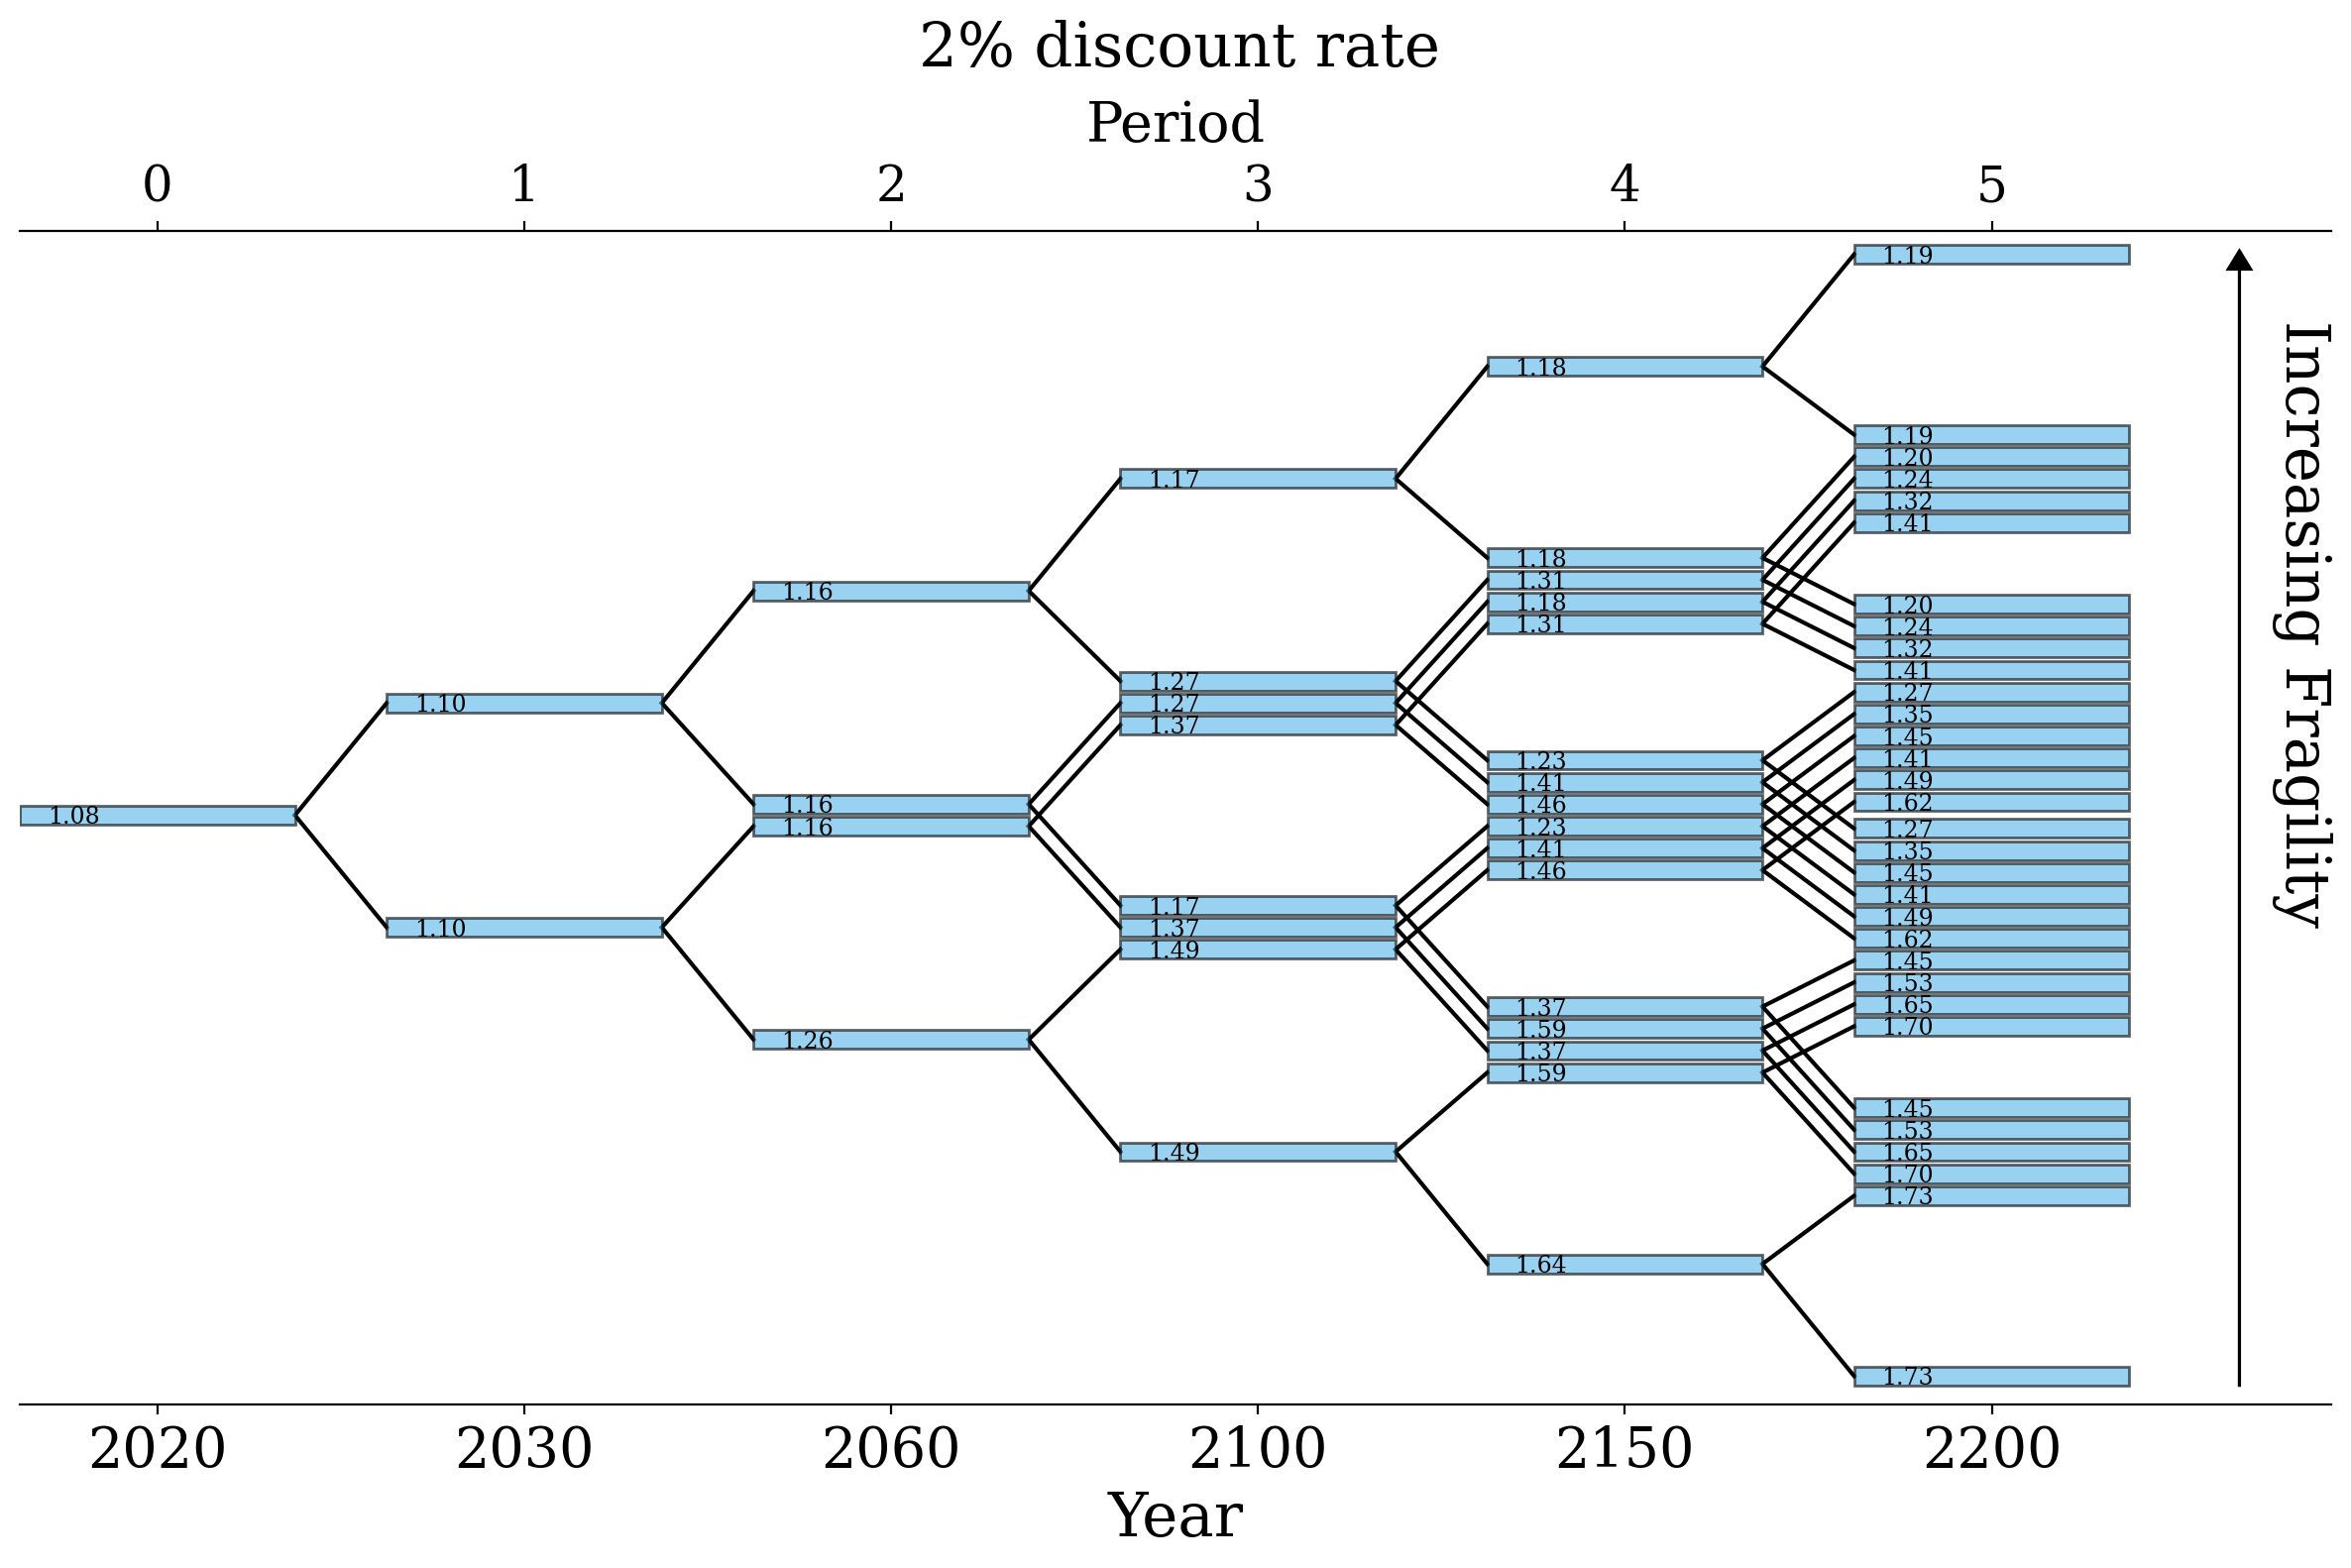

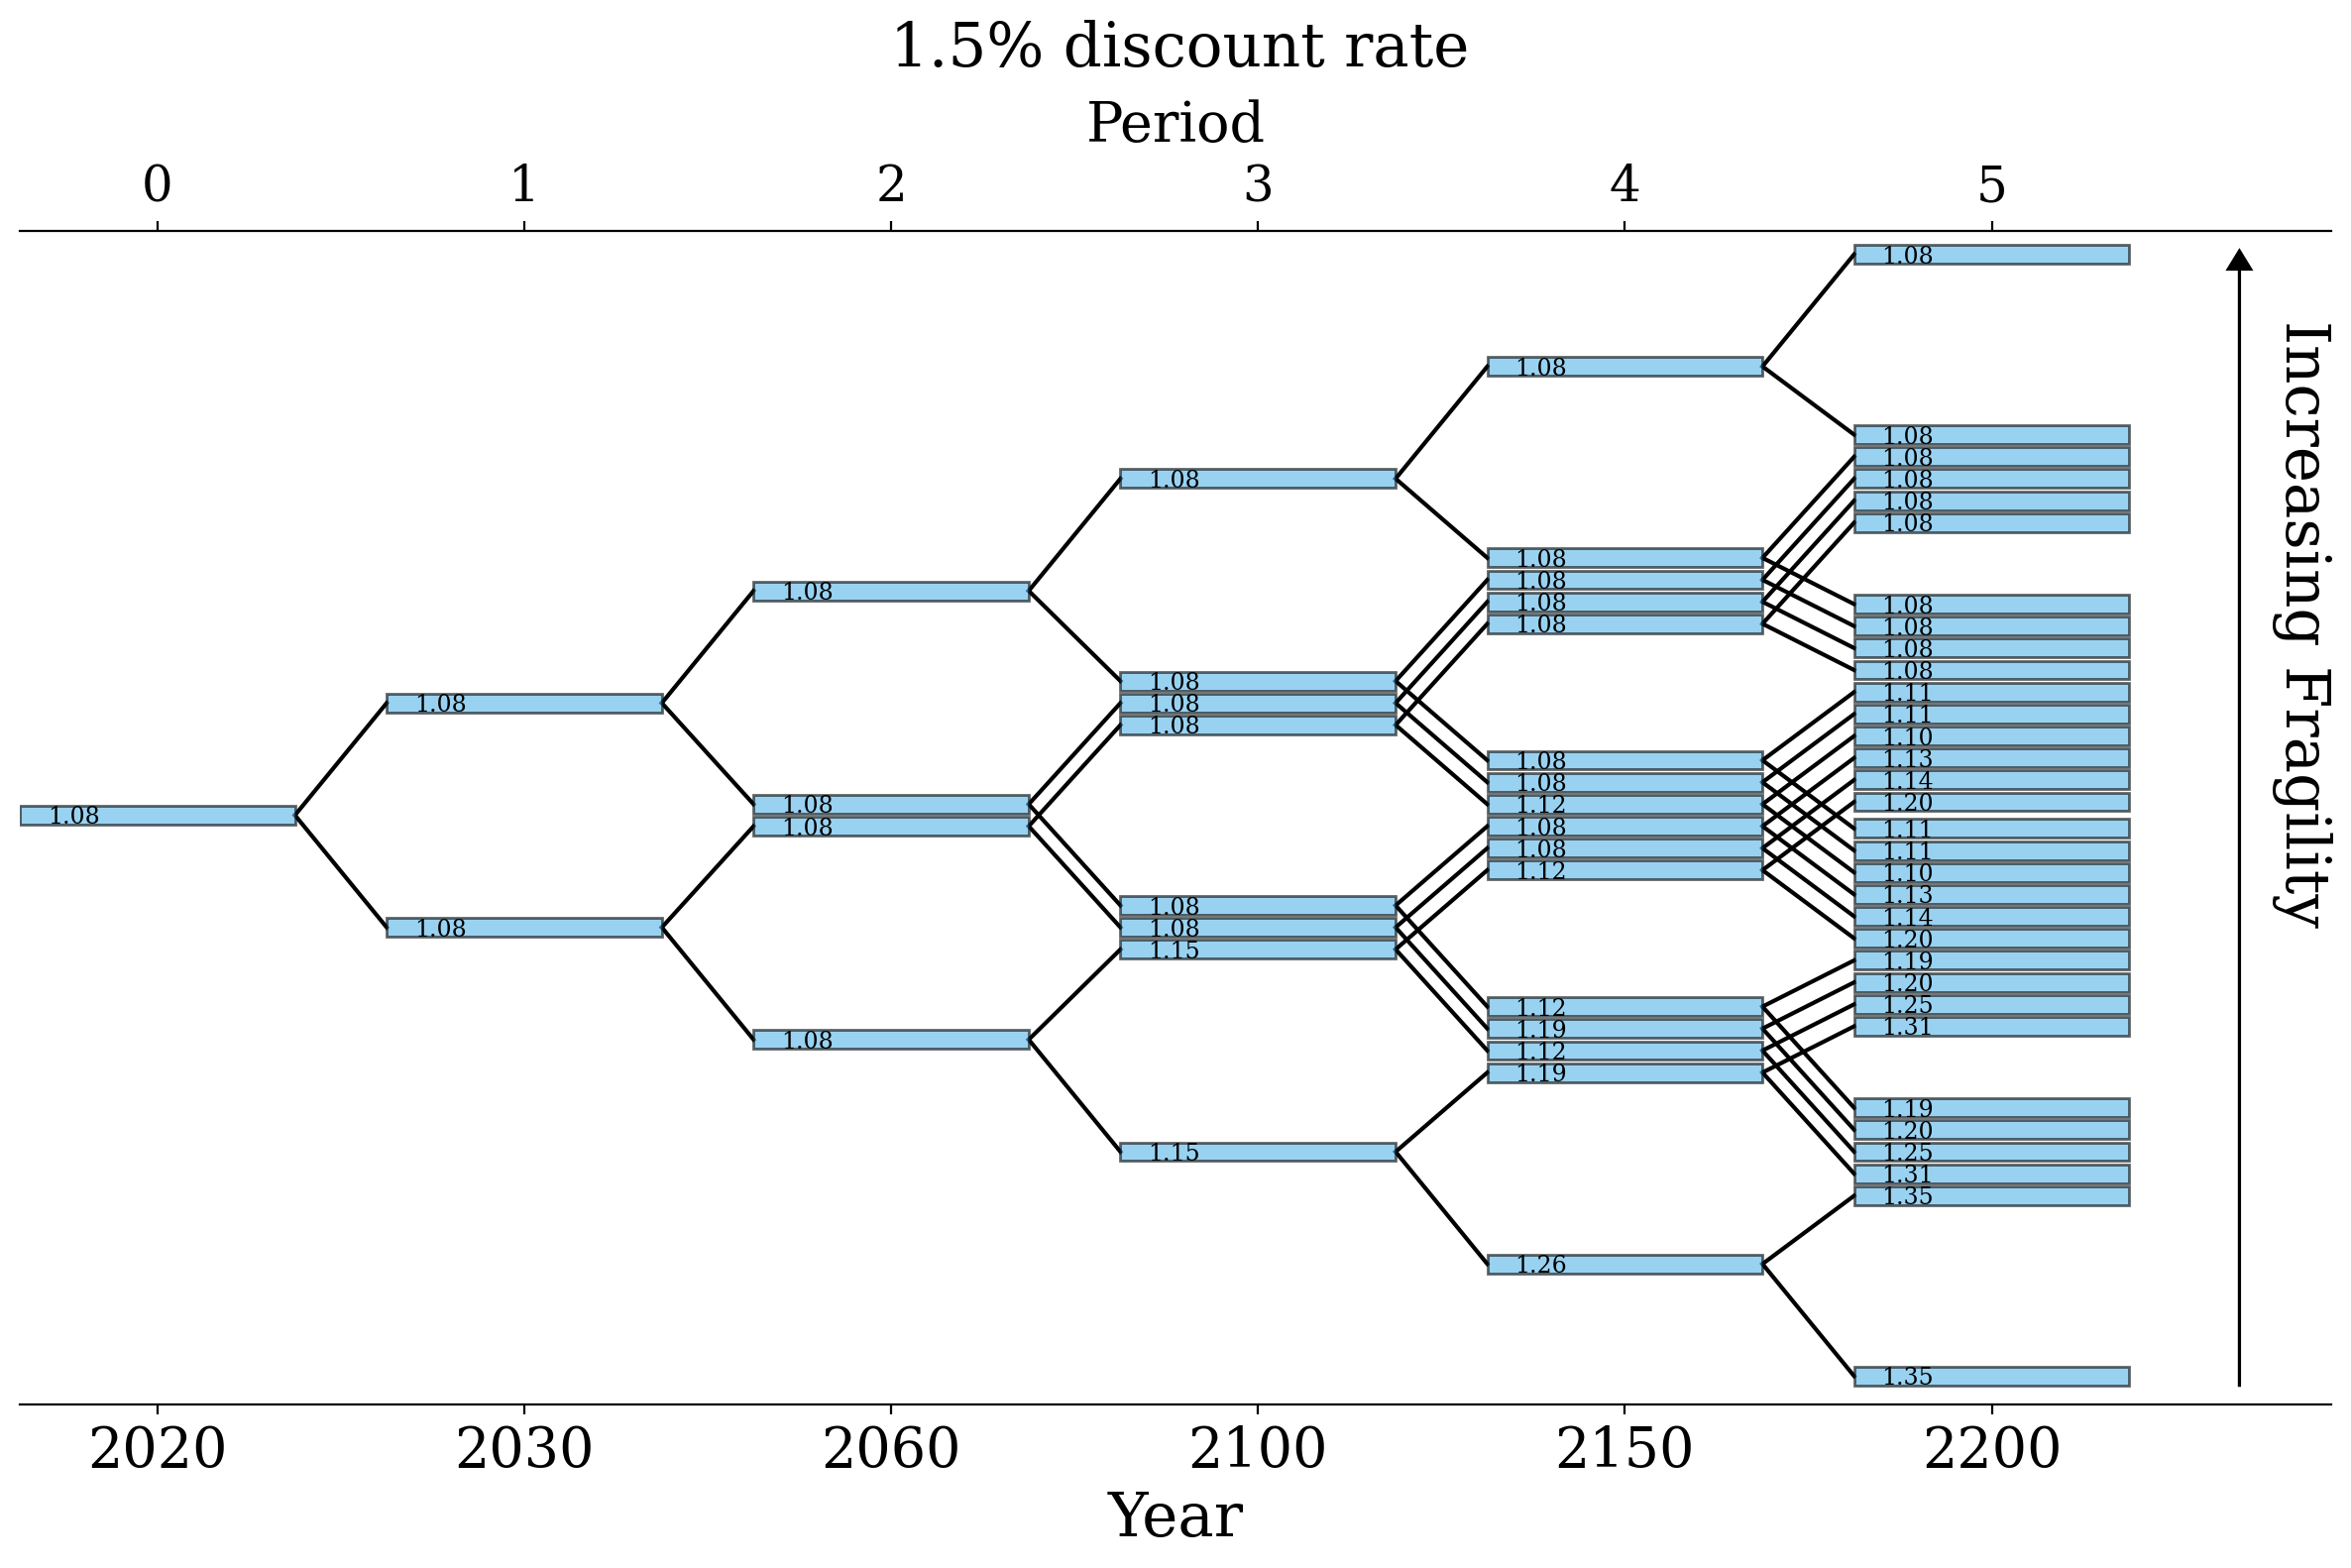

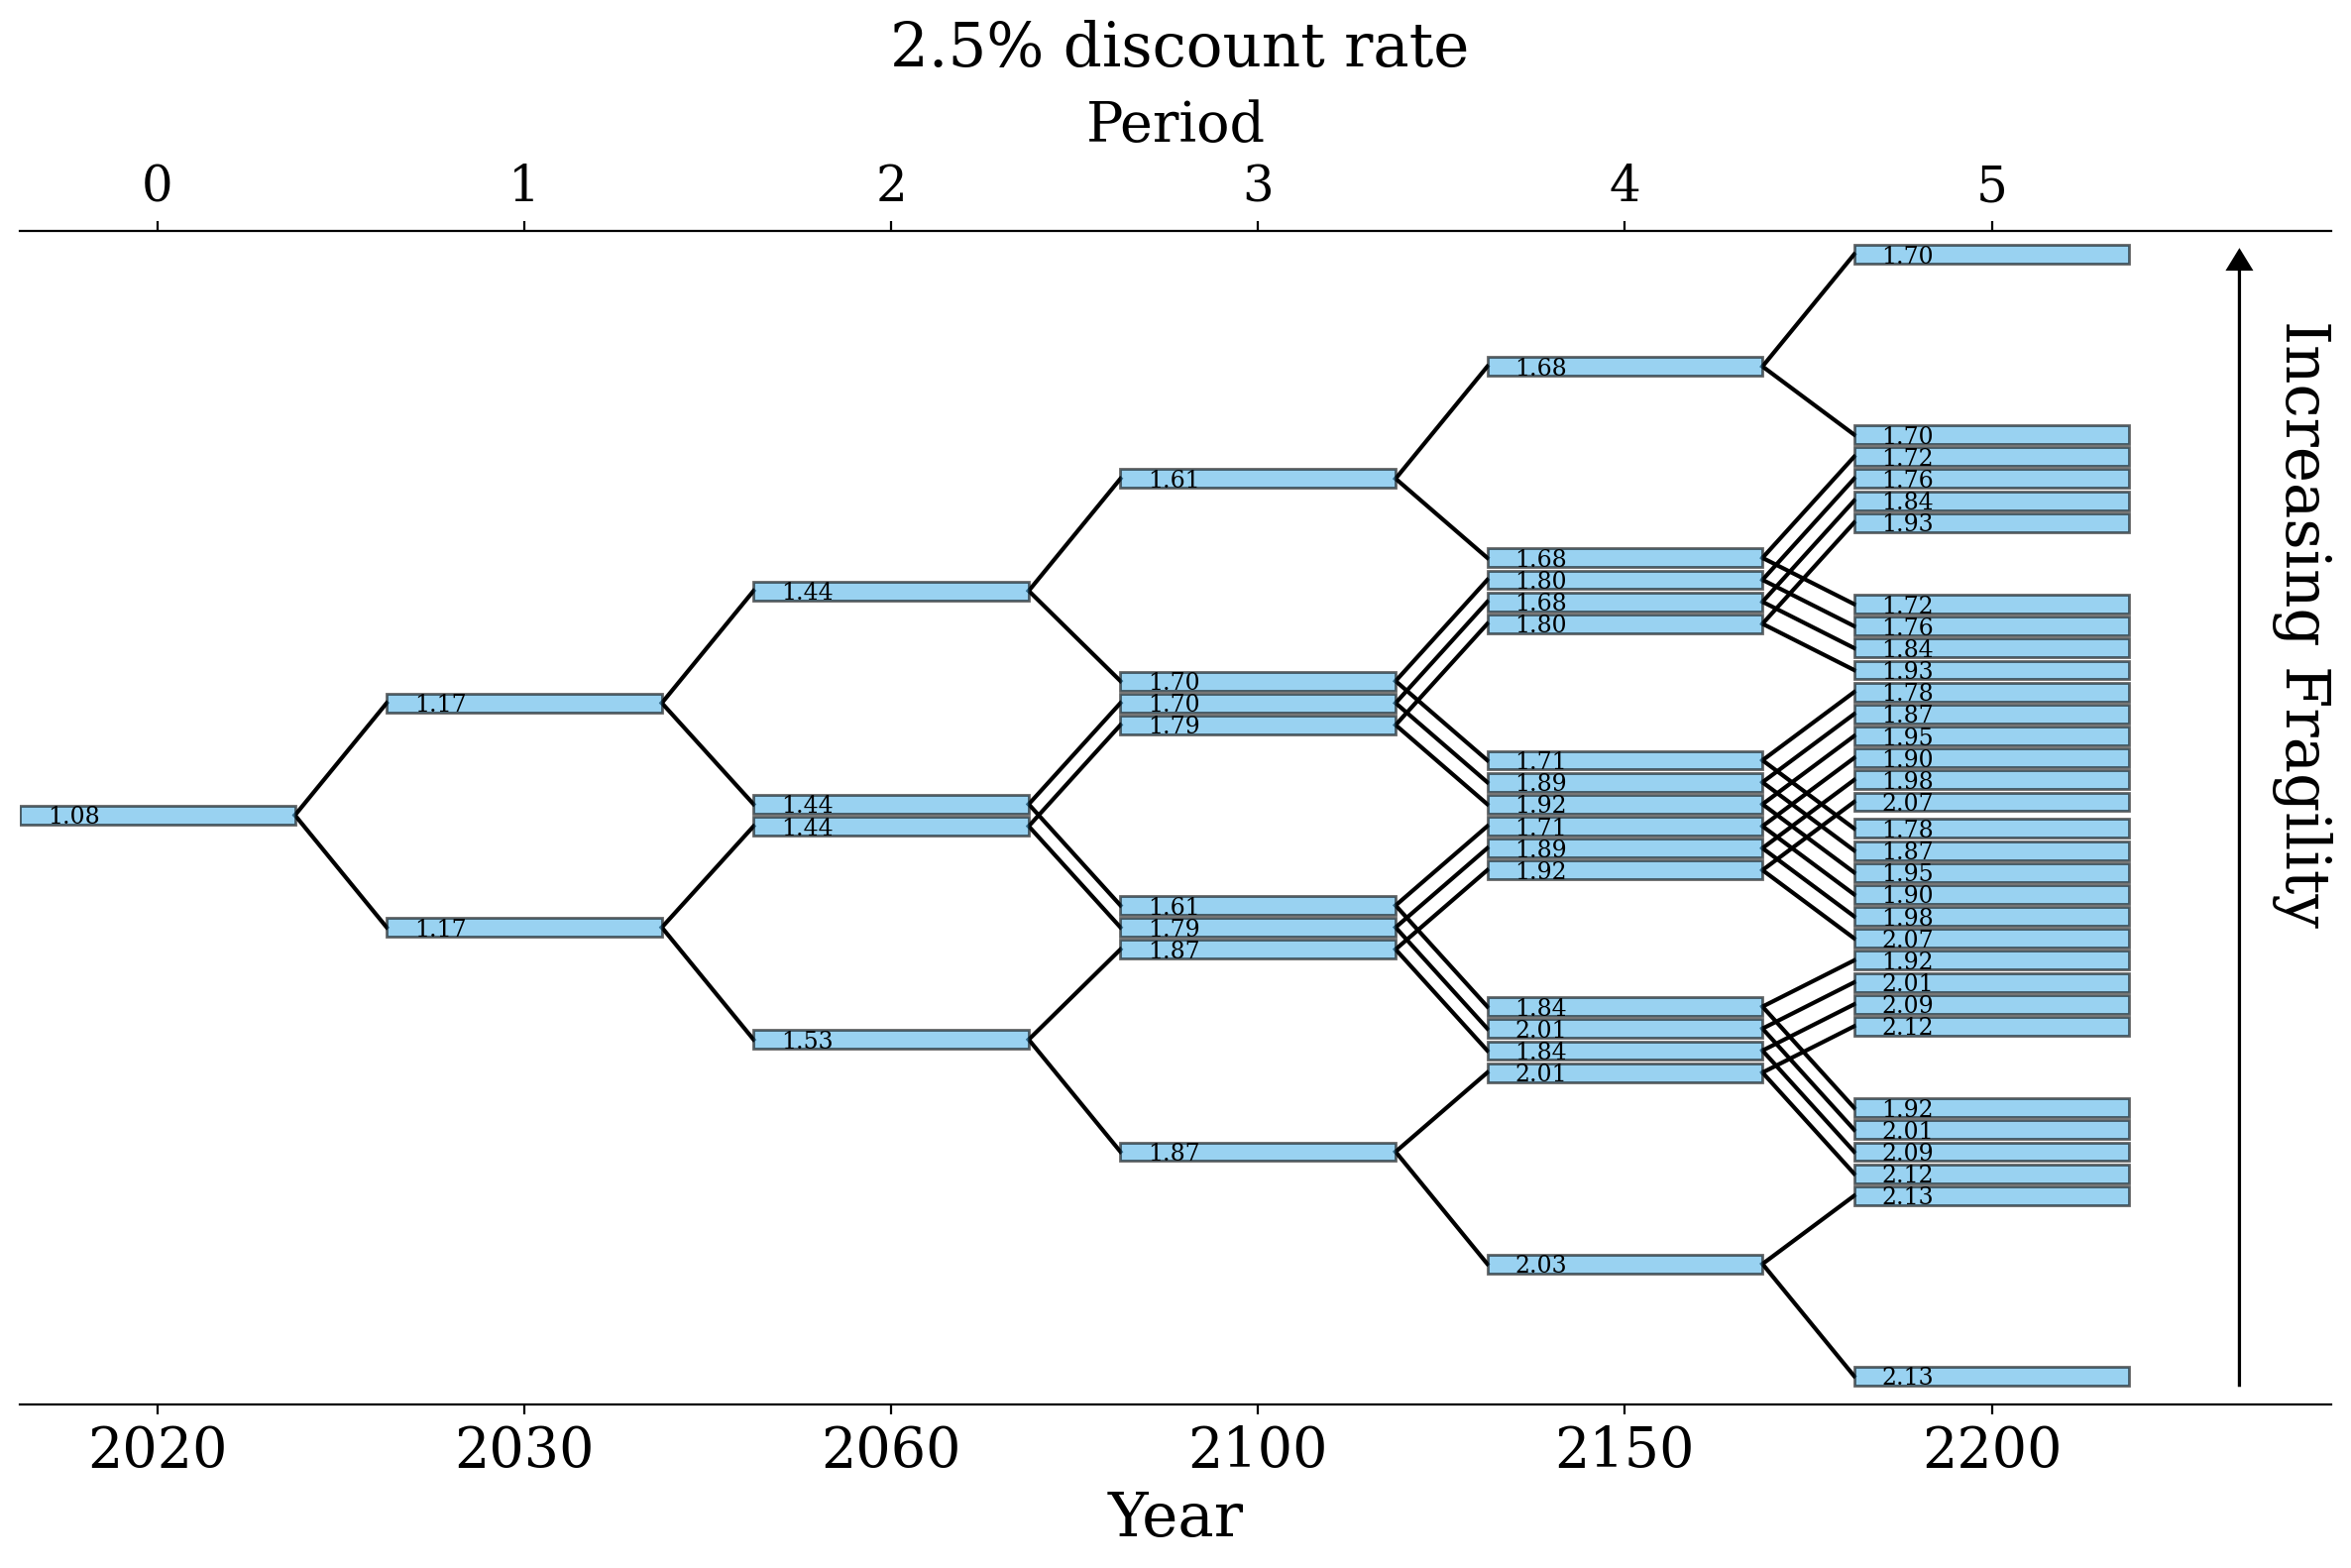

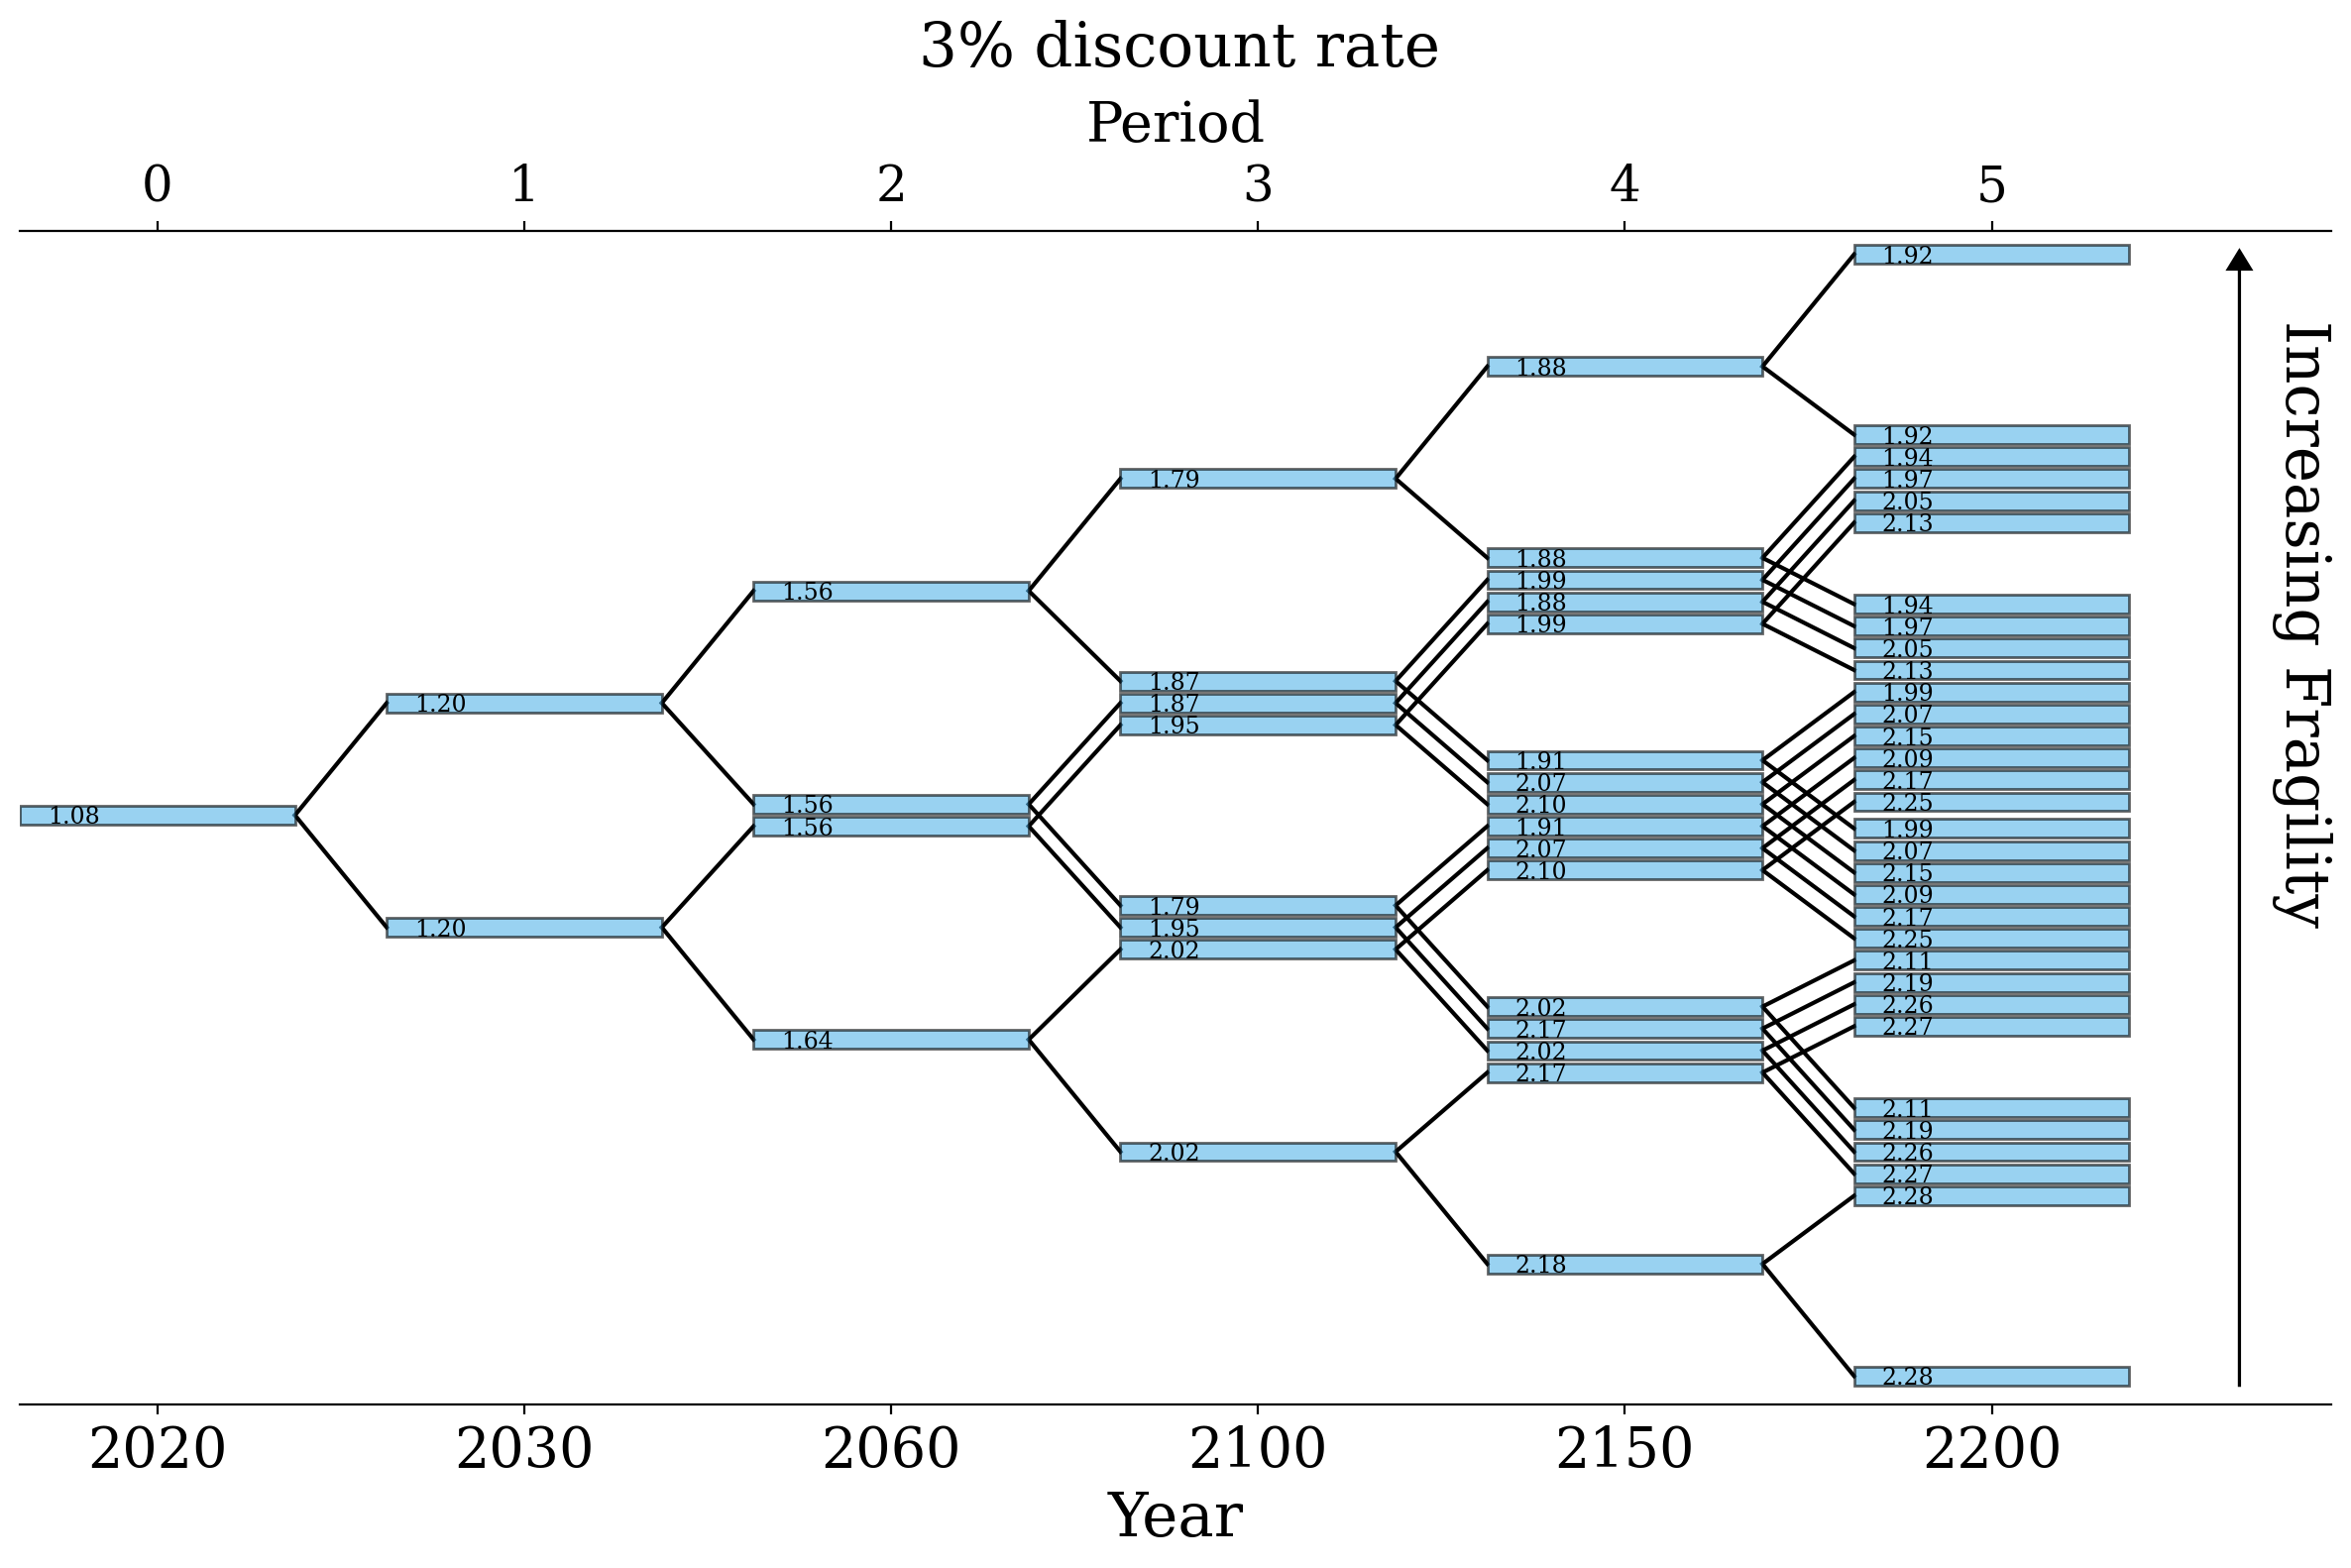

In [38]:
for file in range(0, N_files):
    tmp_Tree = TreeDiagram(6, pickle_obj_list[file].temp_path, True, descriptions[file], save_fig=save_fig)
    tmp_Tree.makePlot()

### Prices

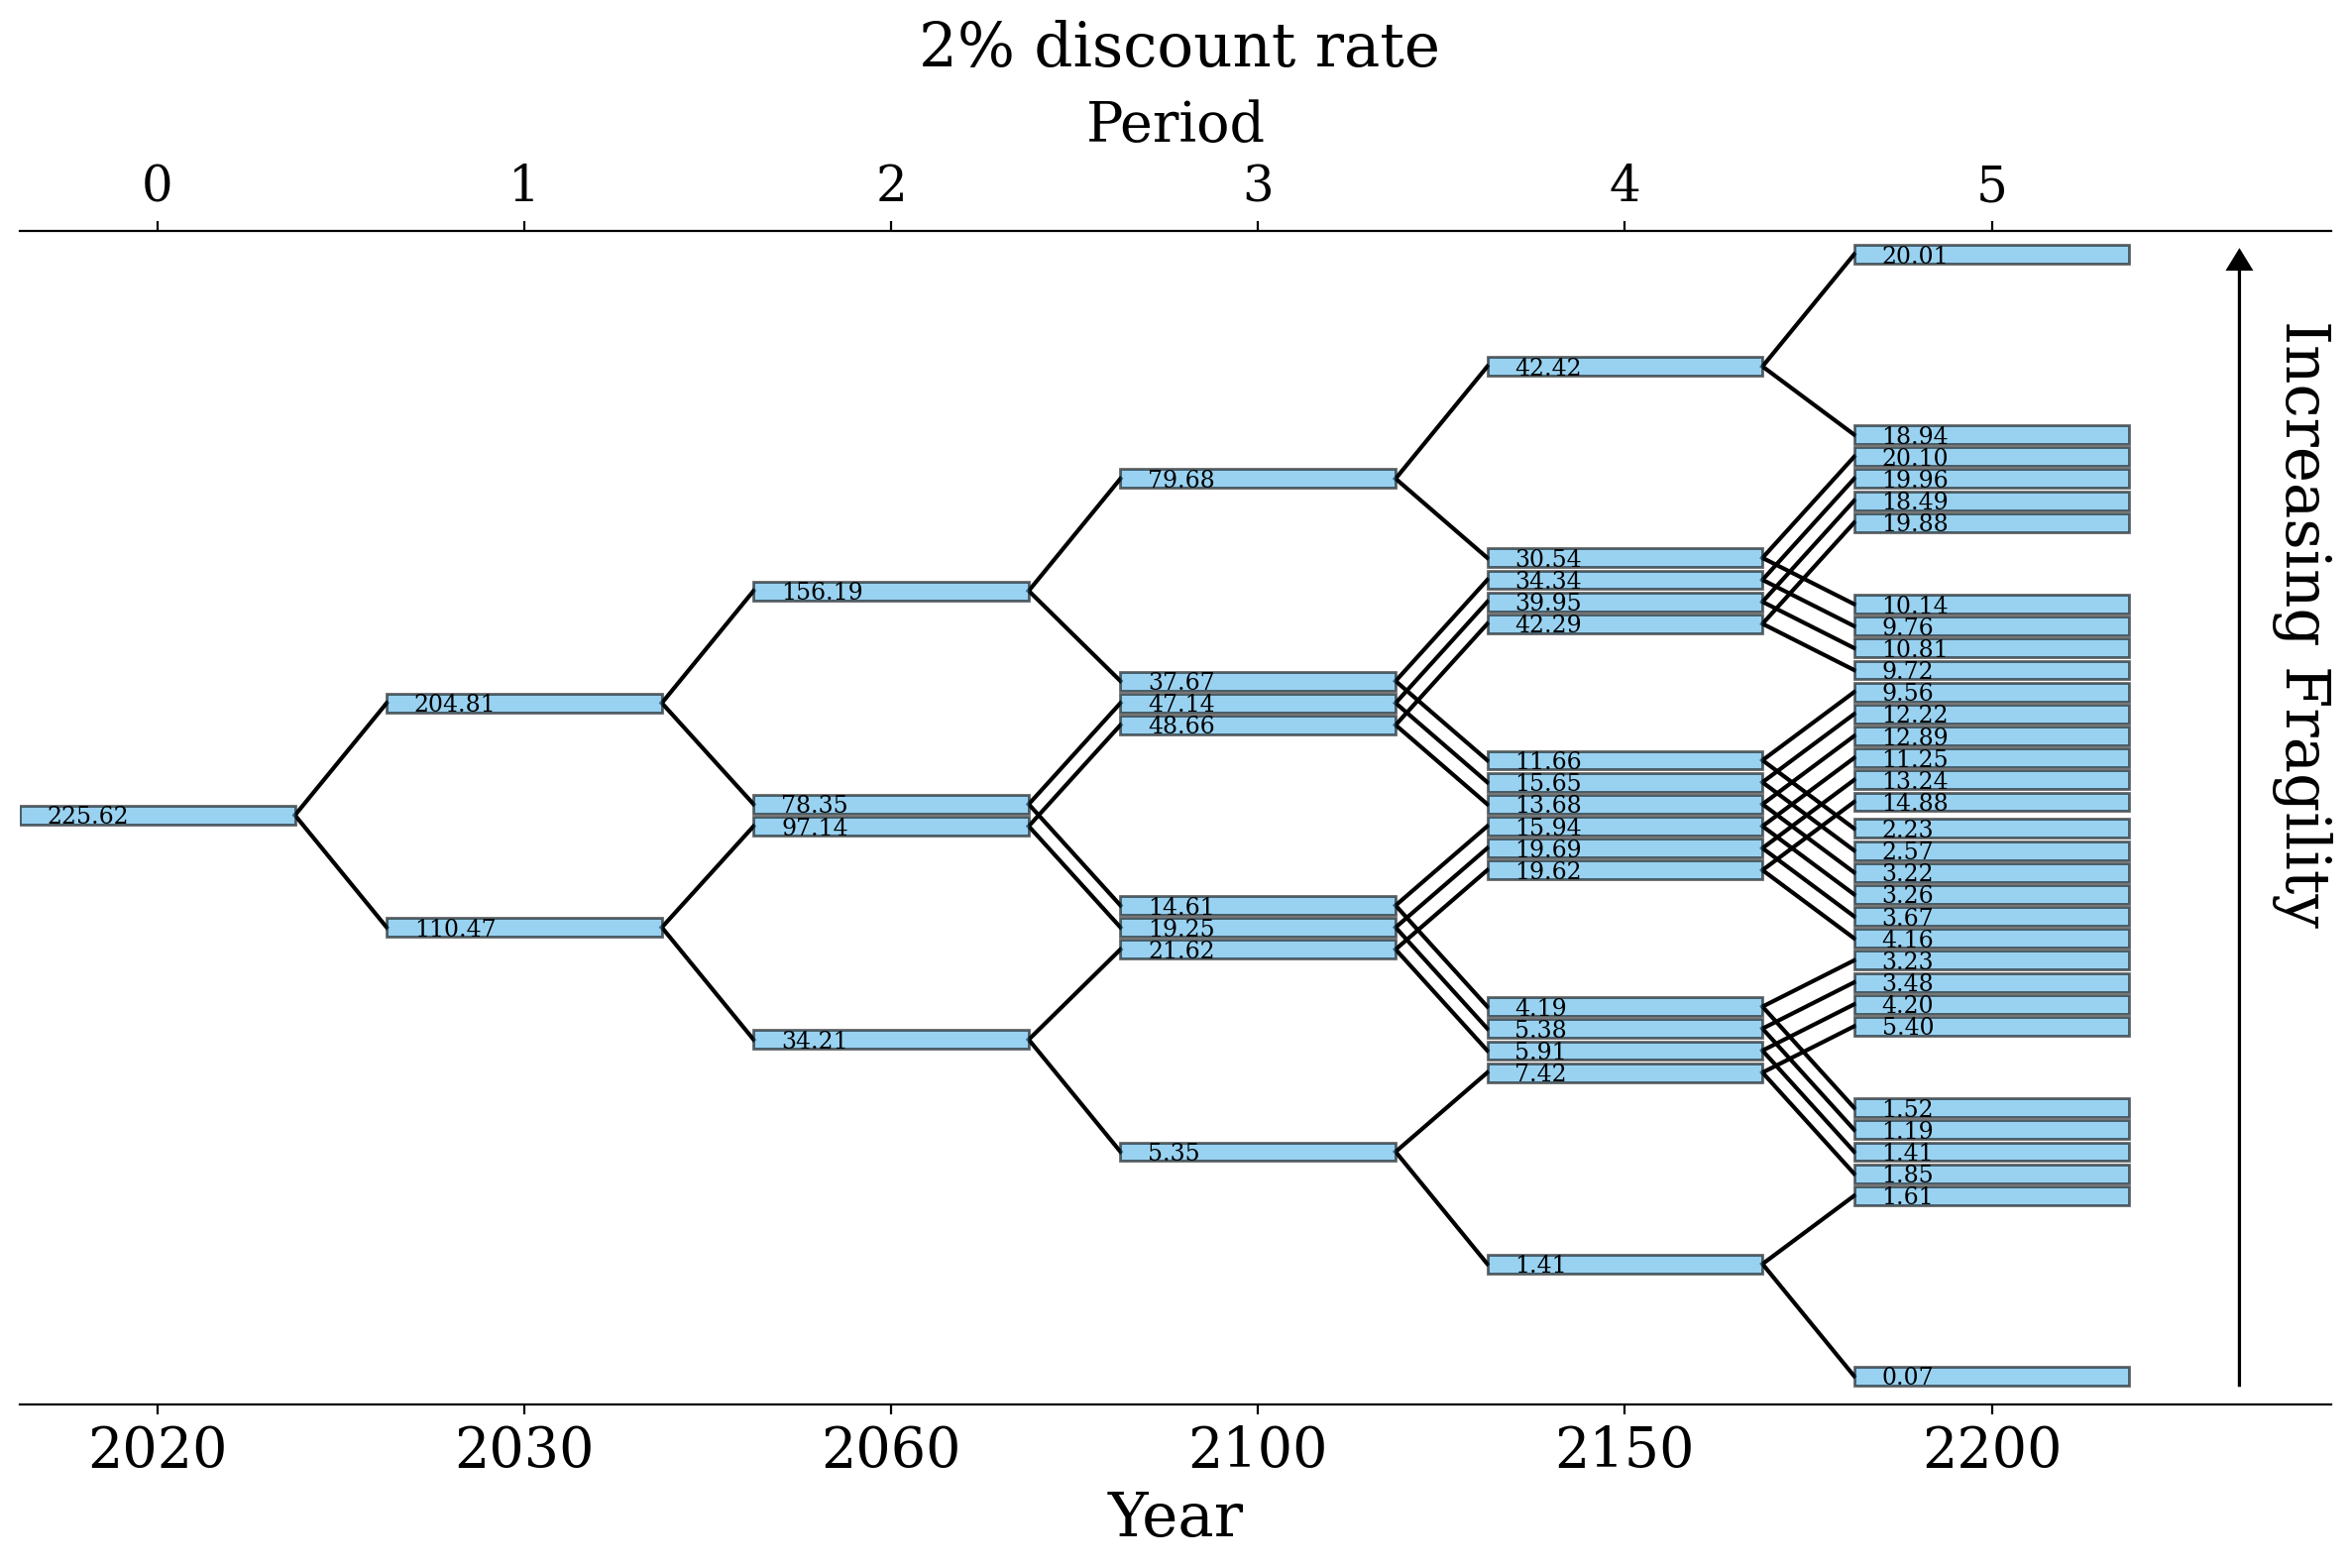

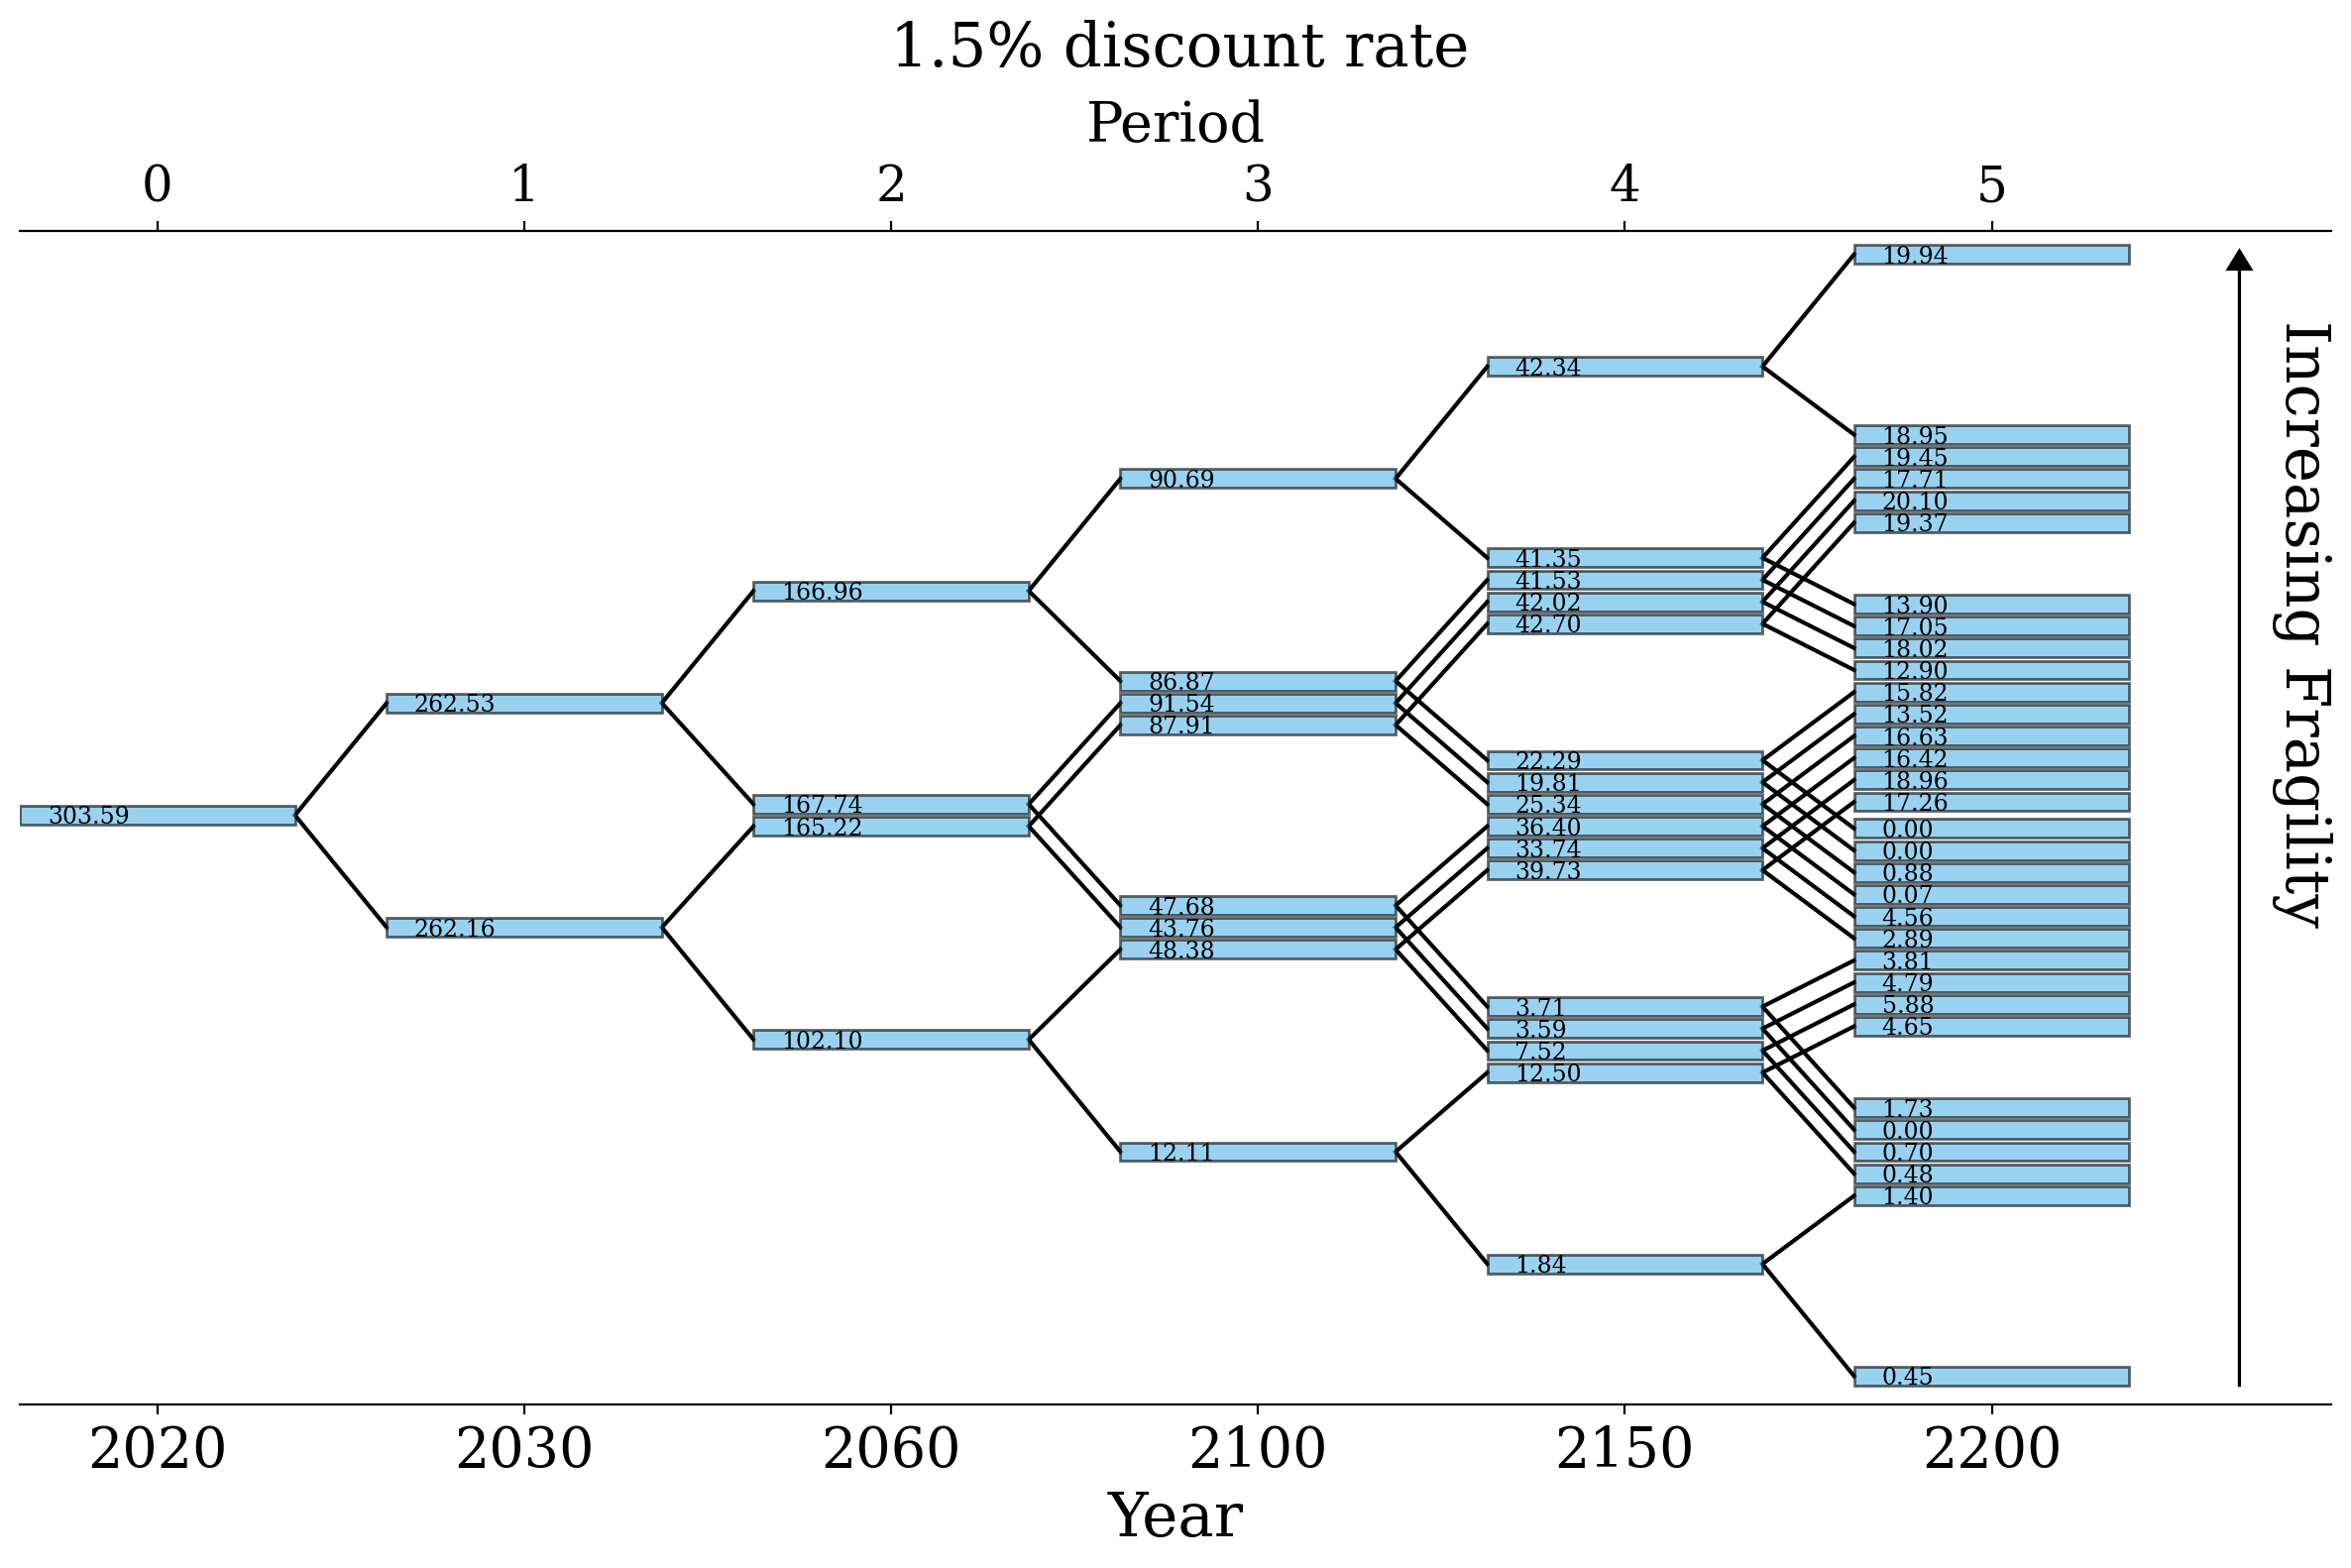

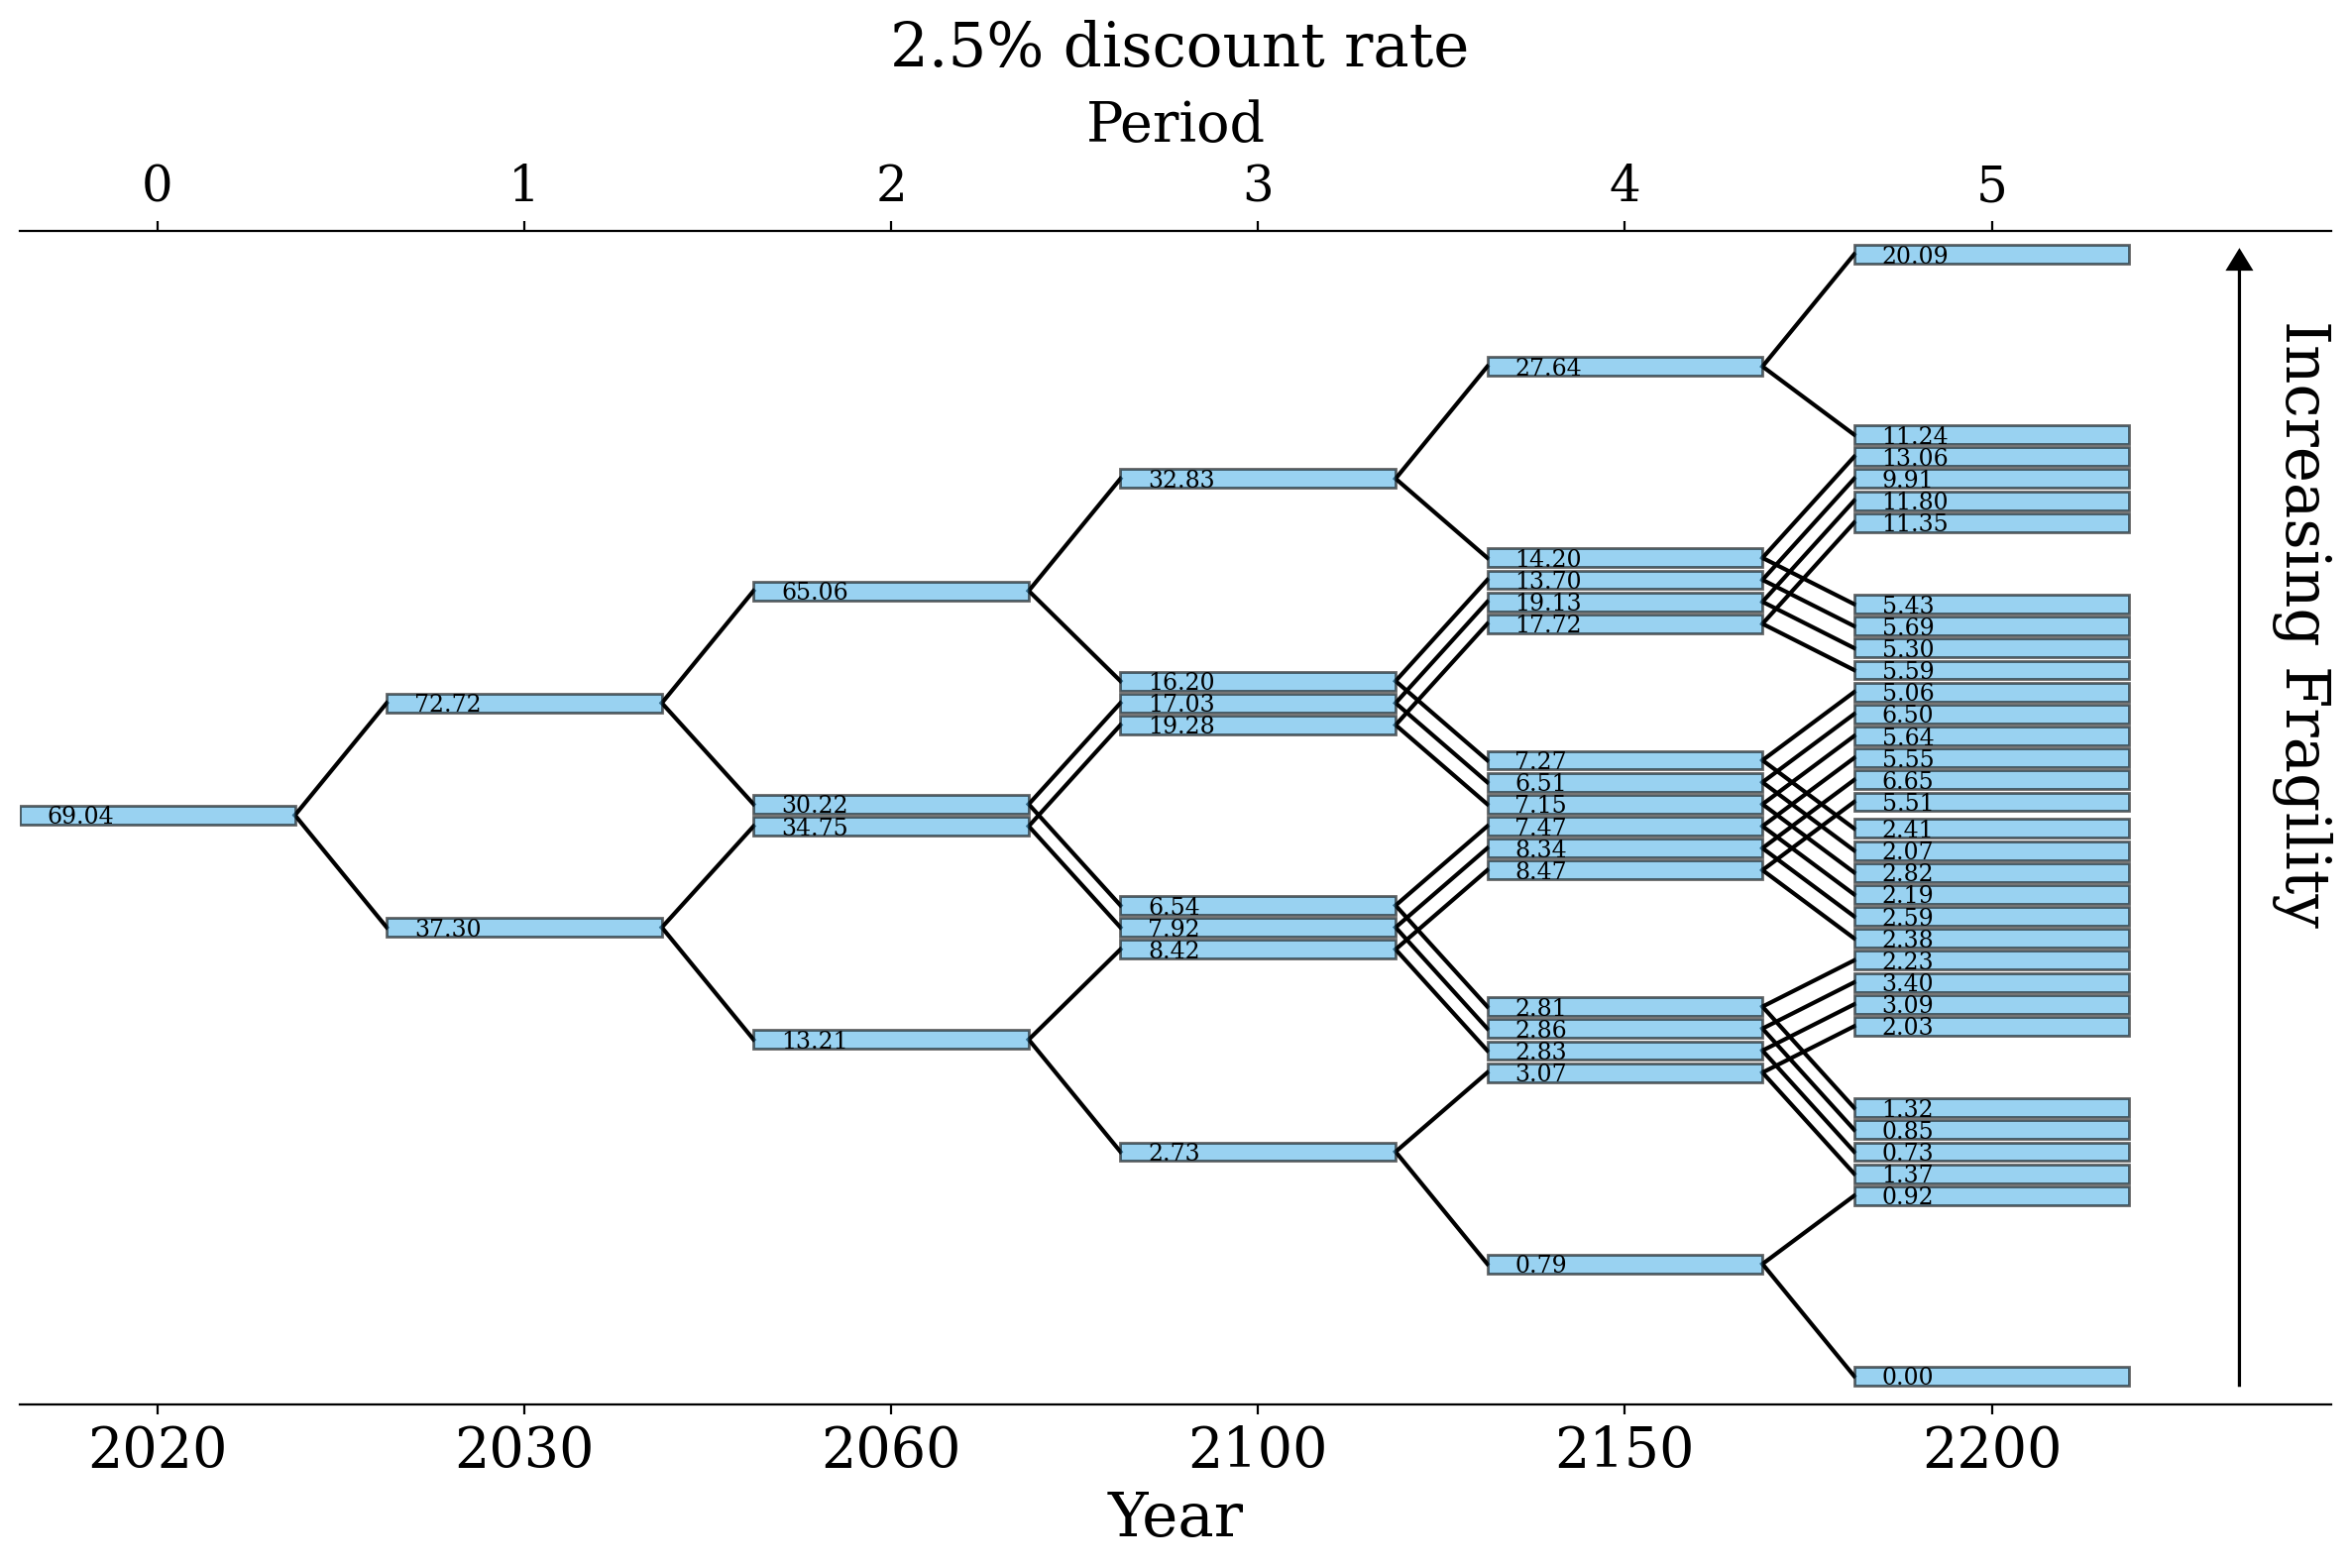

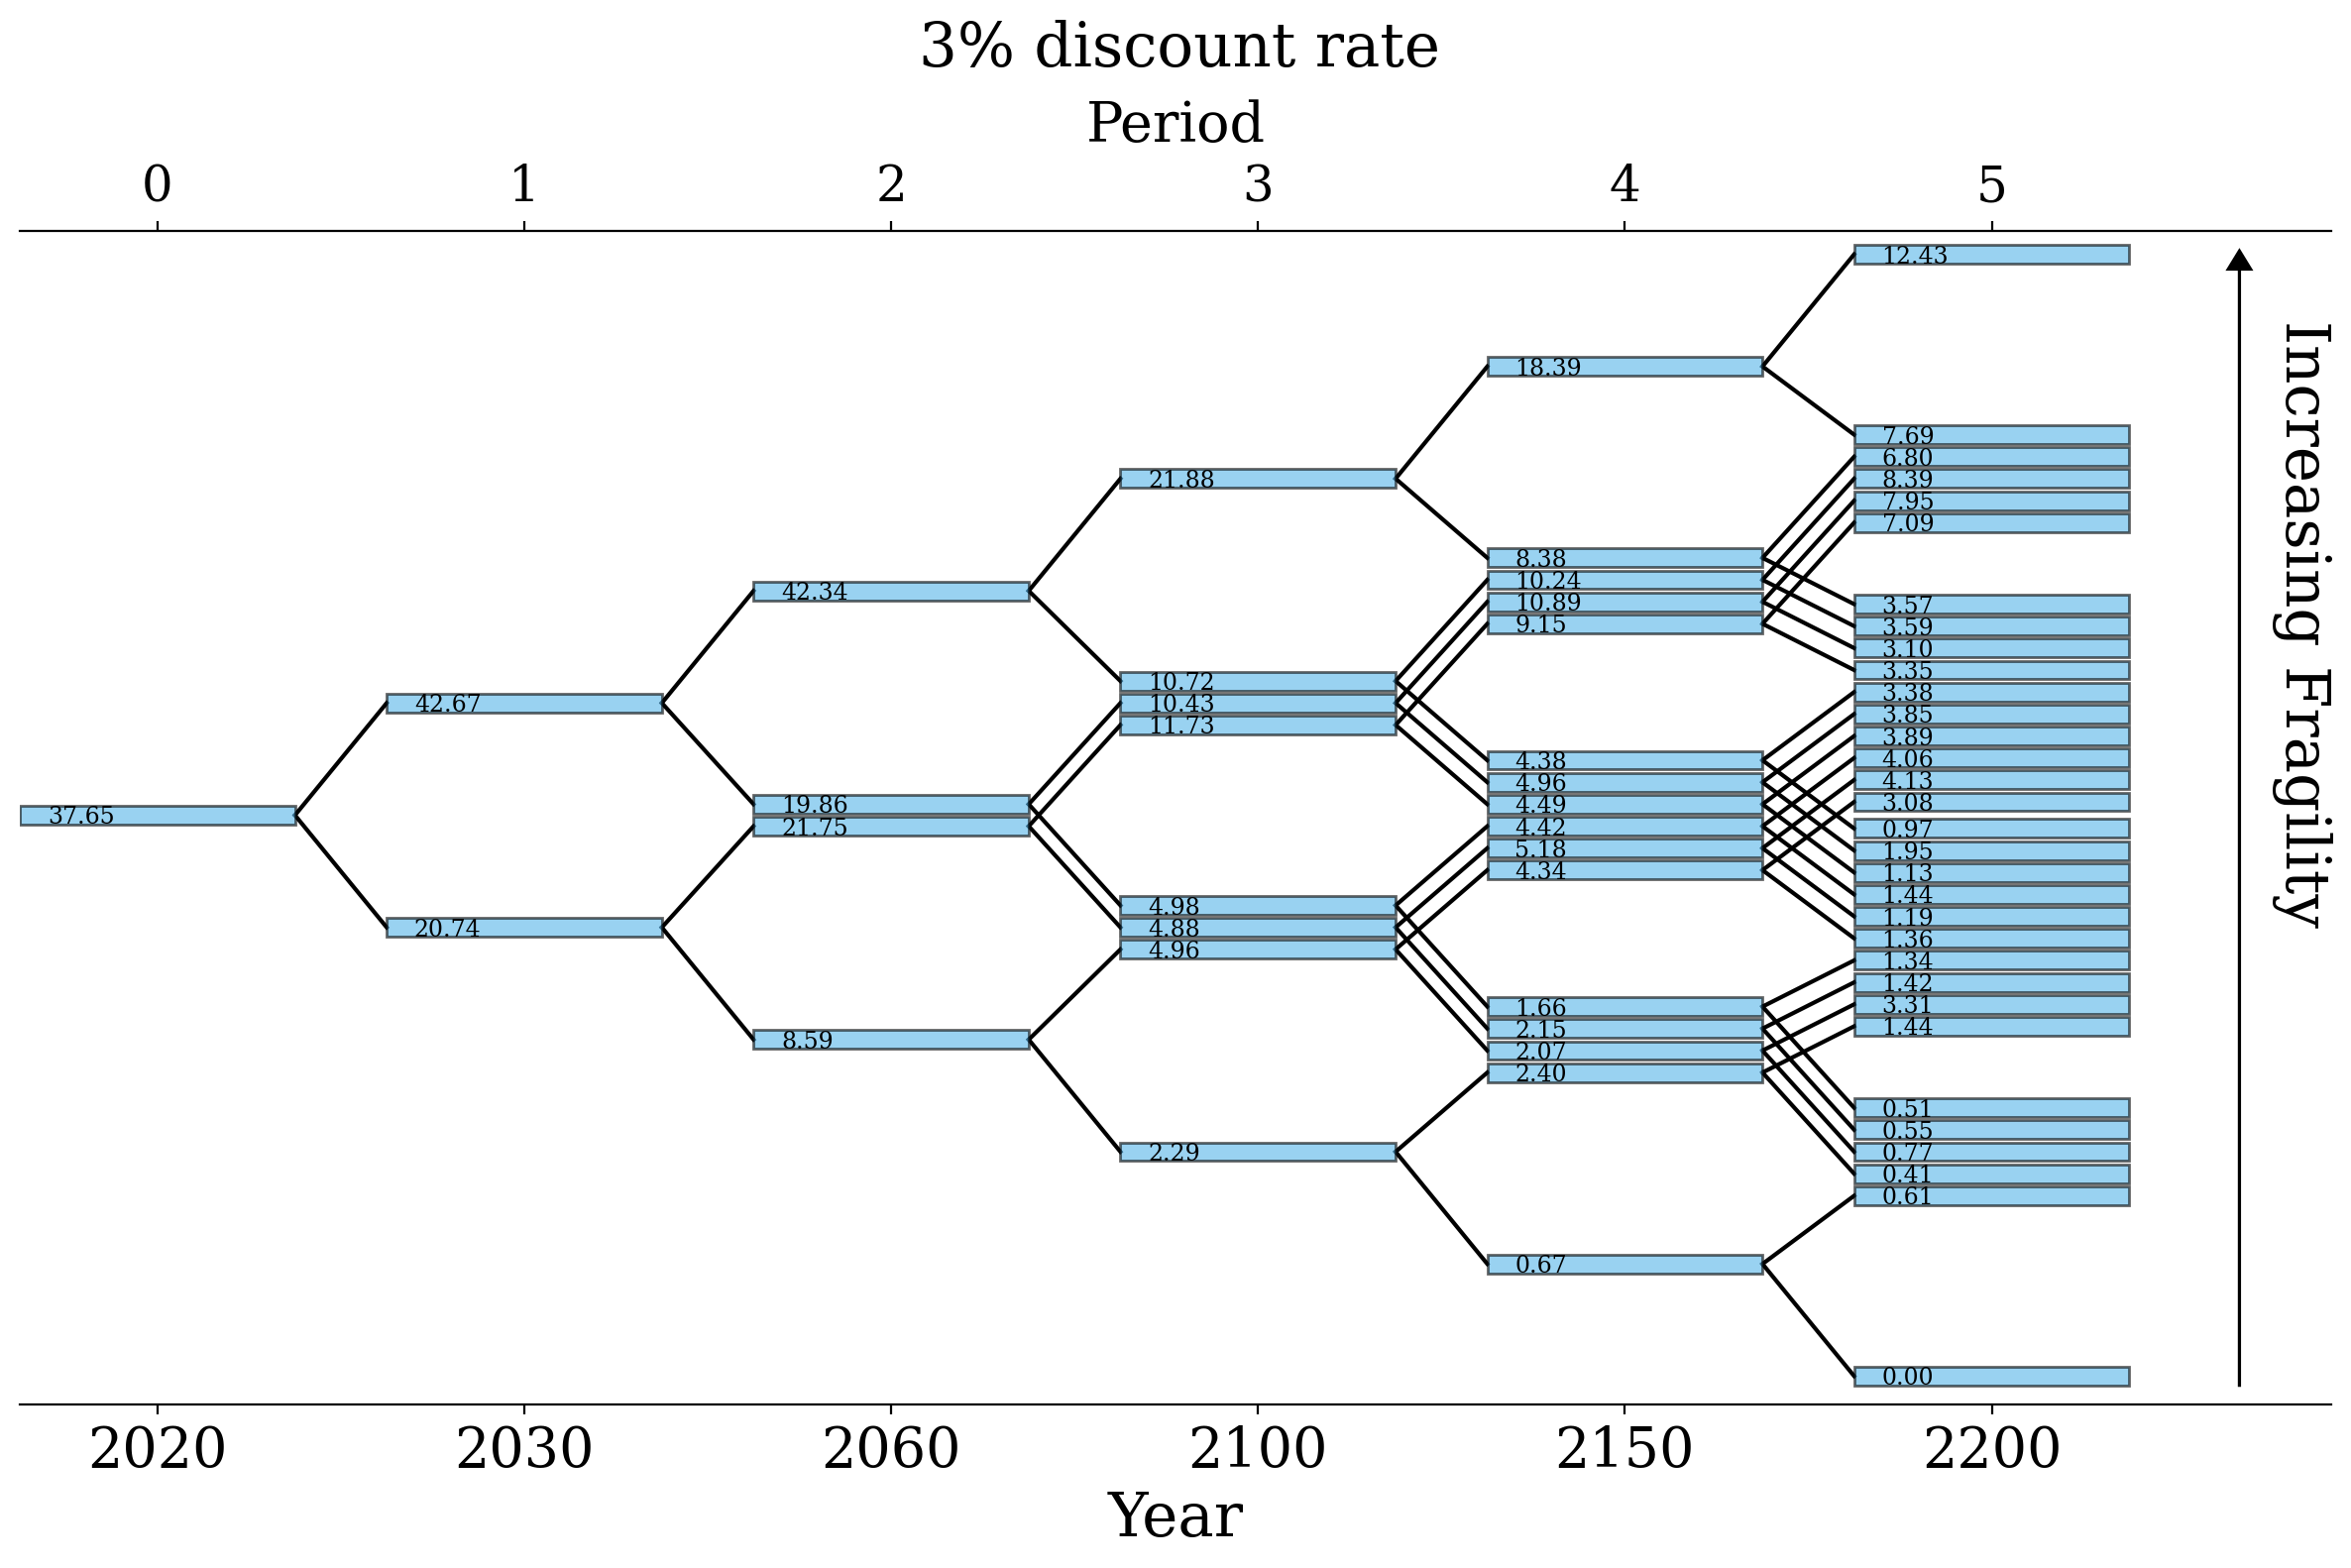

In [39]:
for file in range(0, N_files):
    tmp_Tree = TreeDiagram(6, output_obj_list[file].price_node, False, descriptions[file], save_fig=save_fig)
    tmp_Tree.makePlot()

### Concentrations 

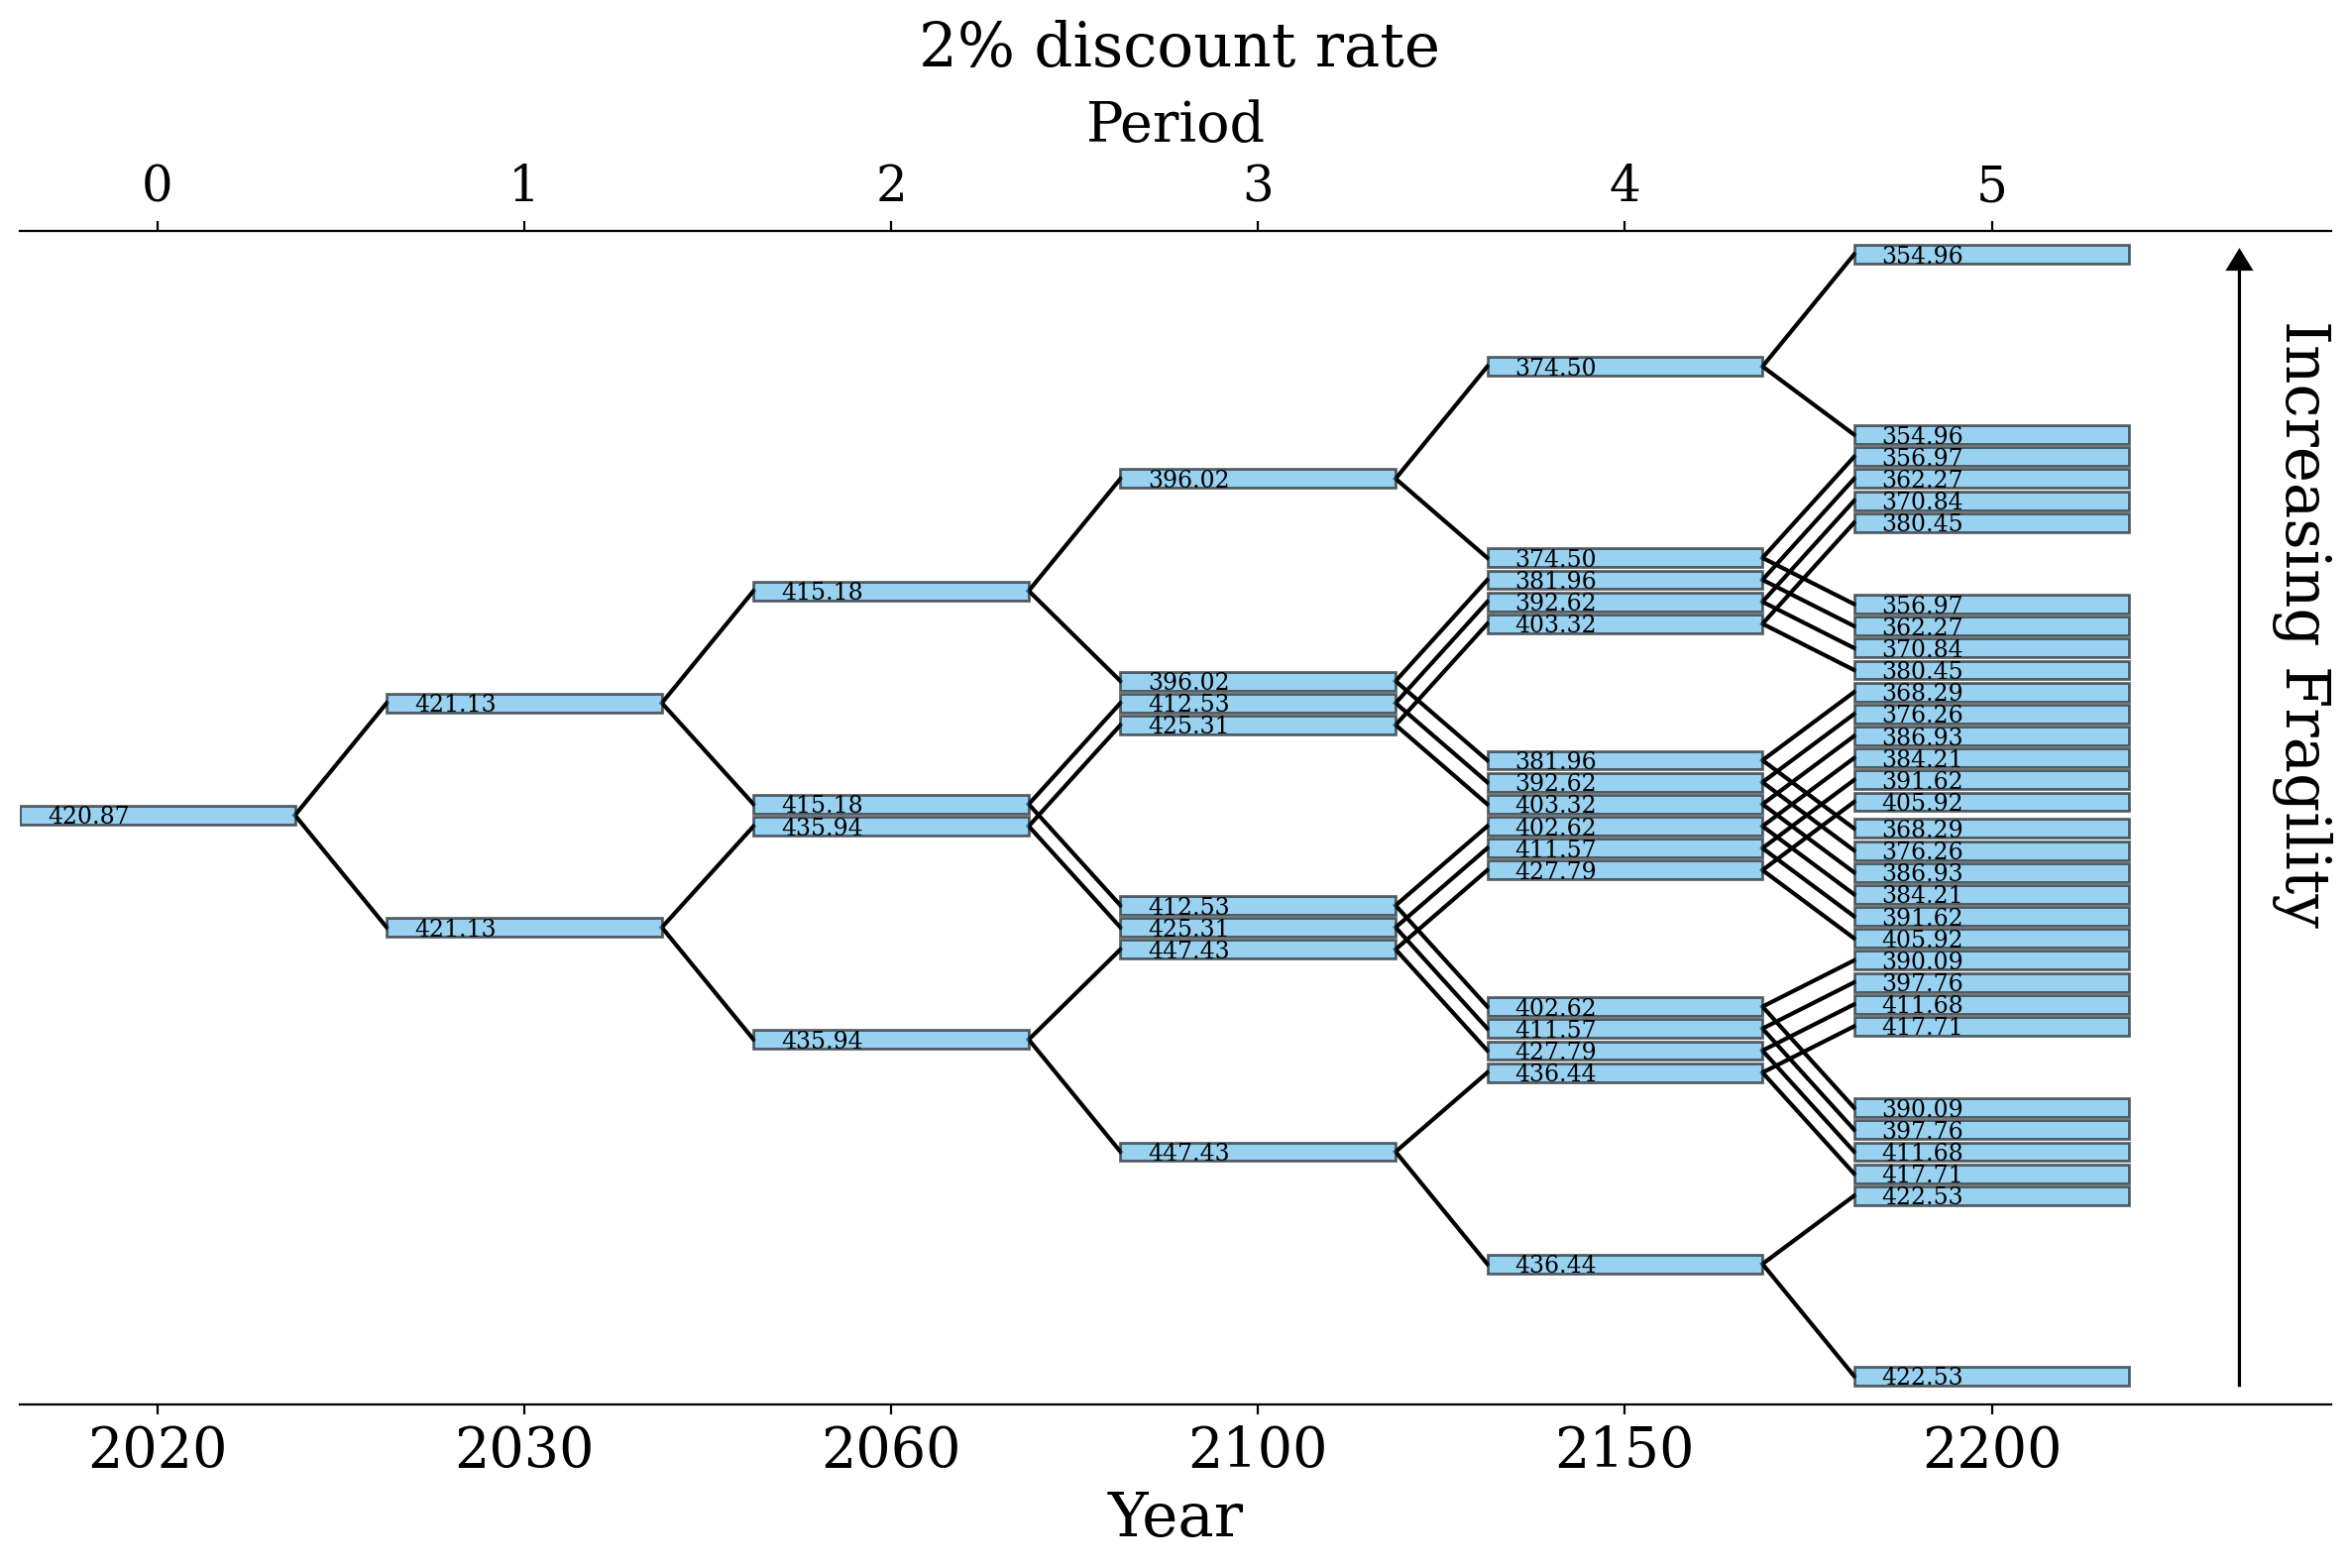

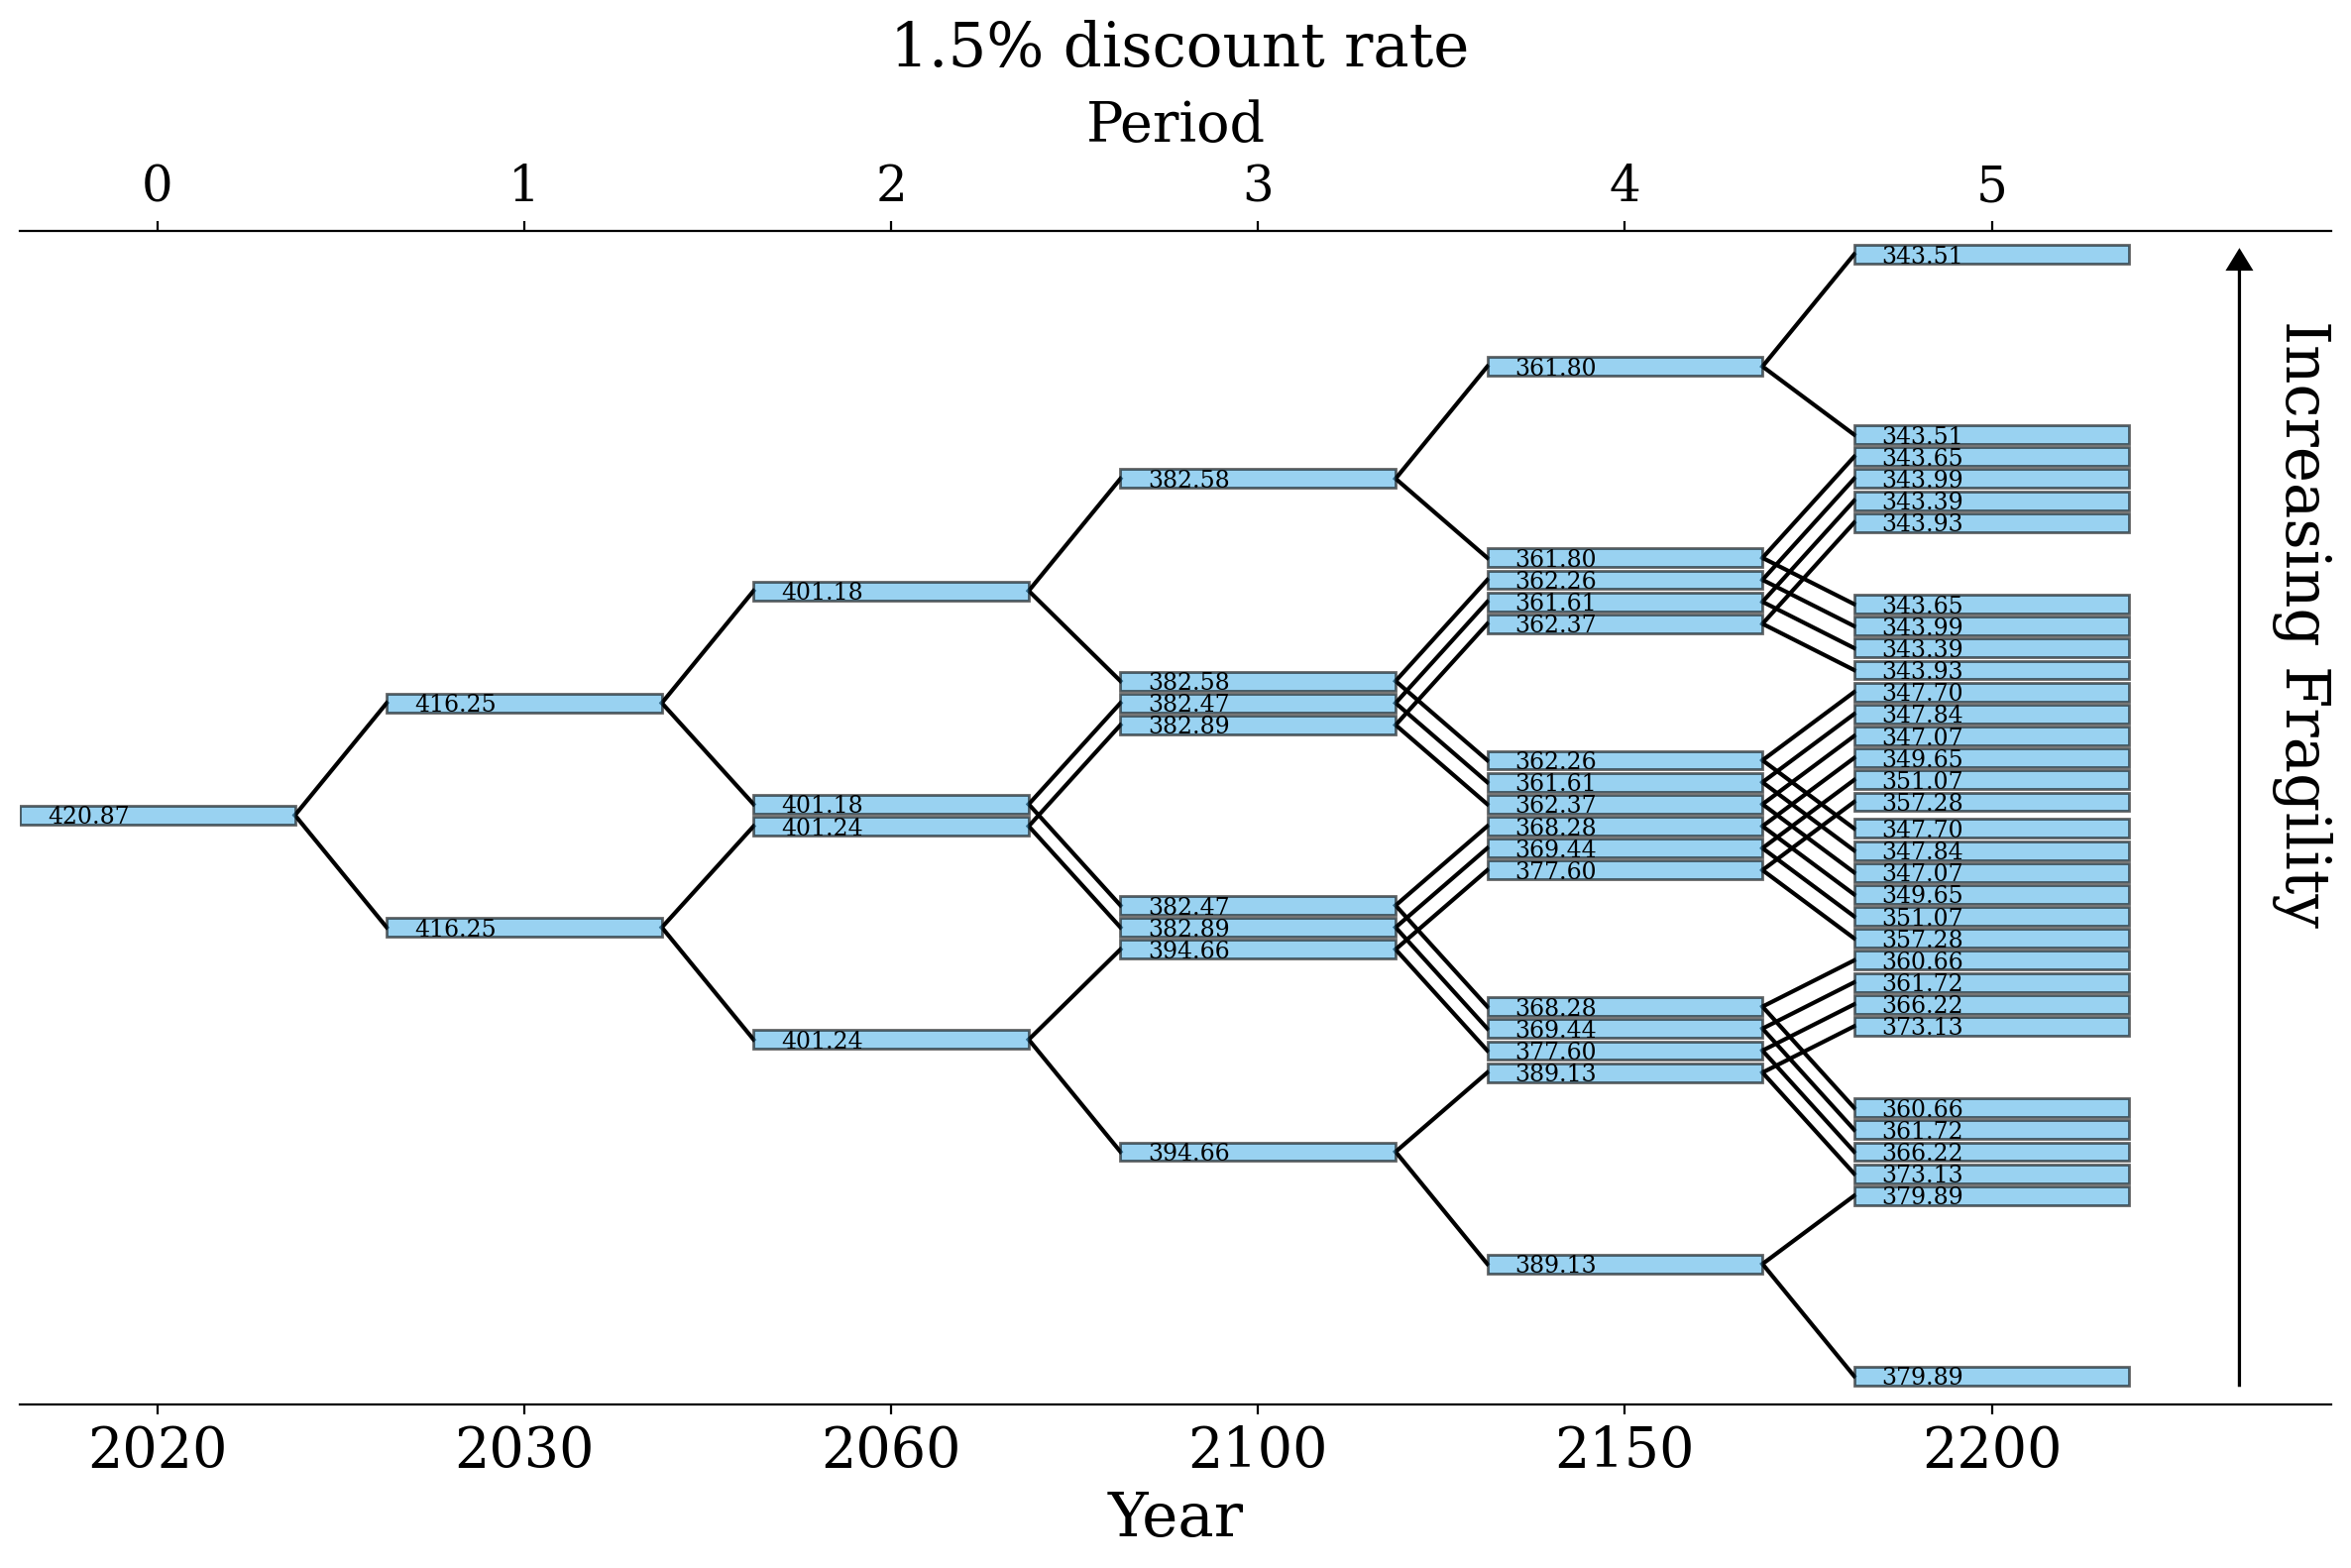

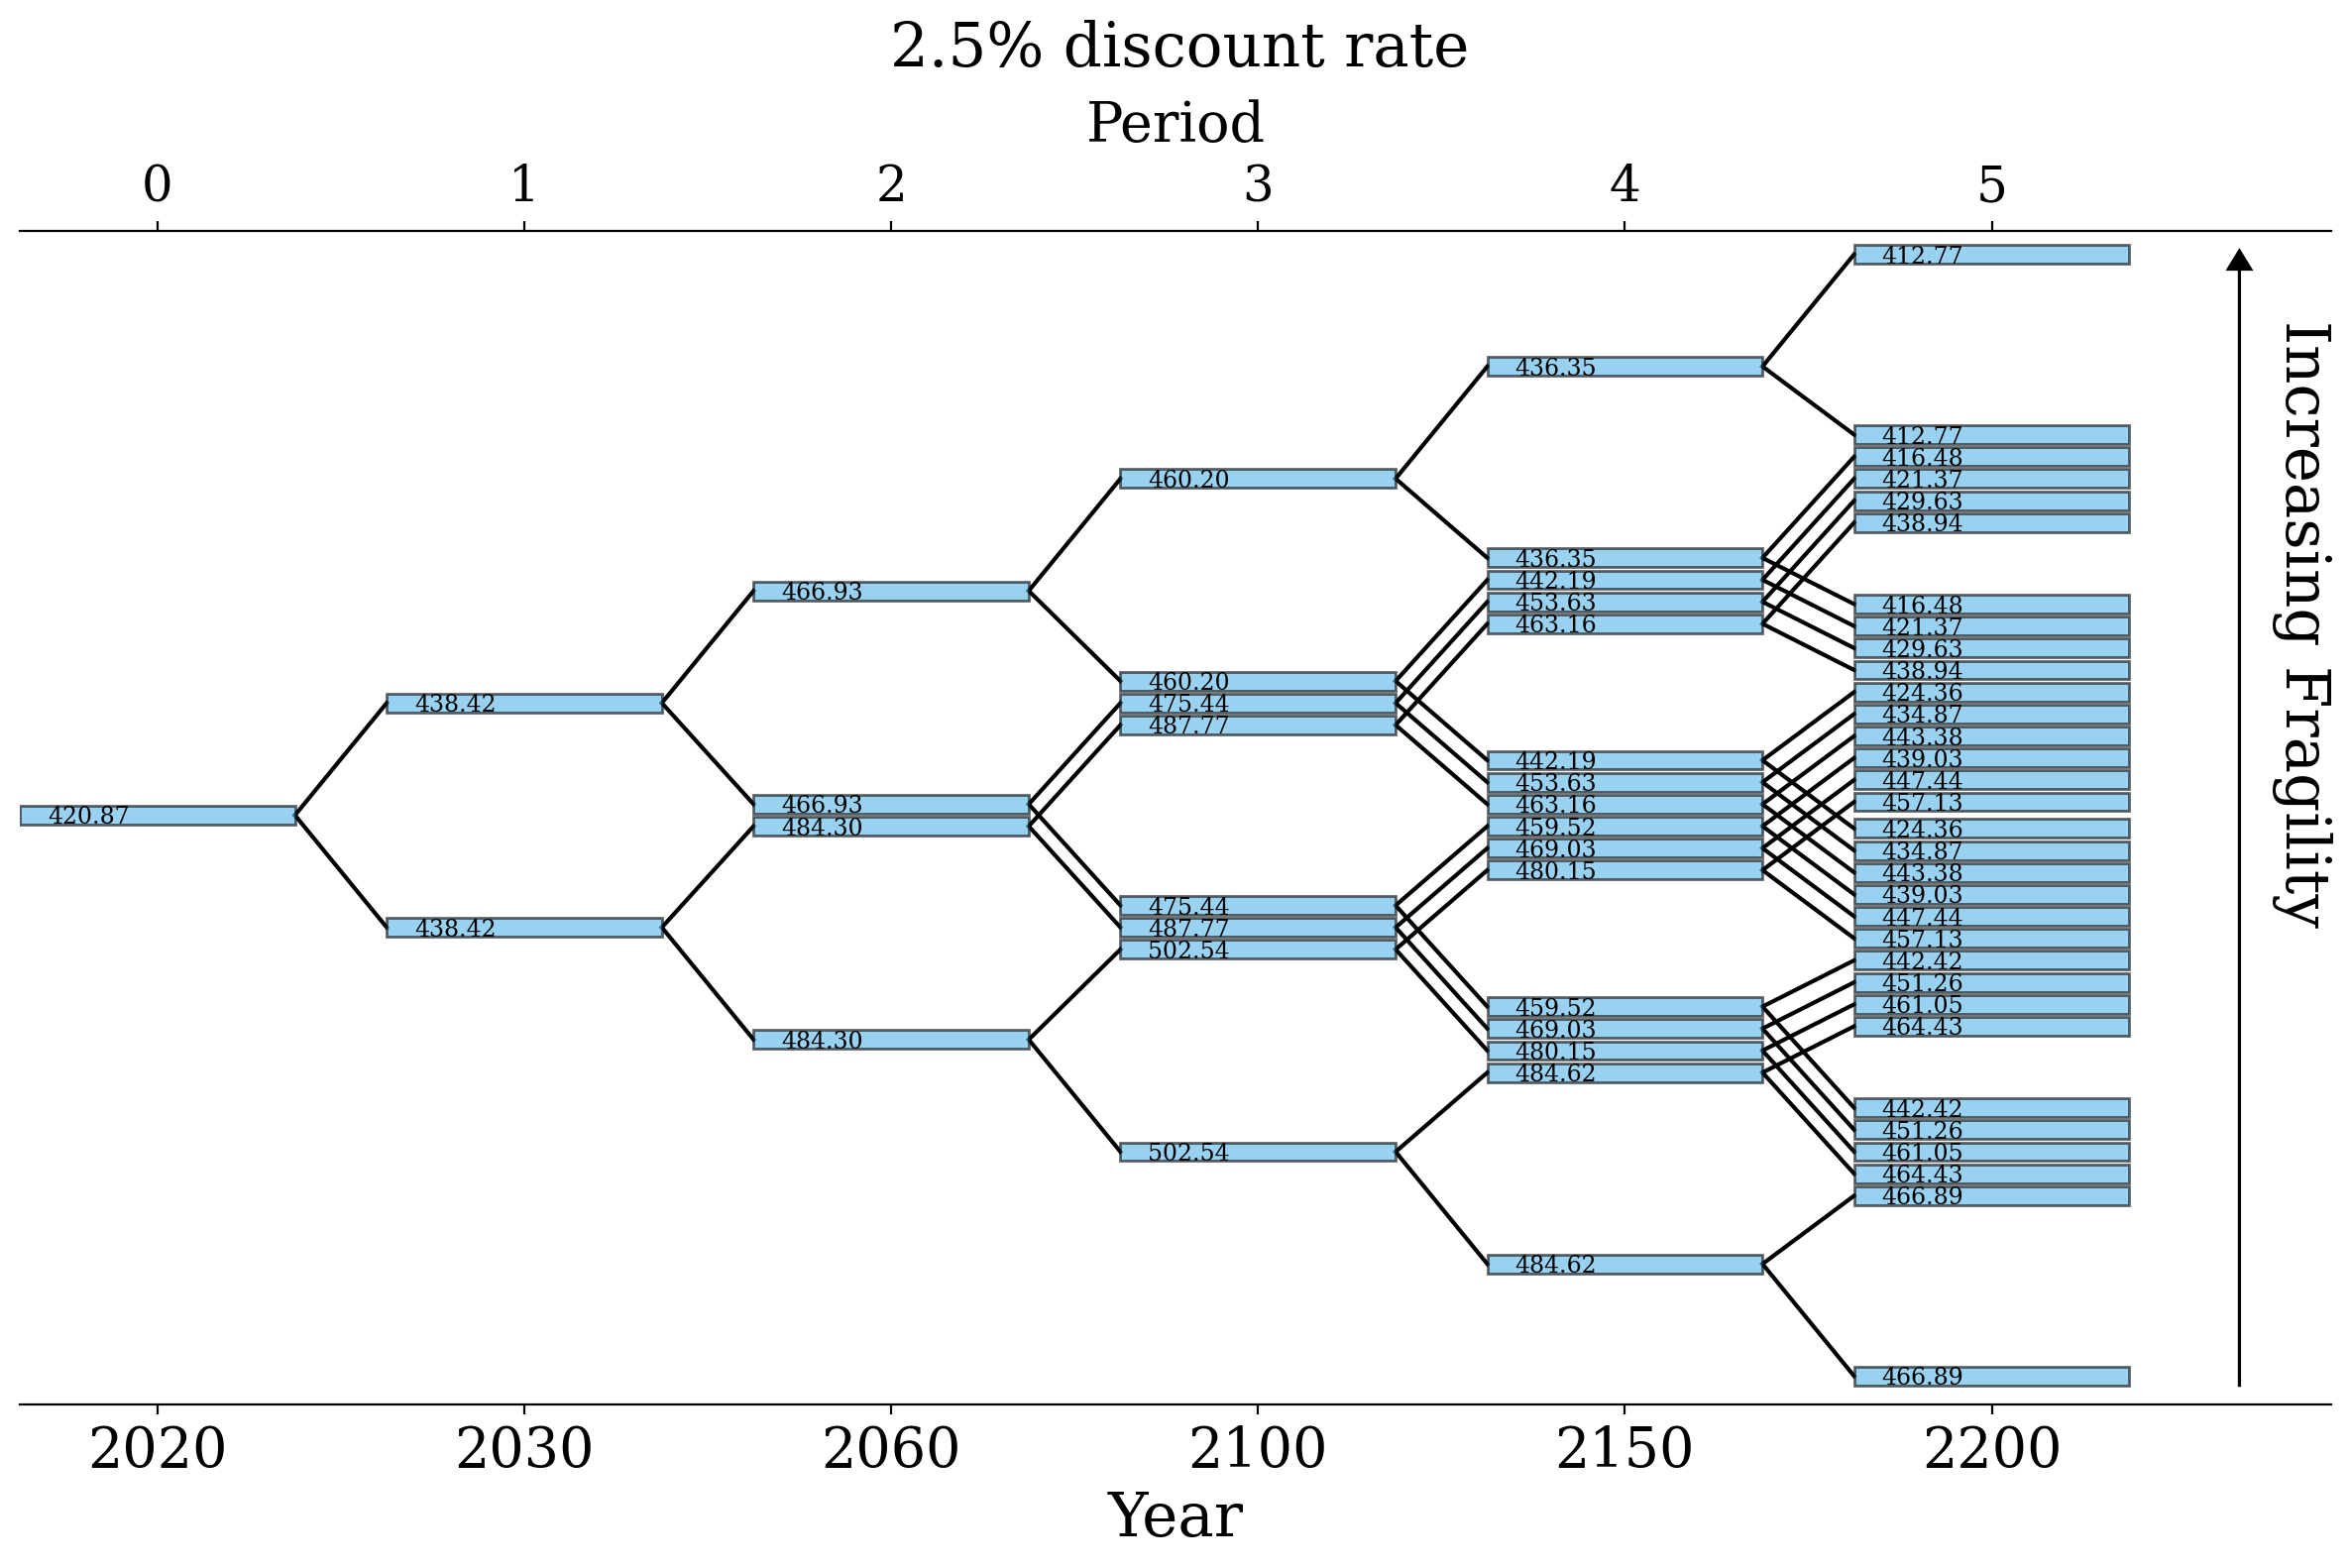

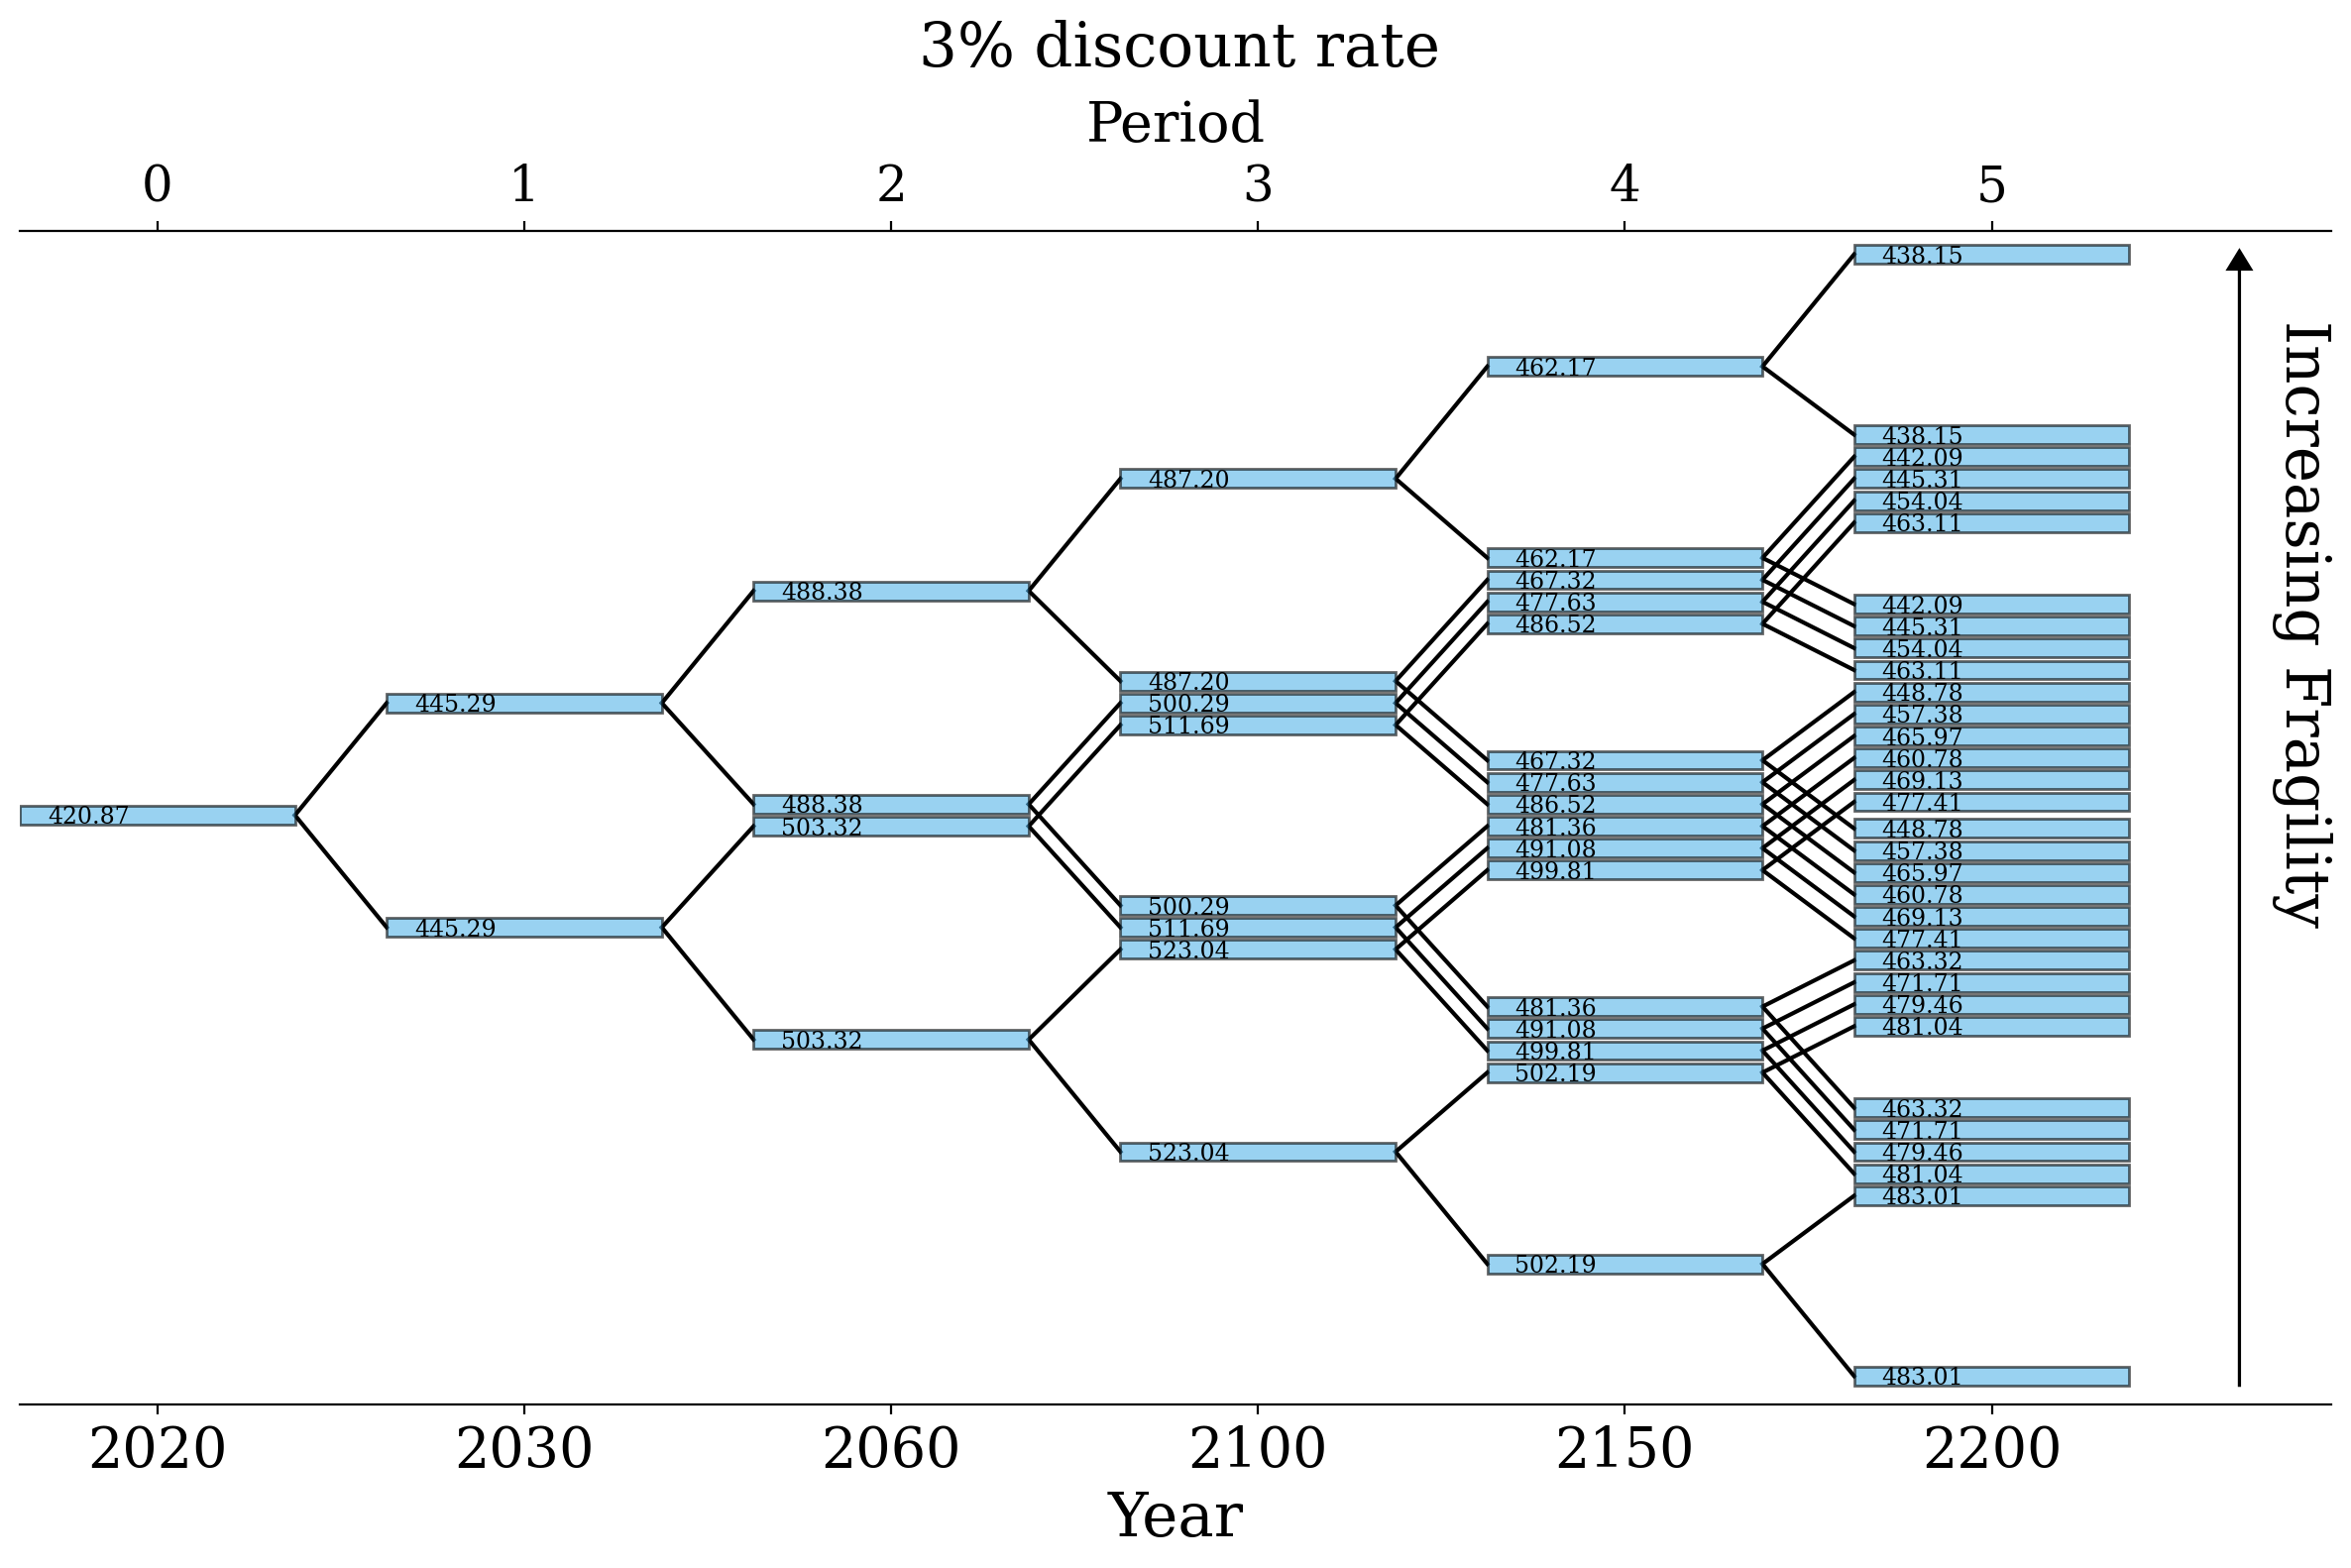

In [40]:
for file in range(0, N_files):
    tmp_Tree = TreeDiagram(6, output_obj_list[file].ghg_lvl_node, False, descriptions[file], save_fig=save_fig)
    tmp_Tree.makePlot()

### Damages

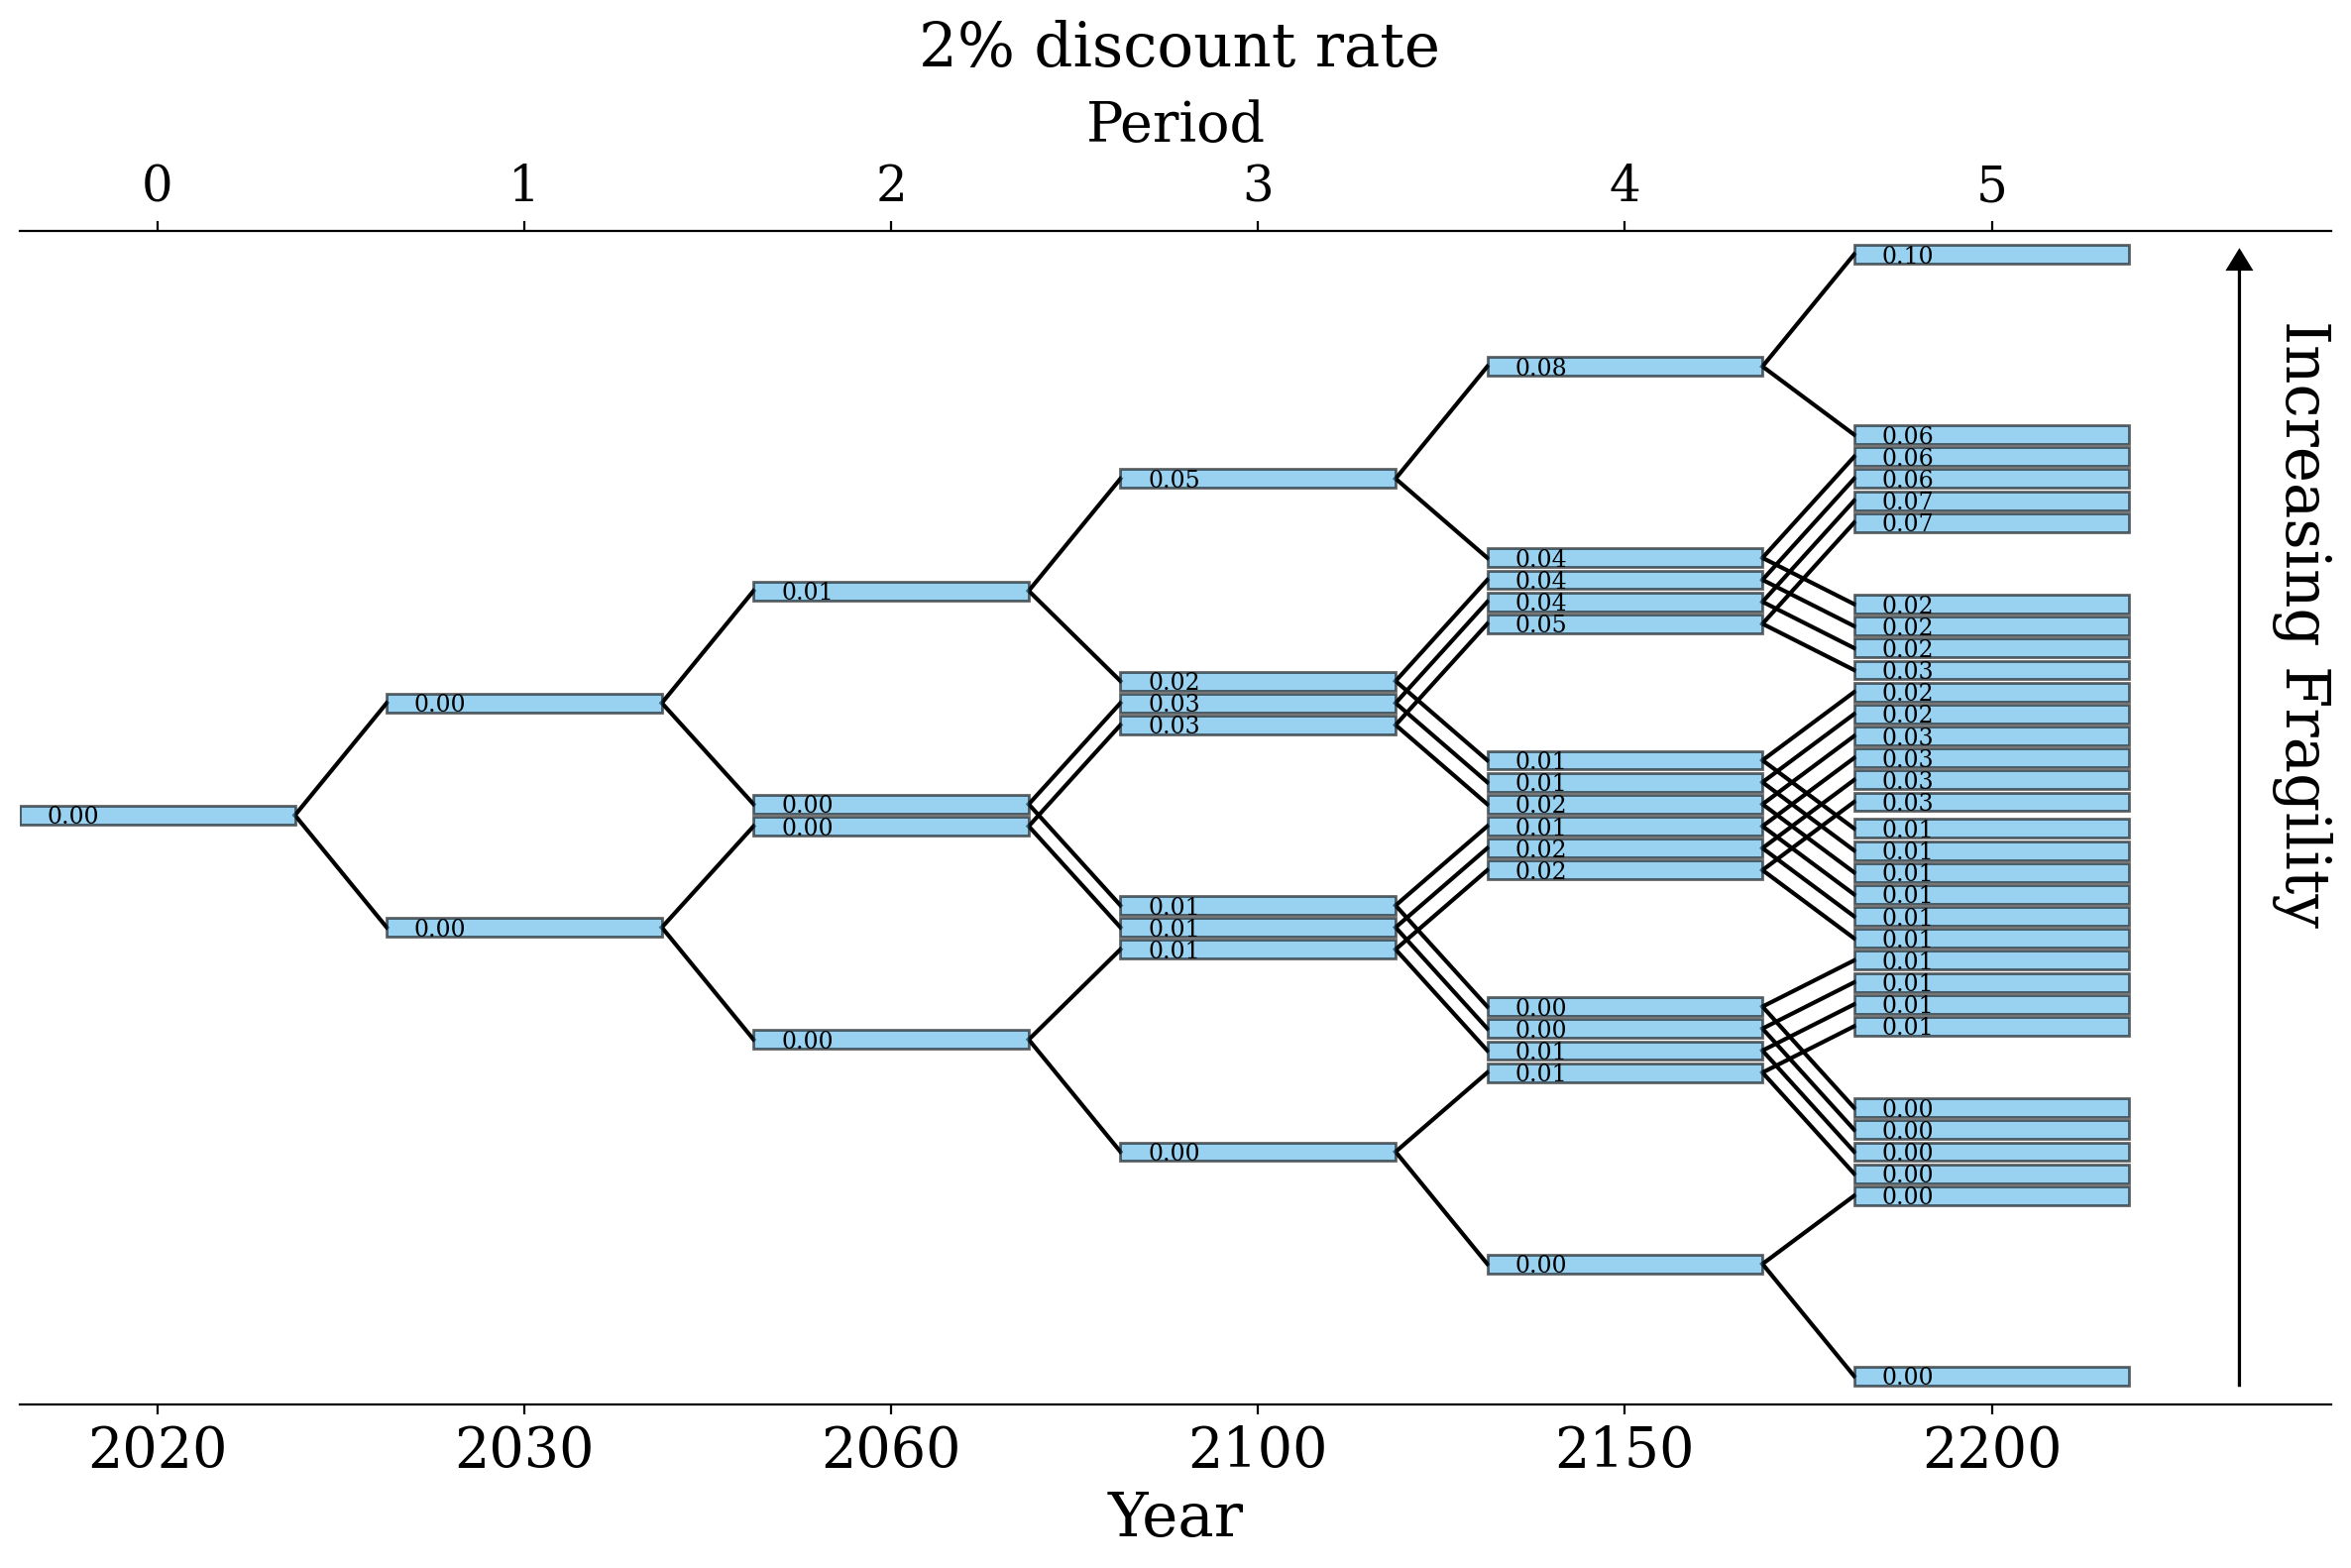

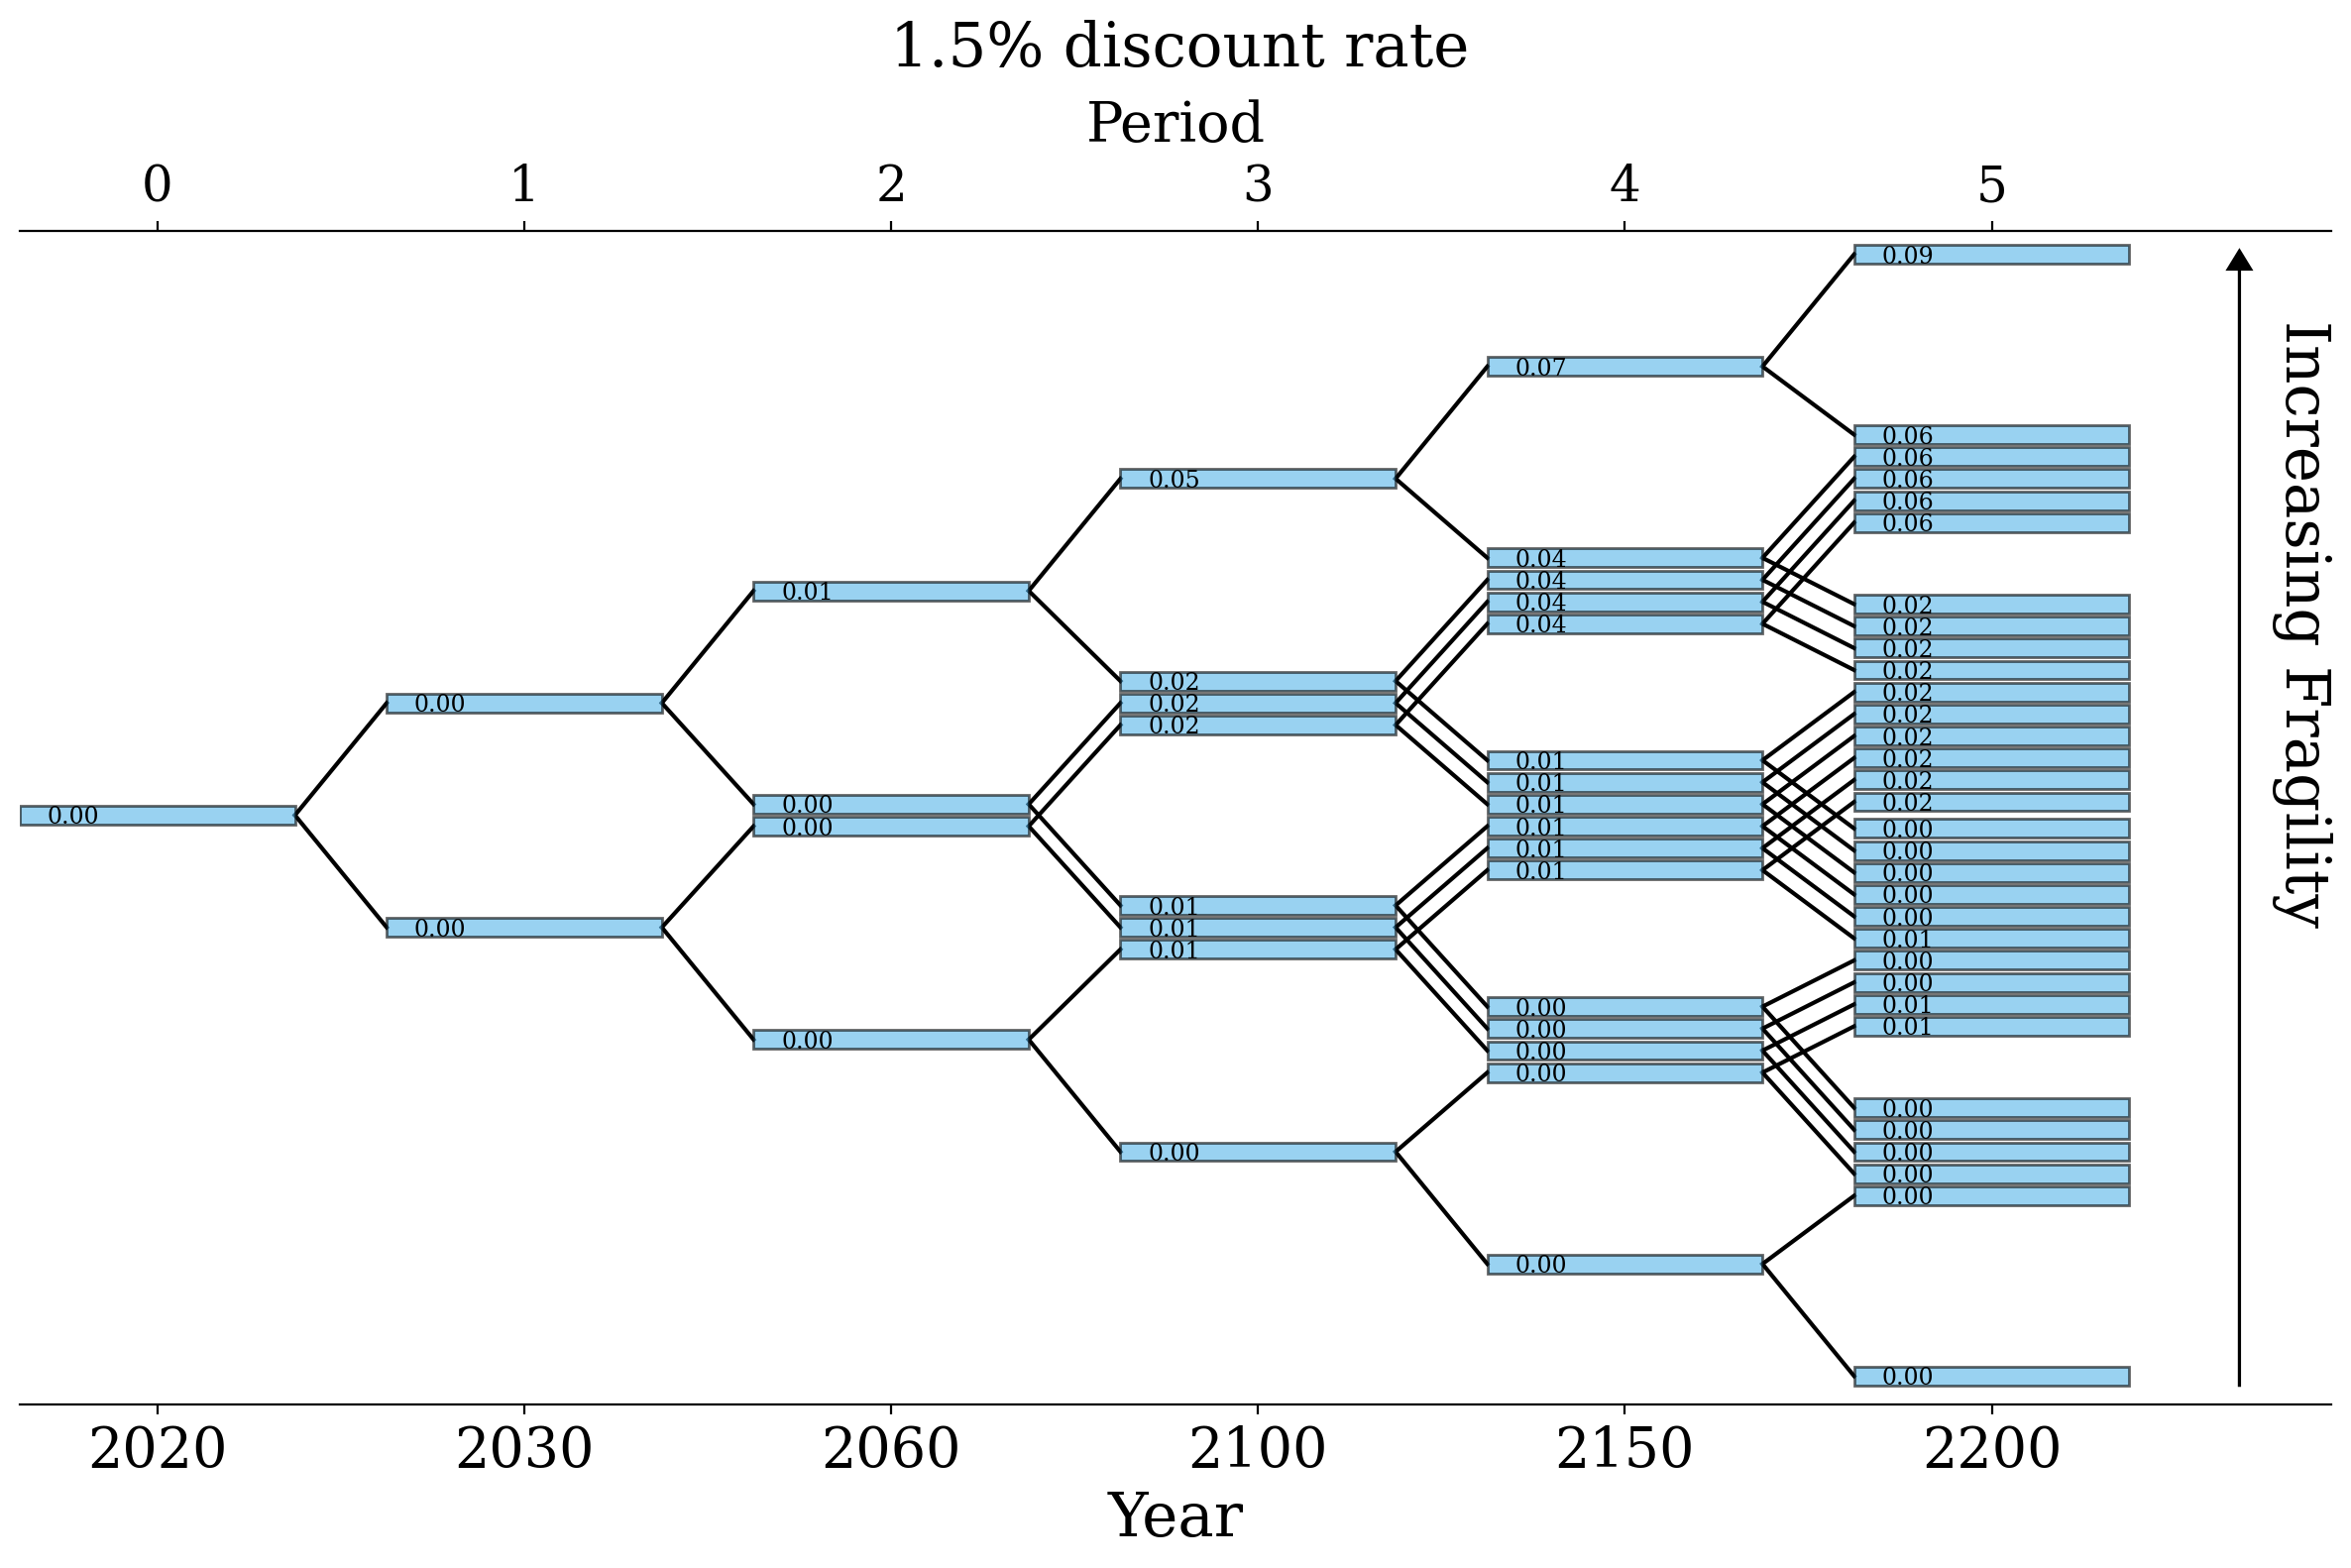

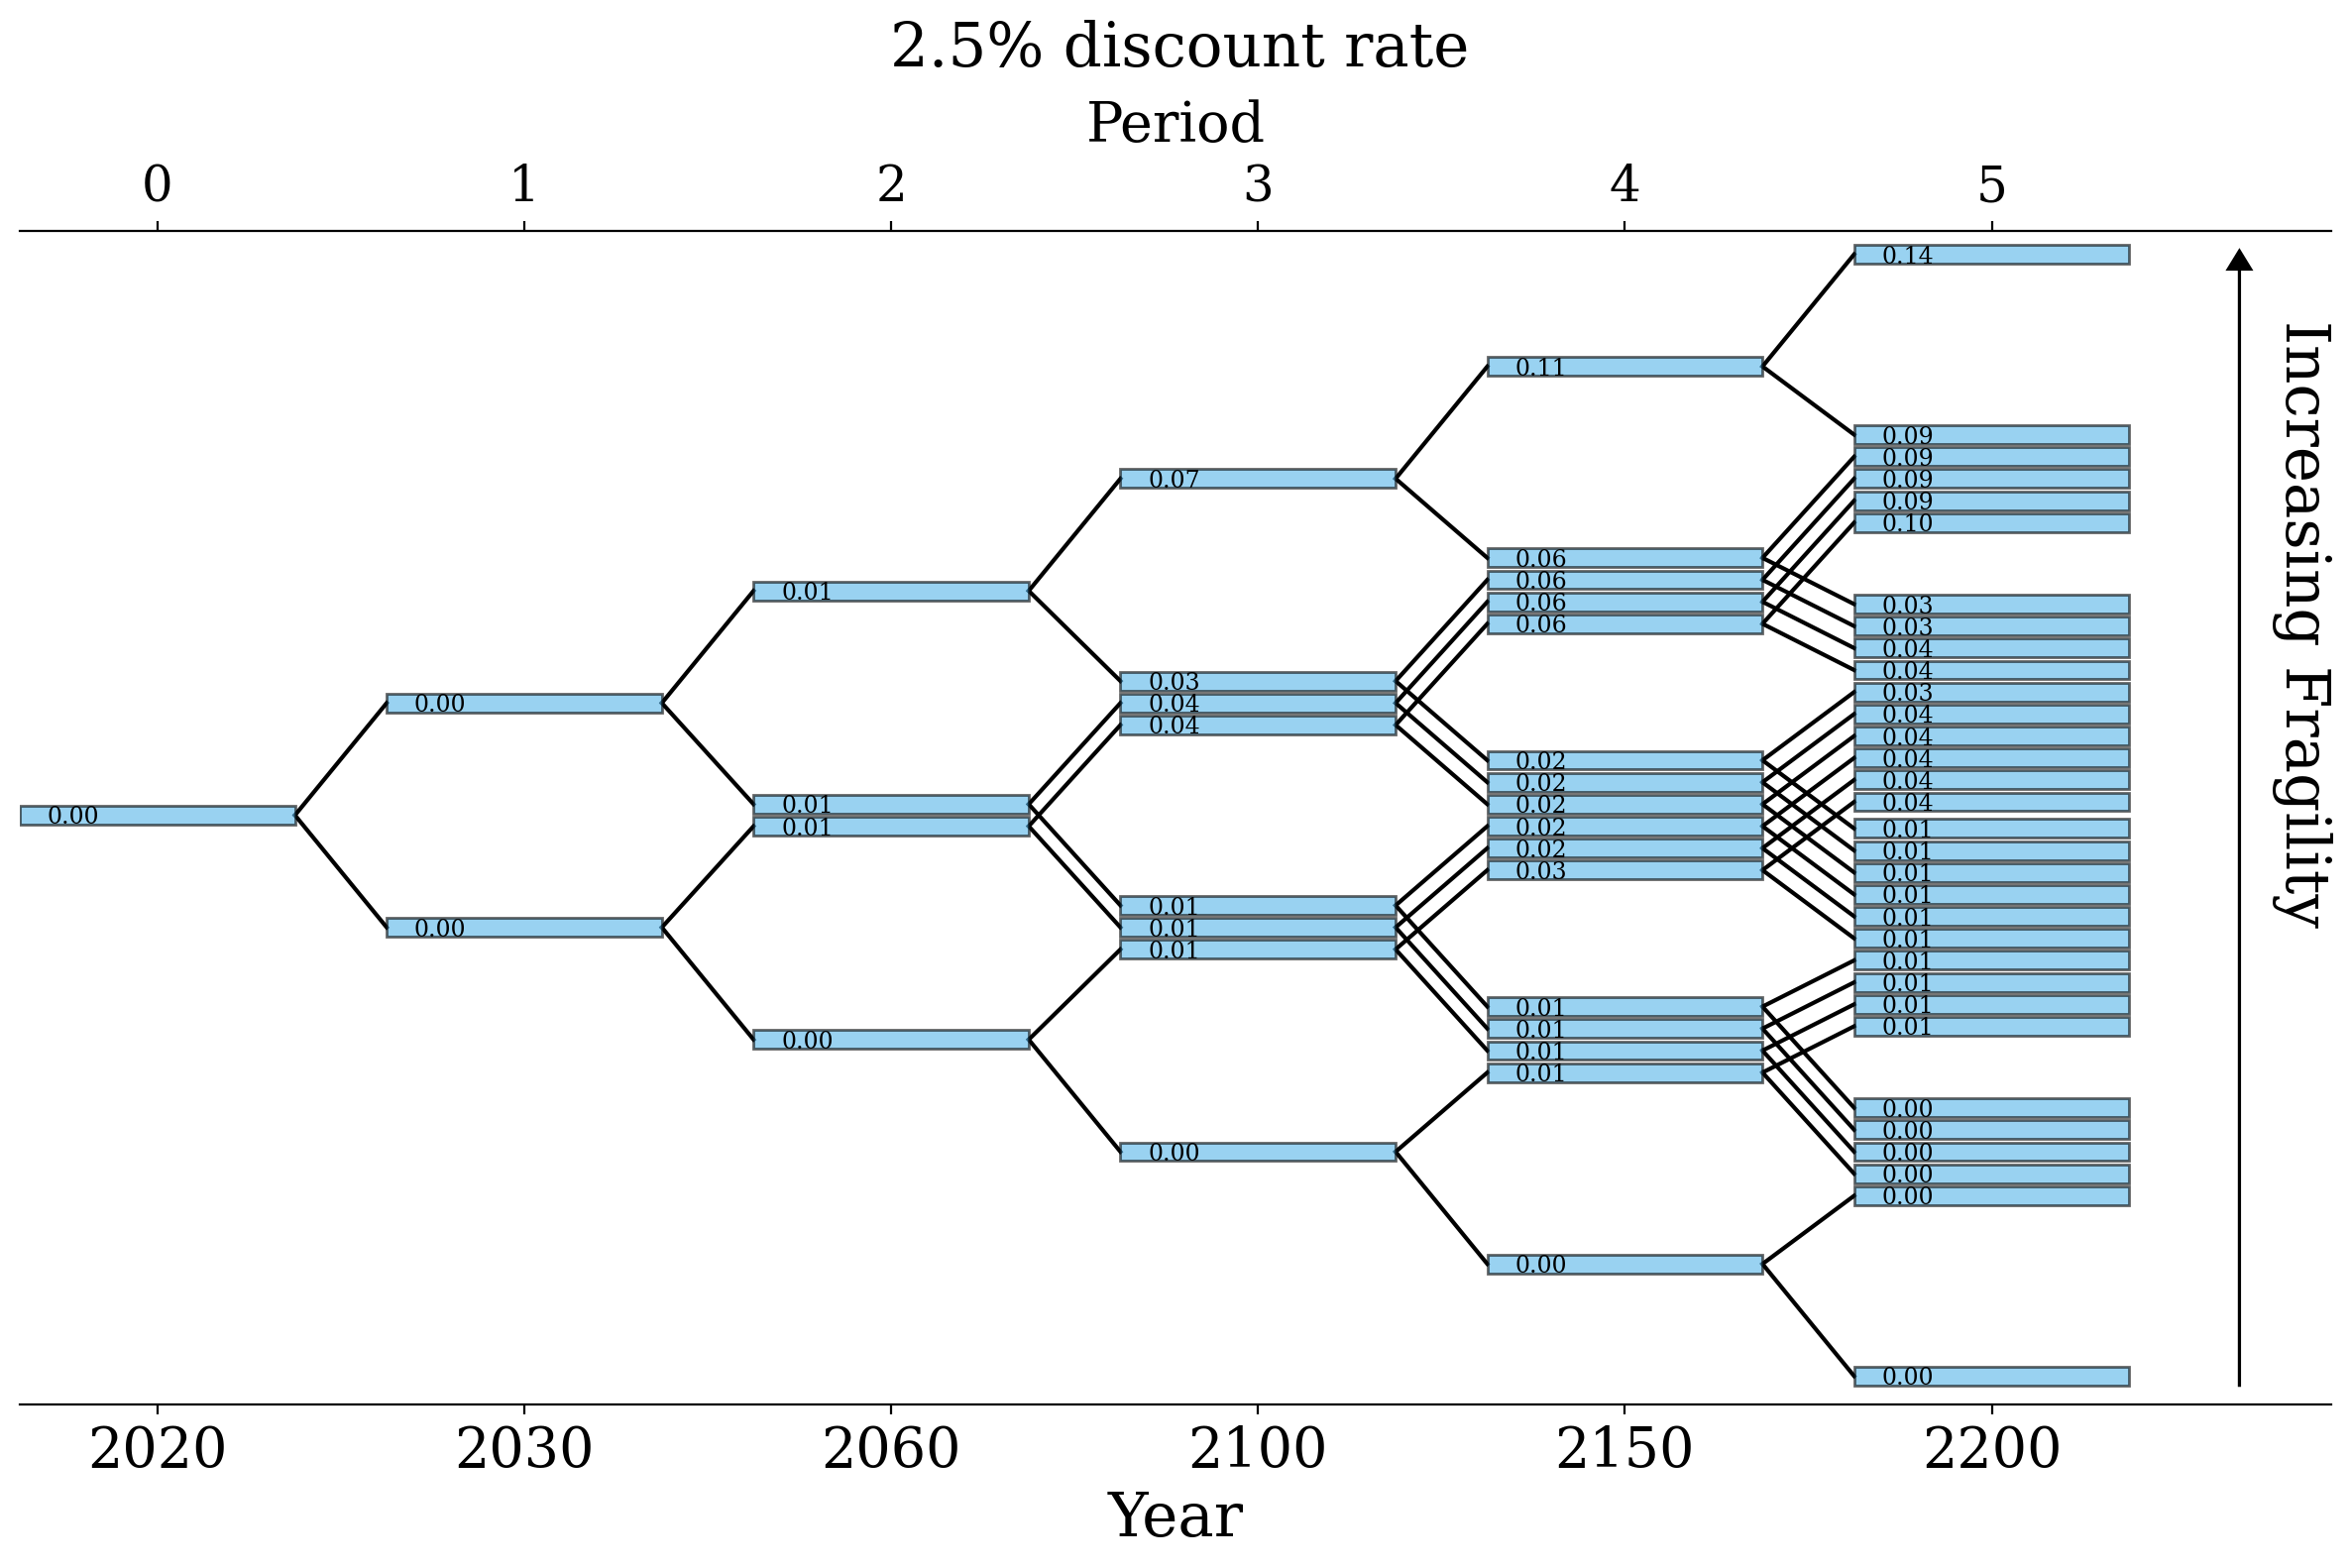

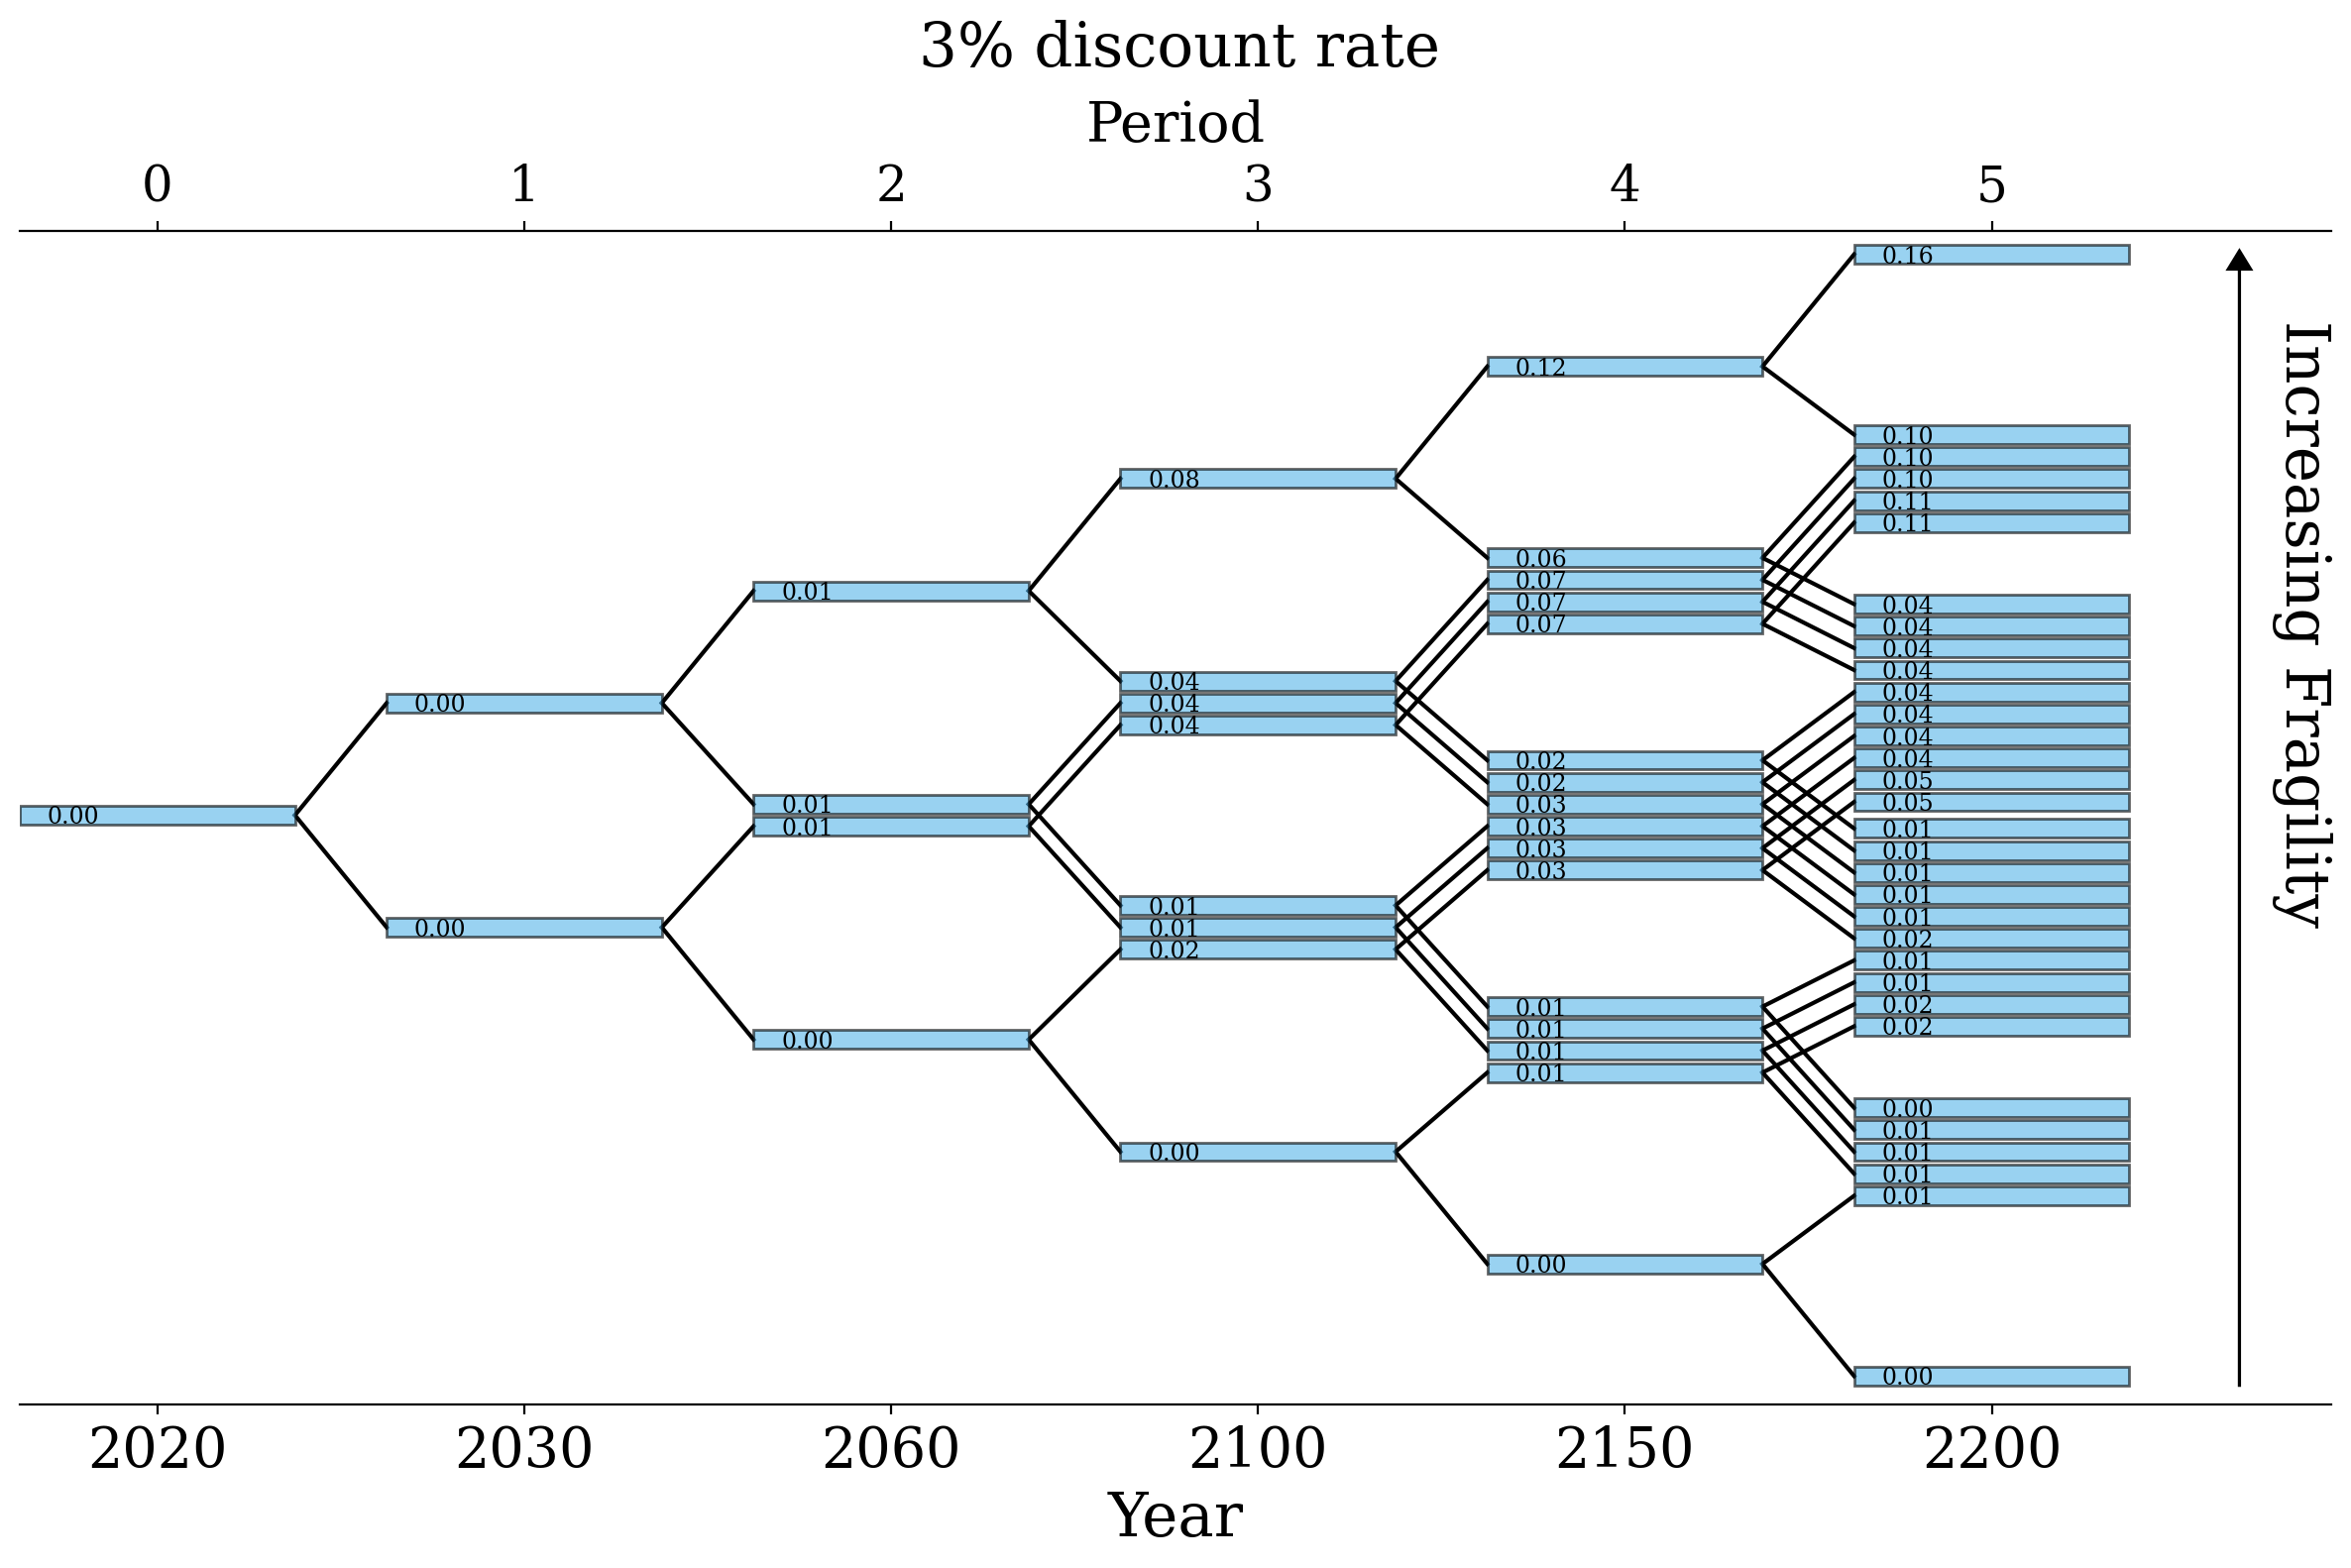

In [41]:
for file in range(0, N_files):
    tmp_Tree = TreeDiagram(6, pickle_obj_list[file].econ_dam_node, False, descriptions[file], save_fig=save_fig)
    tmp_Tree.makePlot()

## Paper figures: cost and damage with highlighted boxes

Remember to loop through only the runs you want: this bit of code assumes you only want the first run in the list made above.

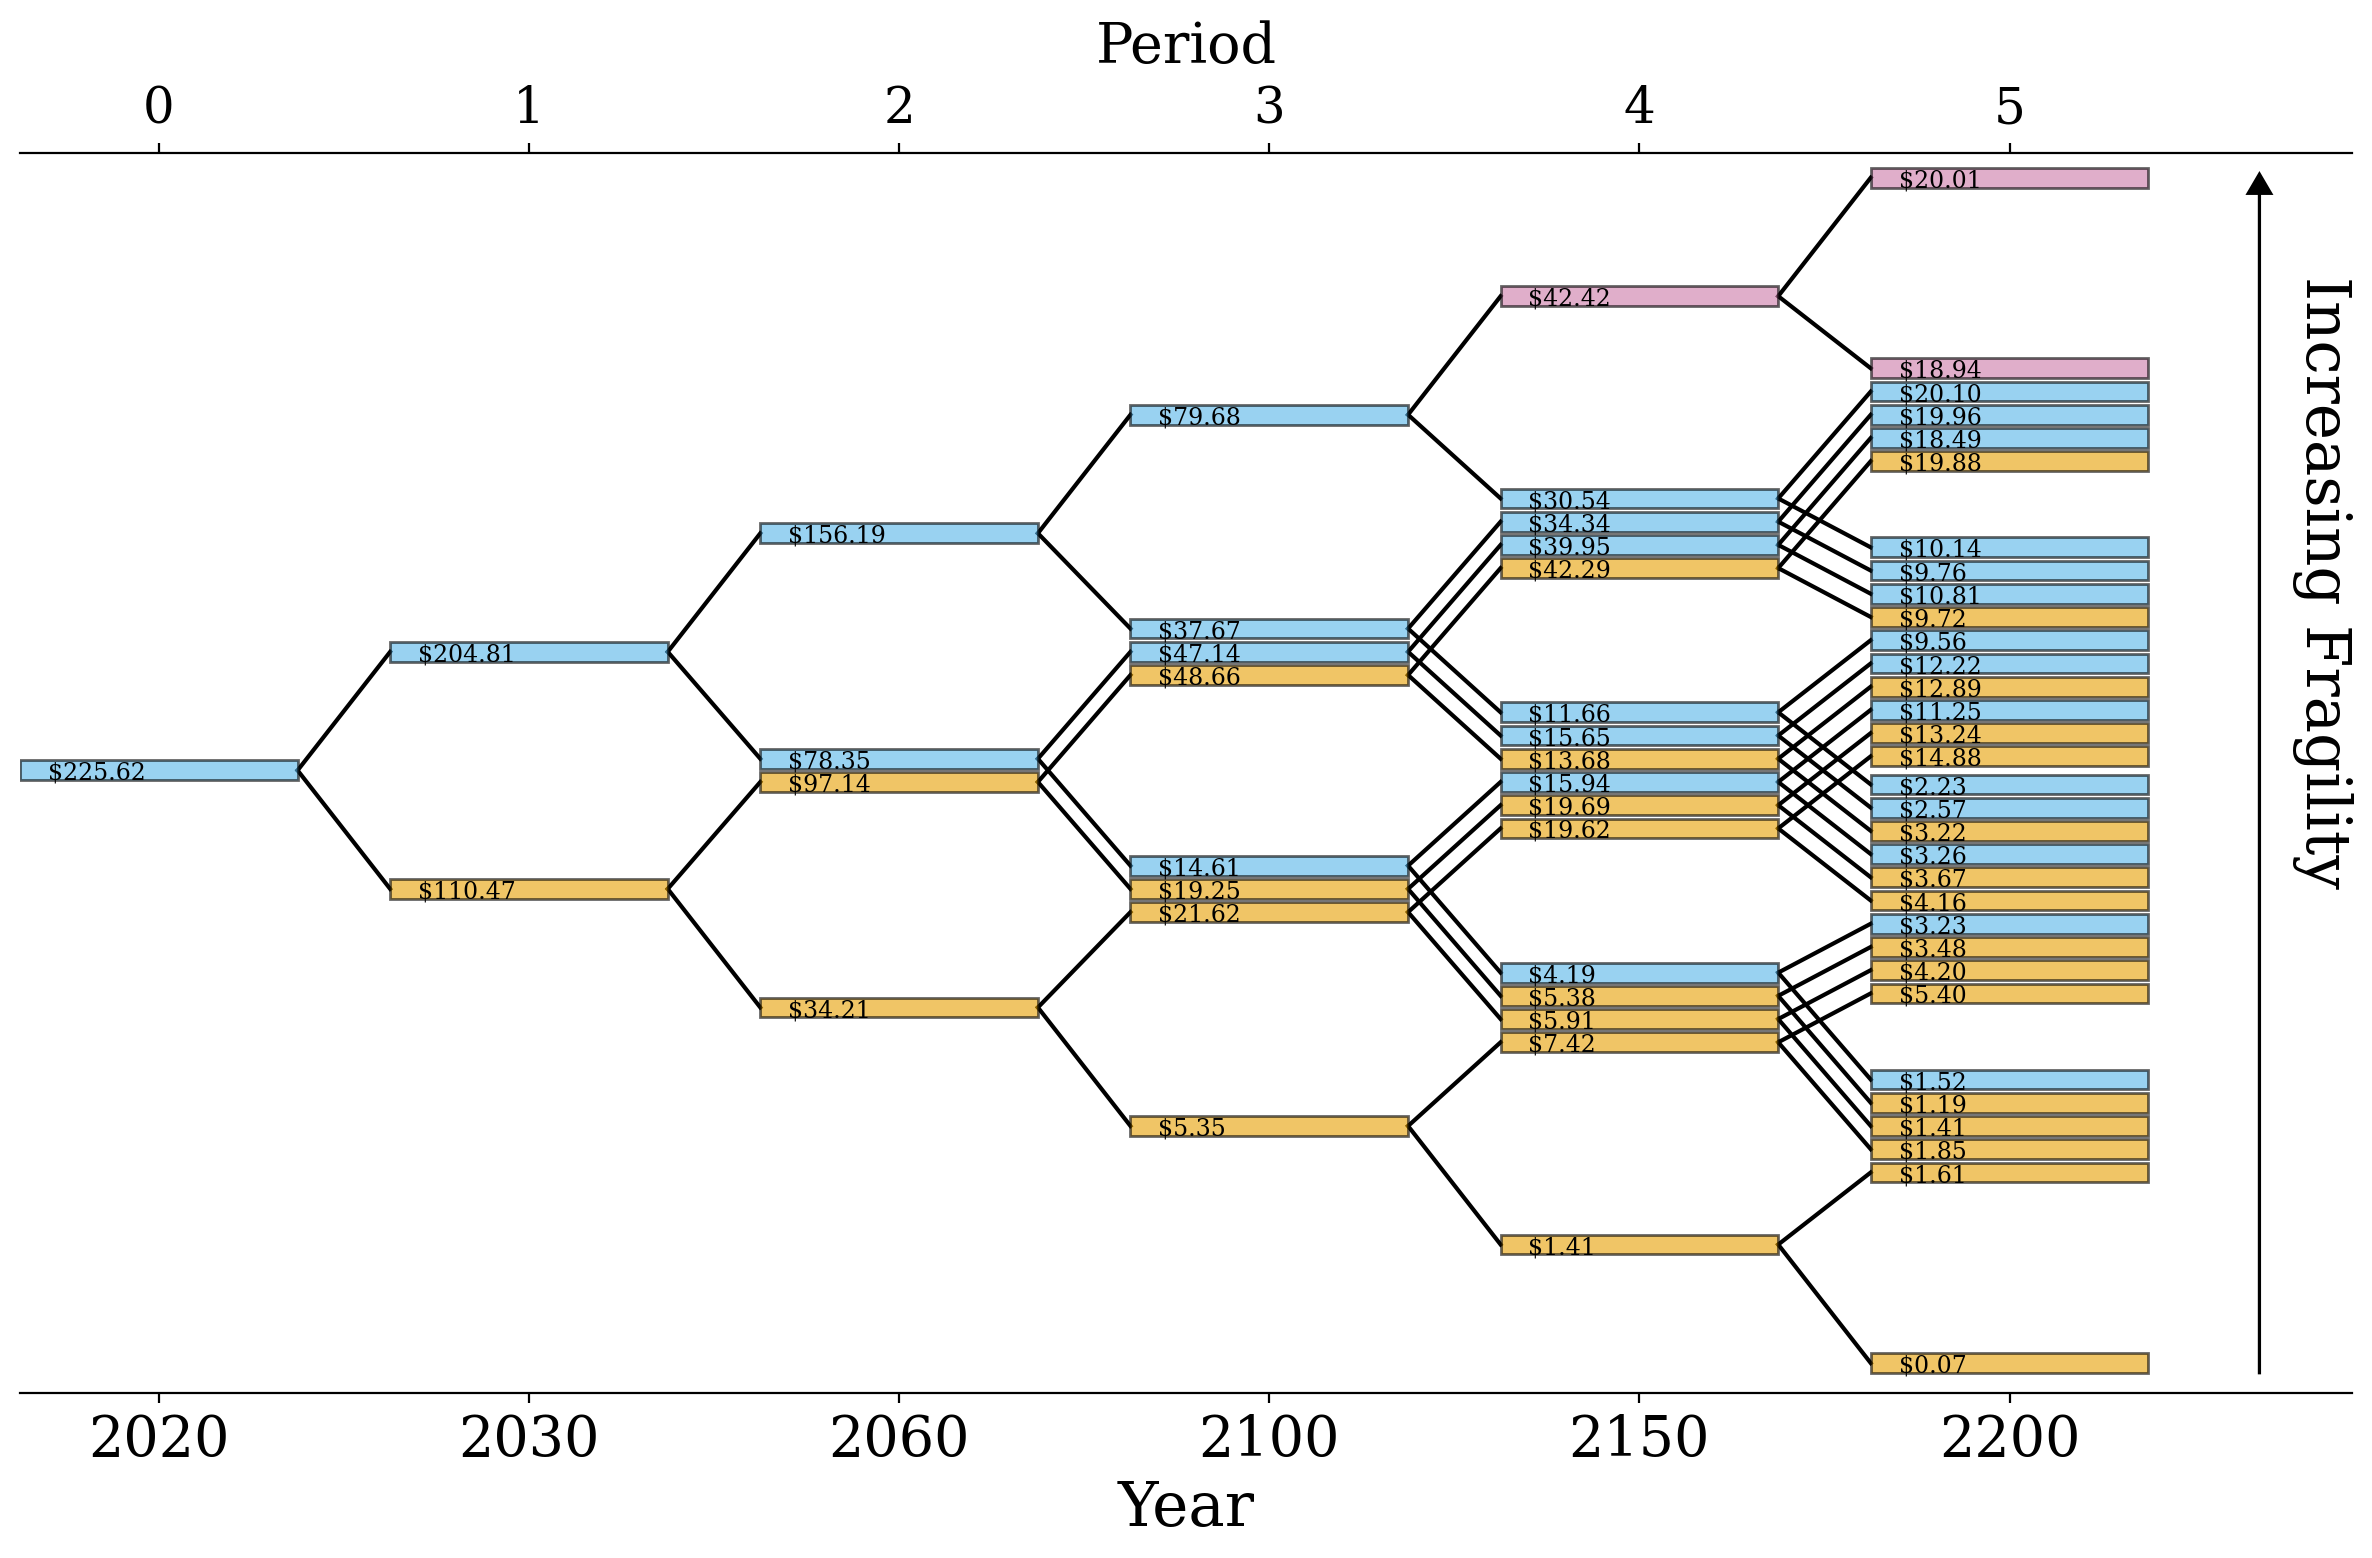

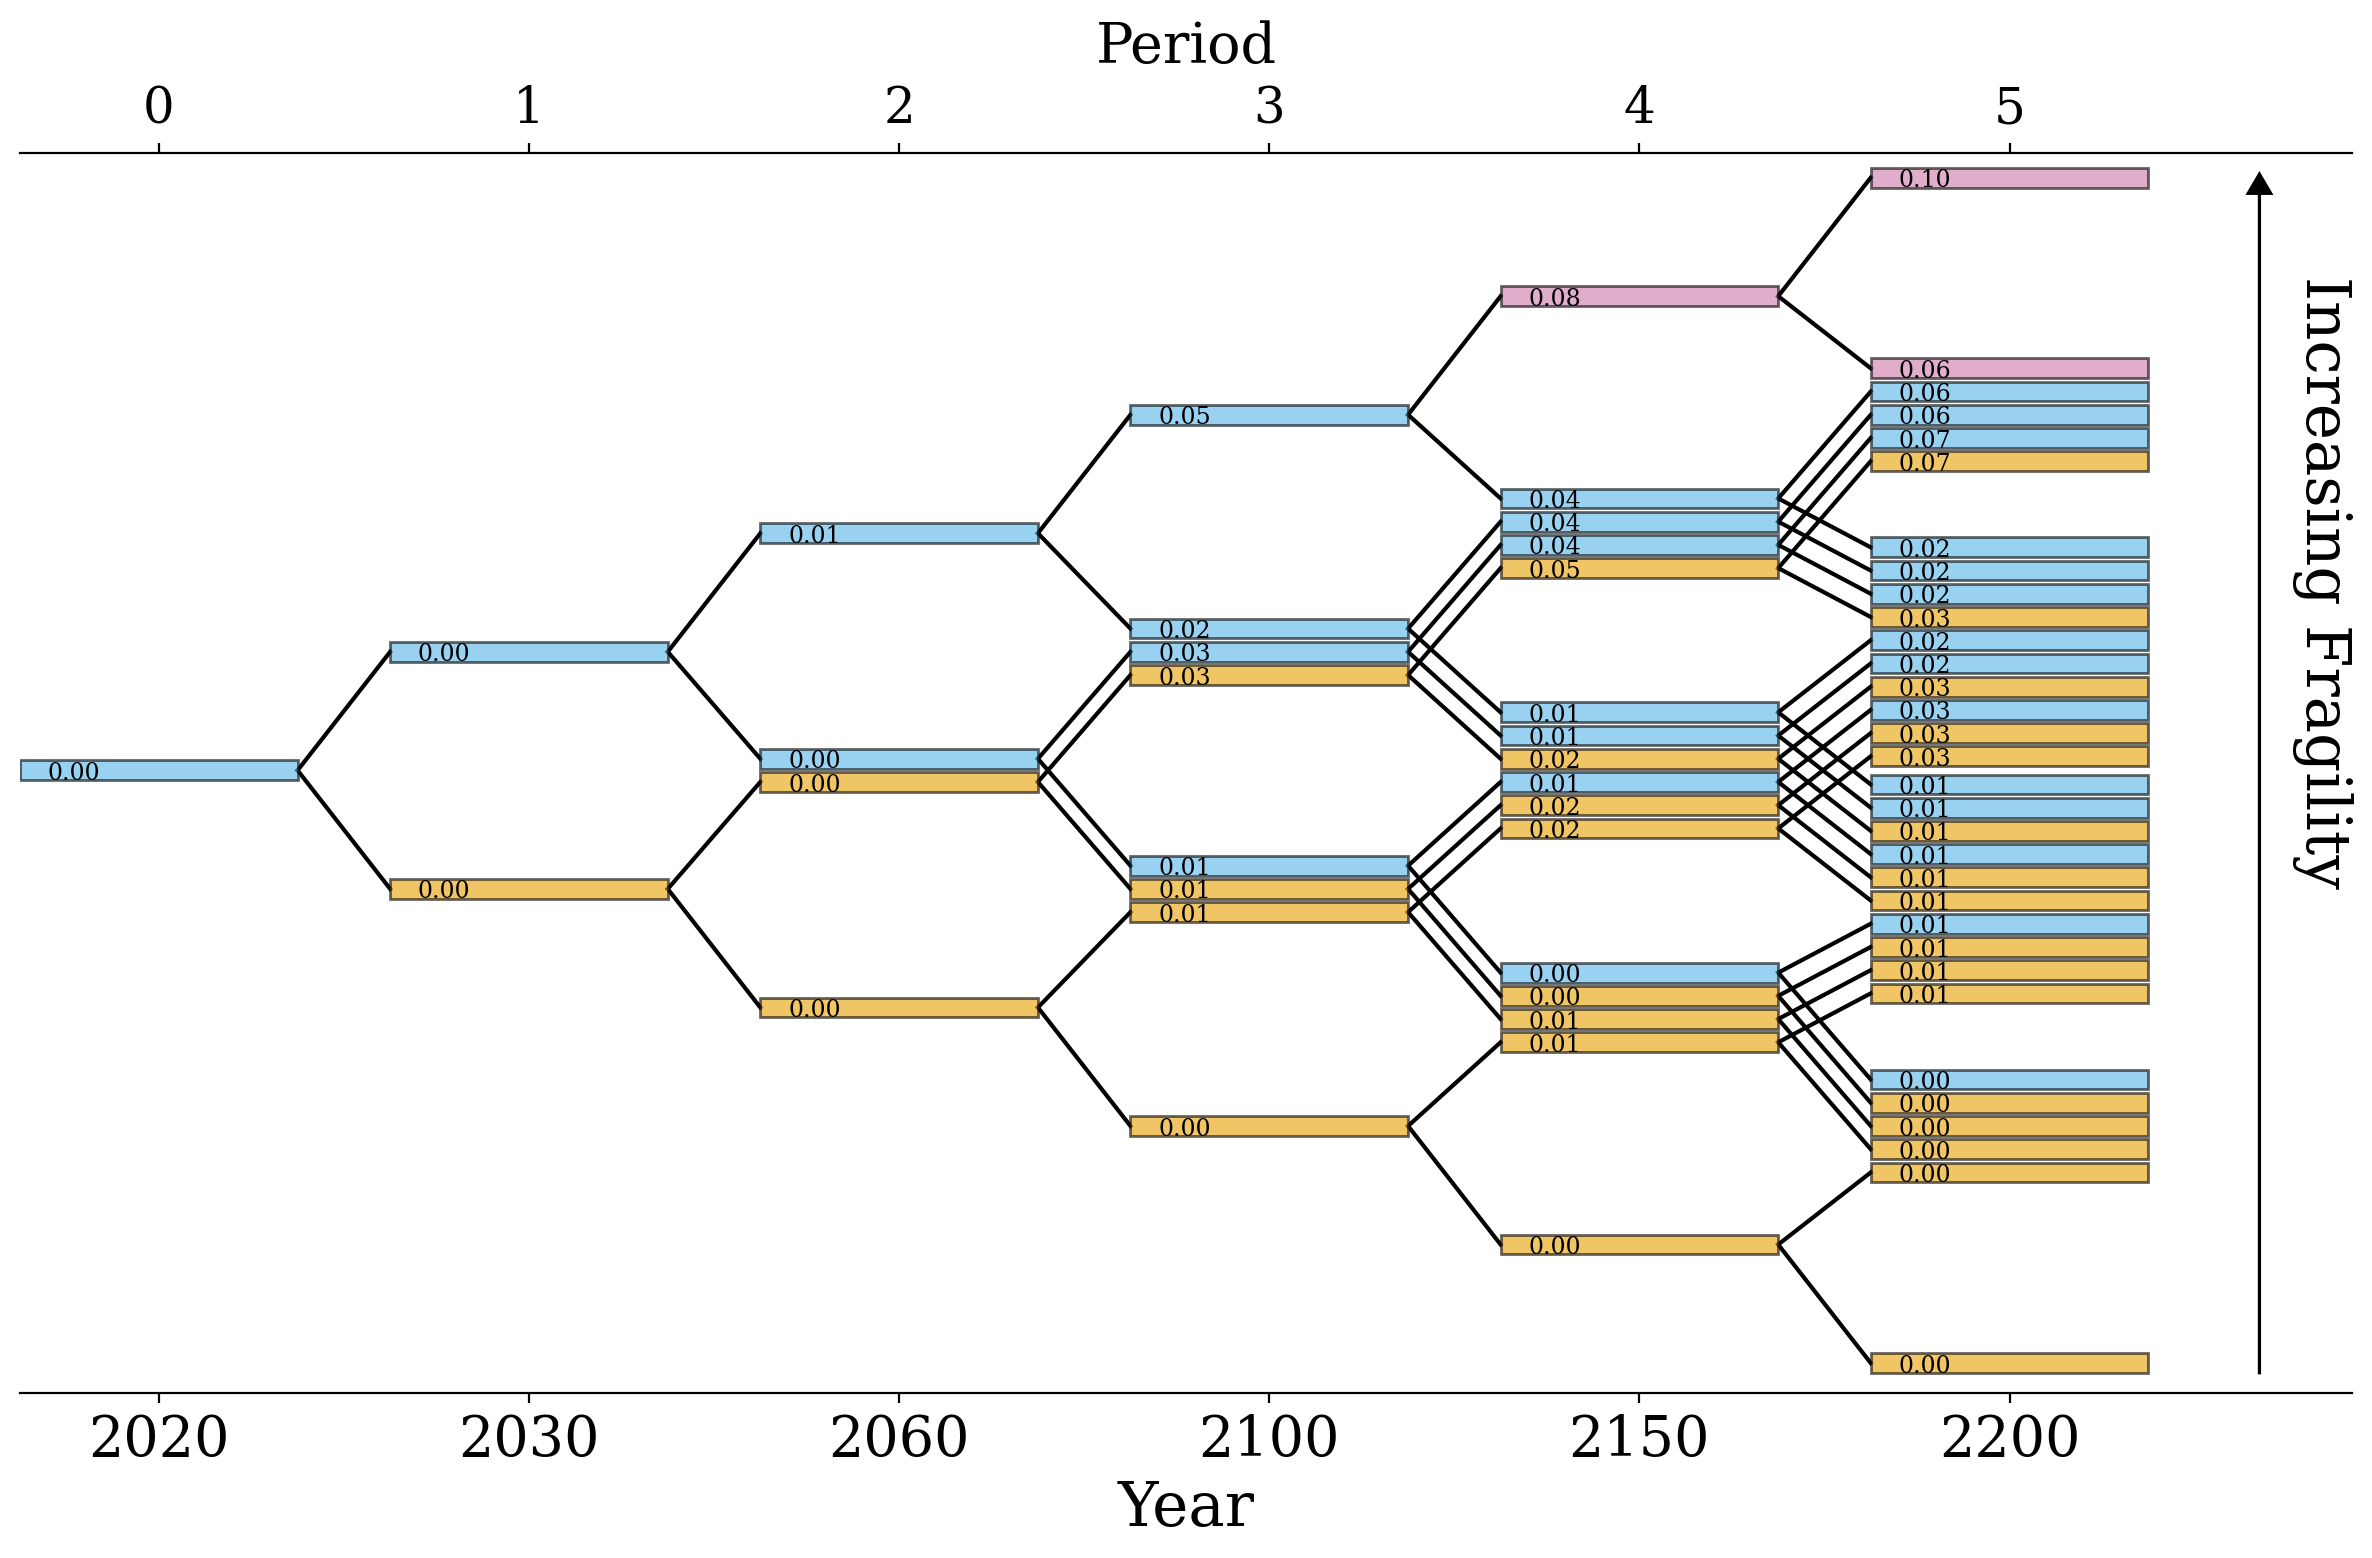

In [43]:
for file in range(0, 1):
    tmp_Tree = TreeDiagram(N_periods=6, data=output_obj_list[file].price_node, 
                           path_notation=False, plot_title=None, save_fig=True,
                          fig_name=''.join([basefile, 'cost-tree']), is_cost=True)
    tmp_Tree.makePlot(pfig=True)

for file in range(0, 1):
    tmp_Tree = TreeDiagram(N_periods=6, data=pickle_obj_list[file].econ_dam_node, 
                           path_notation=False, plot_title=None, save_fig=save_fig,
                          fig_name=''.join([basefile, 'dam-tree']), is_cost=False)
    tmp_Tree.makePlot(pfig=True)

## Analysis: Checking recombined node structure

/tmp/ipykernel_27559/2277933762.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nodes = np.arange(0, 63, 1, dtype=np.int)


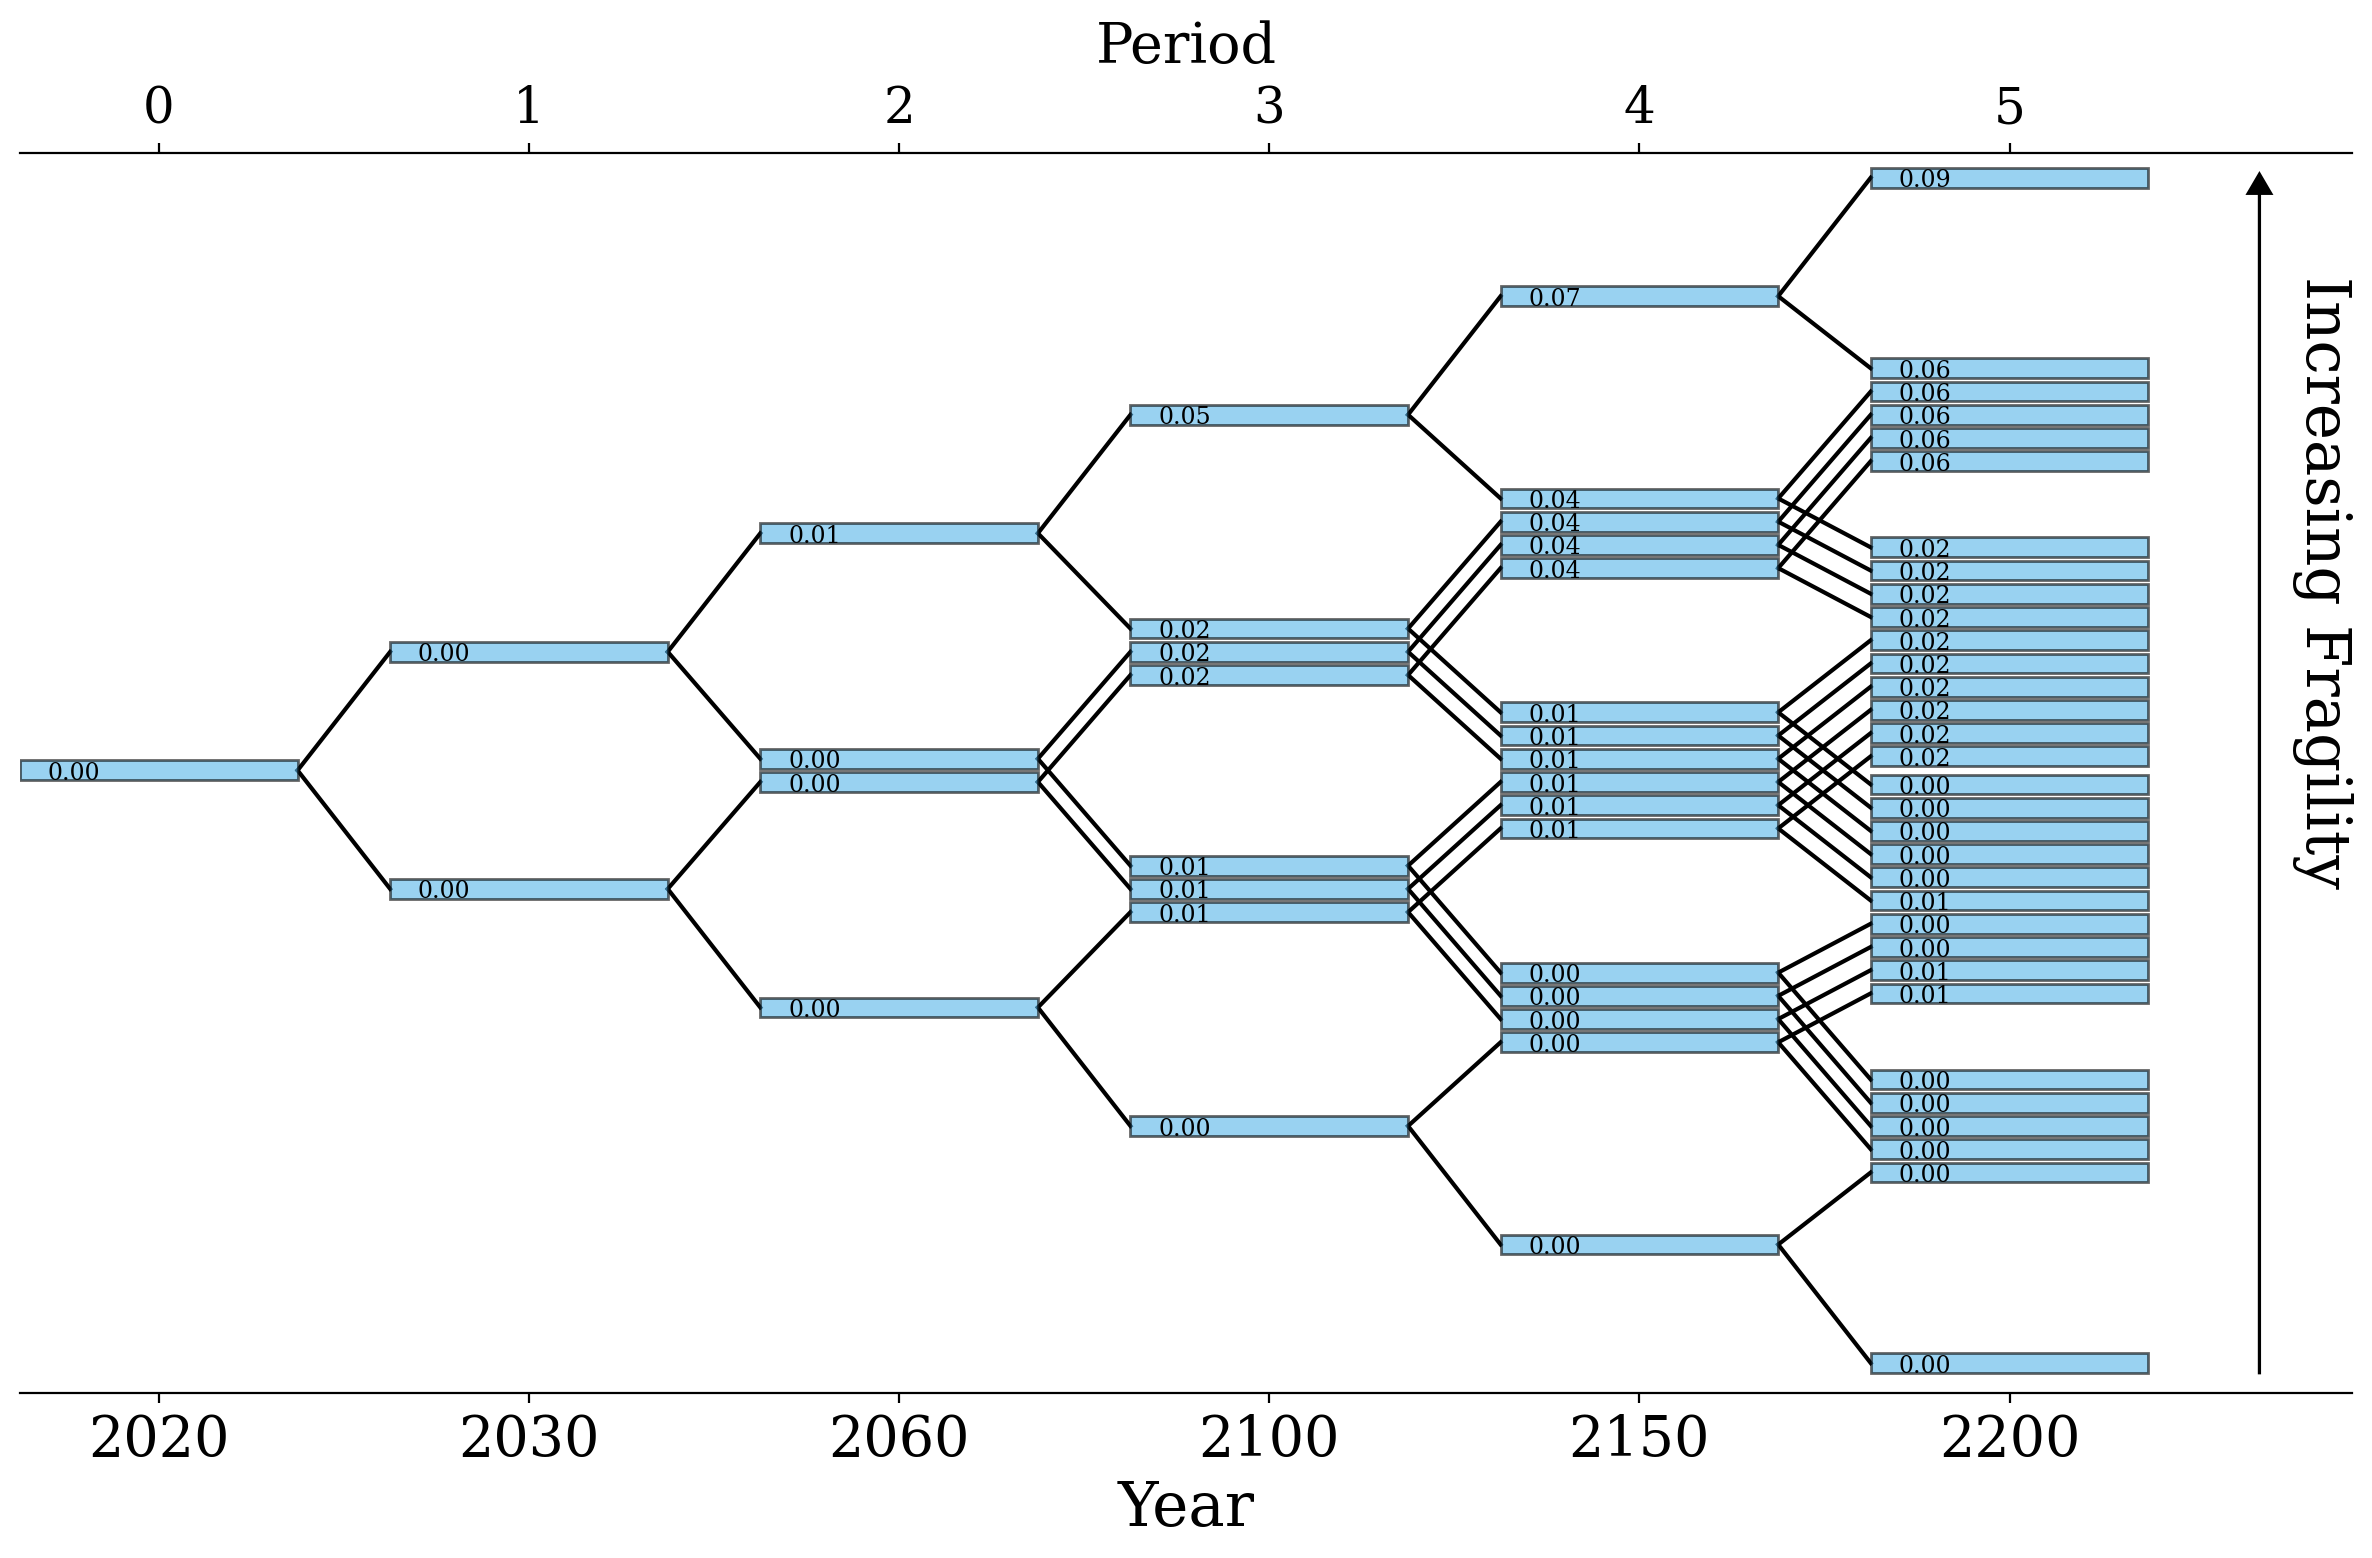

In [31]:
nodes = np.arange(0, 63, 1, dtype=np.int)
mit = pickle_obj_list[1].m_opt_node
#mit = np.array([0.0] * len(nodes))
dams = np.zeros_like(nodes, dtype=np.float32)
for node in nodes:
    dams[node] = damage_list[0]._damage_function_node(mit, node)


tmp_Tree = TreeDiagram(N_periods=6, data=dams, 
                       path_notation=False, plot_title=None, save_fig=save_fig,
                      fig_name=''.join([basefile, 'dam-tree']))
tmp_Tree.makePlot(pfig=False)